# S Forecast Examples

## Contents

This notebook demonstrates how to employ sforecast (sliding/expanding window) to make forecast predictions using three types of models - classical forecast models, SK learn models such as XGBoost, and Tensorflow. 

Models are based on existing implentations. For the case of SK Learn models and TensorFlow, the models are defined externally to sforecast and a reference to the model is passed into sforecast. For the classical forecasting models (ARIMA, SARIMAX, AUTOARIMA), the model parameters are passed into sforecast. 

The notebook demostrates examples for each these model types such as working with univariate and multivariate data, exogenous variables,examples of several deep learning models, including the use of categorical embeddings, deep learning (hidden layers), and LSTMs.

The notebook demonstrates the mechanics of setting up and running the corresponding data and models. Mathematical, statistical, and interpretation discussions are out of scope of this notebook. 

1. Classical Forecasting Models 
   * ARIMA
   * SARIMAX
   * Auto ARIMA  

2. SK Learn ML Models
   * Superstore Data
   * Transforming to Wide Data Format
   * Univariate with XGBoost
   * Multivariate with one output
   * Multivariate with and multiple outputs

3. TensorFlow DL Models
   * M5 Walmart Sales Data, 7 Items
   * Univariate Deep Learning Deep Learning
   * Univariate + Categorical Embeddings
   * Multivariate + Exogenous + Categorical Embeddings, Single Output 
   * Multivariate + Exogenous + Categorical Embeddings, Multiple Output 
   * Multivarate LSTM + Exogenous + Categorical Embeddngs, Multiple Output

## Initialize Notebook

In [1]:
import sforecast as sf
print(f'sforecast version = {sf.__version__}')
import pandas as pd
import numpy as np
import beautifulplots as bp
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from pandas.plotting import autocorrelation_plot
datapath = "../data"

sforecast version = 0.1.0


## 1. Classical Models

### ARIMA, Shampoo Sales

load data

df_shampoo.shape = (36, 2)


Month  Sales
0 1901-01-01  266.0
1 1901-02-01  145.9
2 1901-03-01  183.1
3 1901-04-01  119.3
4 1901-05-01  180.3

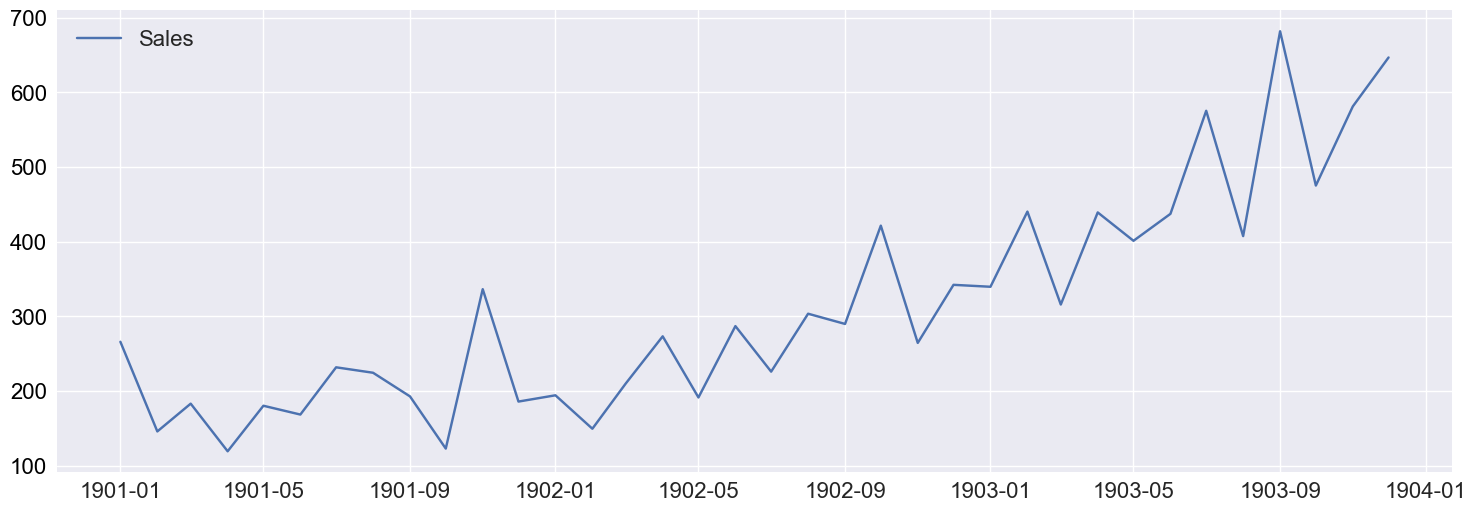

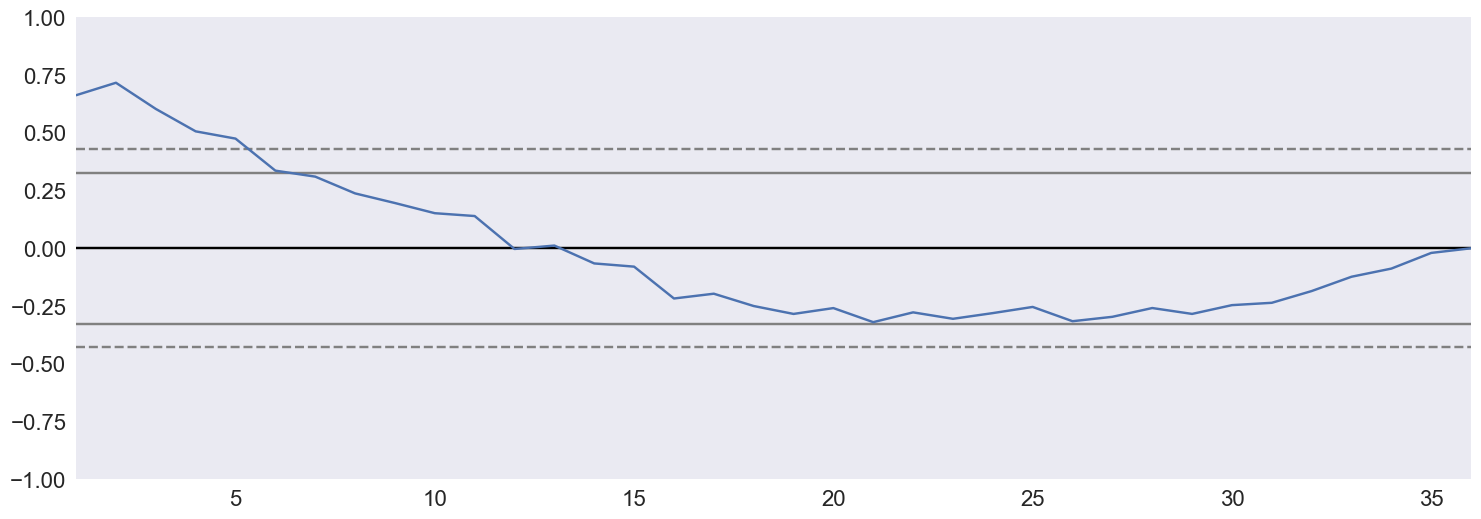

In [2]:
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ ... date parser and dataset
def dateparser(x):
    return datetime.strptime('190'+x, '%Y-%m')

df_shampoo = pd.read_csv(f'{datapath}/shampoo.csv', parse_dates = ["Month"], date_parser=dateparser)
print("df_shampoo.shape =",df_shampoo.shape)
display(df_shampoo.head())
bp.lineplot(df_shampoo, x = "Month", y="Sales", figsize=(18,6), y_axis_format=".0f")

# Plot Sales Autocorrelation
fig,ax = plt.subplots(nrows=1, ncols=1,figsize=(18,6)) 
g=autocorrelation_plot(df_shampoo["Sales"])

plot_options = bp.plot_defaults()
bp.set_axisparams(plot_options,ax,g)
plt.show()


Fit - ARIMA sliding 5 period forecast

dfXY


Month  Sales
0 1901-01-01  266.0
1 1901-02-01  145.9
2 1901-03-01  183.1
3 1901-04-01  119.3
4 1901-05-01  180.3


metrics = {'Sales_pred': {'RMSE': 96.4139361648774, 'MAE': 78.28000065334483}}


Month  Sales  Sales_train  Sales_test  Sales_pred  Sales_pred_error  \
31 1903-08-01  407.6          NaN       407.6  467.811682         60.211682   
32 1903-09-01  682.0          NaN       682.0  519.261277       -162.738723   
33 1903-10-01  475.3          NaN       475.3  464.182016        -11.117984   
34 1903-11-01  581.3          NaN       581.3  615.984739         34.684739   
35 1903-12-01  646.9          NaN       646.9  524.253124       -122.646876   

    Sales_pred_lower  Sales_pred_upper  
31        321.109698        517.812587  
32        372.559293        569.262182  
33        317.480032        514.182921  
34        469.282755        665.985644  
35        377.551140        574.254029

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   36
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -200.188
Date:                Wed, 11 Jan 2023   AIC                            406.376
Time:                        16:36:09   BIC                            411.042
Sample:                             0   HQIC                           407.987
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9139      0.225     -4.067      0.000      -1.354      -0.473
ar.L2         -0.2630      0.189     -1.392      0.164      -0.633       0.107
sigma2      5311.7175   1383.504      3.839      0.0

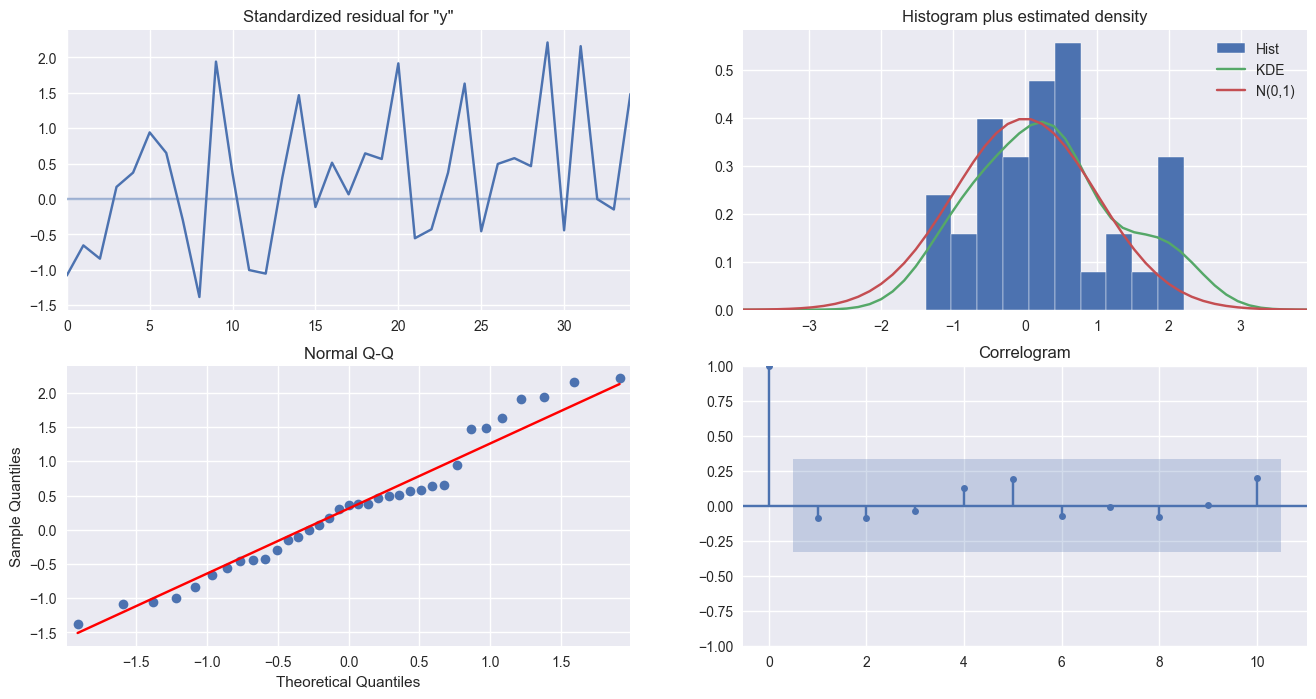

In [3]:
Ntest = 5
dfXY = df_shampoo
print('dfXY')
display(dfXY.head())

swin_params = {
    "Ntest":Ntest,
    "Nlags": 5,
    "minmax" :(0,None)}  

cm_parameters = {
    "model":"arima",
    "order":(2,1,0)
}

y = "Sales"
sf_arima = sf.sforecast(y = y, model=None,model_type="cm", cm_parameters=cm_parameters,
                    swin_parameters=swin_params,)

df_pred_arima = sf_arima.fit(dfXY)

print(f'\nmetrics = {sf_arima.metrics}')
dfXY_pred_arima = dfXY.join(df_pred_arima)
display(dfXY_pred_arima.tail(Ntest))

print(sf_arima.model_fit.summary())

sf_arima.model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

plot observations and predictions with beautifulplots.lineplot

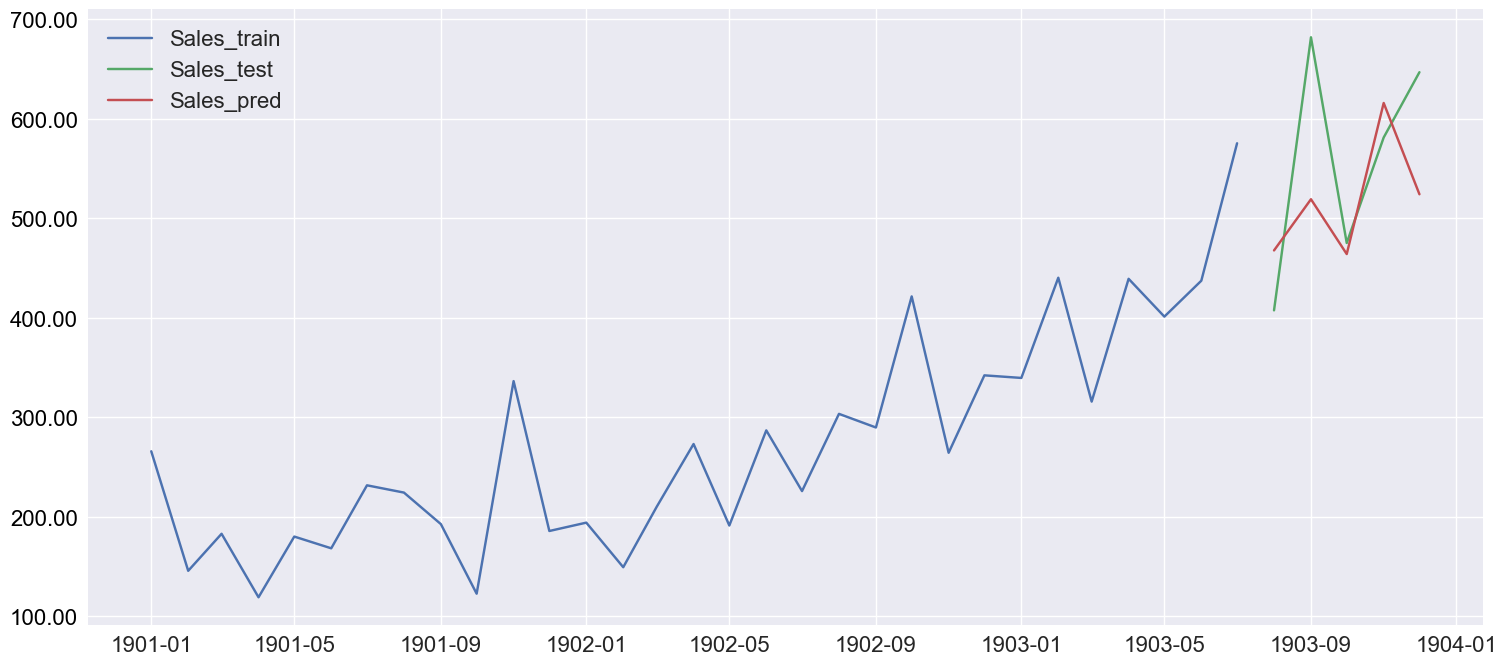

In [5]:
y =  "Sales" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"

bp.lineplot(dfXY_pred_arima, x= "Month", y=[ytrain, ytest , ypred] , figsize=(18,8))

Predict - based on the previously fitted model

In [6]:

ts_period = pd.DateOffset(months=1)
df_pred=sf_arima.predict(Nperiods=1,ts_period=ts_period)
df_pred

Sales_pred
36  559.074667

direct use of ARIMA for comparison (1 period forward forecast)

In [7]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(dfXY['Sales'], order=(2,1,0)) 
model_fit = model.fit()
y_pred=model_fit.forecast().values[0]
print("\ny_pred =",y_pred)



y_pred = 559.074666720351


### SARIMAX

load data

Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121

rows with NA


Empty DataFrame
Columns: [Passengers]
Index: []

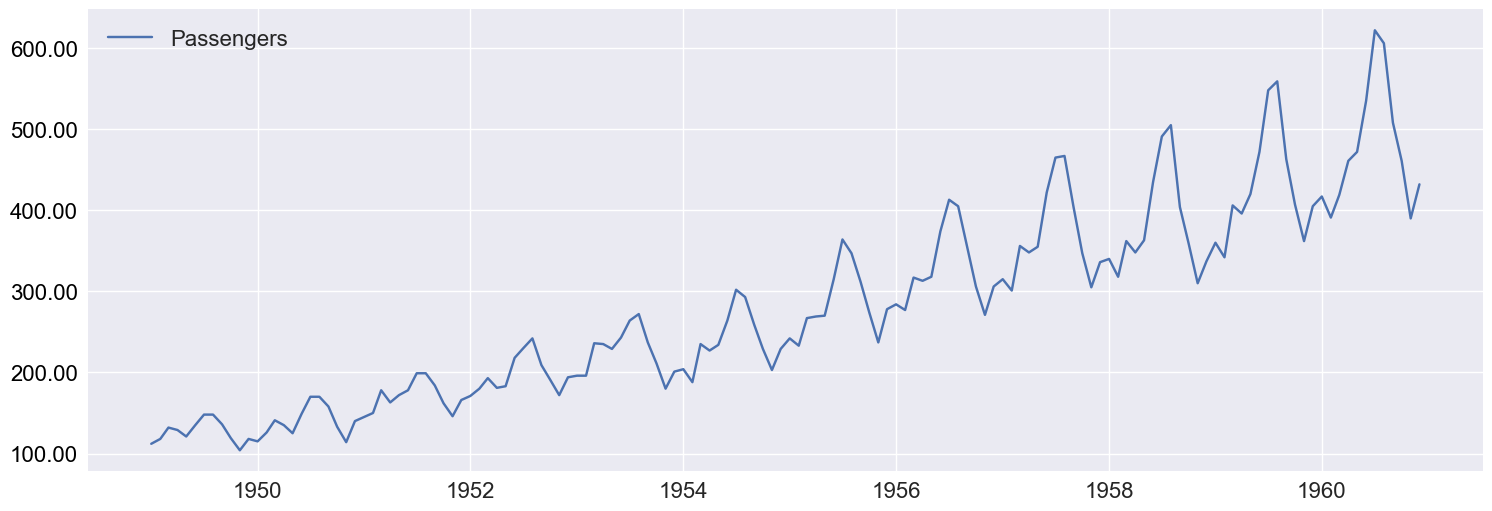

In [8]:
#data
#https://www.kaggle.com/datasets/rakannimer/air-passengers?resource=download

df_airp = pd.read_csv(f'{datapath}/AirPassengers.csv', parse_dates = ["Month"]).set_index("Month")
display(df_airp.head())

# rows with NA
print("rows with NA")
display(df_airp[df_airp.isna().any(axis=1)])

bp.lineplot(df_airp.reset_index(), x="Month", y=["Passengers"], figsize=(18,6))

**Sarimax w/o exogenous or endogenous/derived variables**

dfXY


Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


metrics = {'Passengers_pred': {'RMSE': 17.690164235121294, 'MAE': 16.266054804453347}}


Passengers  Passengers_train  Passengers_test  Passengers_pred  \
Month                                                                        
1960-08-01         606             606.0              NaN              NaN   
1960-09-01         508             508.0              NaN              NaN   
1960-10-01         461             461.0              NaN              NaN   
1960-11-01         390               NaN            390.0       413.220001   
1960-12-01         432               NaN            432.0       441.312108   

            Passengers_pred_error  Passengers_pred_lower  \
Month                                                      
1960-08-01                    NaN                    NaN   
1960-09-01                    NaN                    NaN   
1960-10-01                    NaN                    NaN   
1960-11-01              23.220001             423.922899   
1960-12-01               9.312108             452.015006   

            Passengers_pred_upper  
Month                              
1960-08-01                    NaN  
1960-09-01                    NaN  
1960-10-01                    NaN  
1960-11-01             435.049213  
1960-12-01             463.141320

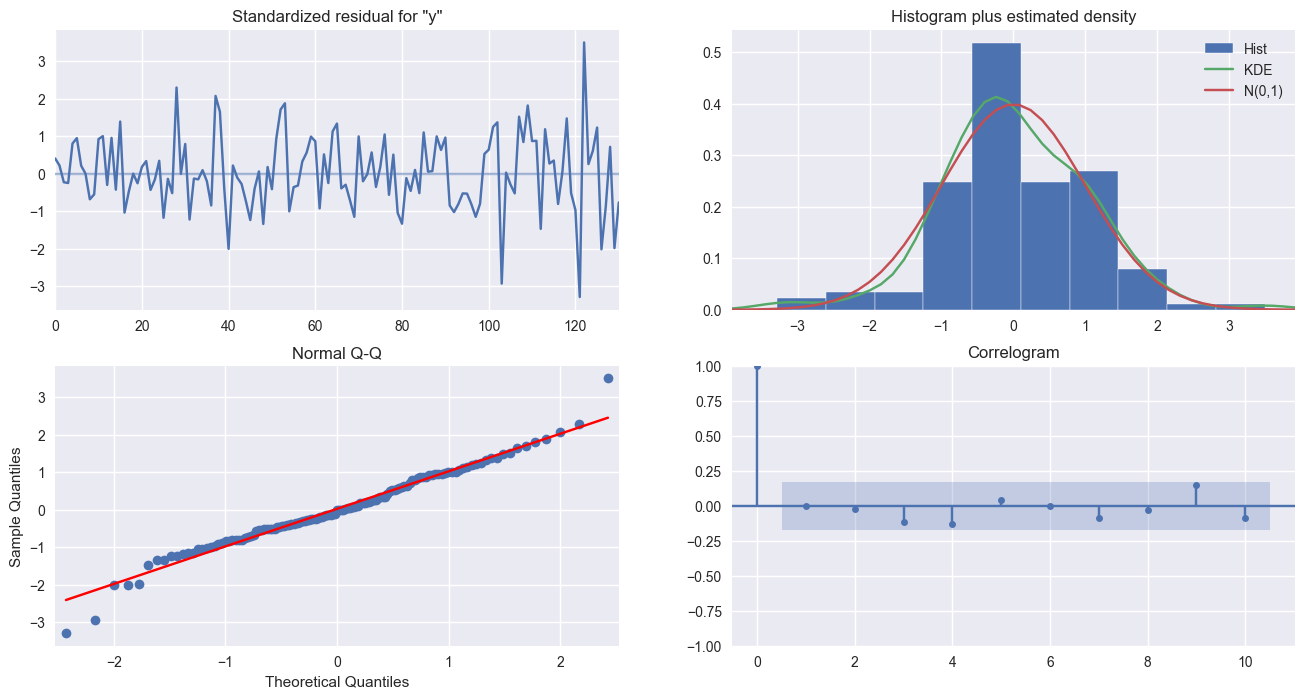

In [9]:

Ntest=2
dfXY = df_airp[["Passengers"]]
print('dfXY')
display(dfXY.head())

swin_parameters = {
    "Ntest":Ntest,
    "Nlags":5,
    "minmax" :(0,None),
    "Nhorizon":1,
    }

cm_parameters = {
    "model":"sarimax",
    "order":(2,1,0),
    "seasonal_order":(0,1,0,12)
    }

y = "Passengers"
sf_sarimax = sf.sforecast(y = y, model=None, model_type="cm", cm_parameters=cm_parameters,
                    swin_parameters=swin_parameters,)

df_pred_sarimax = sf_sarimax.fit(dfXY)

print(f'\nmetrics = {sf_sarimax.metrics}')
dfXY_pred_sarimax = dfXY.join(df_pred_sarimax)
display(dfXY_pred_sarimax.tail())

sf_sarimax.model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()


**Predict Sarimax no exogs**

In [10]:
ts_period = pd.DateOffset(months=1)
df_pred=sf_sarimax.predict(Nperiods=1,ts_period=ts_period)
df_pred

Passengers_pred
1961-01-01       444.327801

**Exogenous Variables**

These variables are not dependent and are ususally some form of external varialbe. For example, they could represent the weather, such as temperature or rain, or economic data, such as consumer confience index.

The variables are included in the input dataframe to the fit operation. An exogenous variables dataframe, one row per predict period (i.e., index), is input to the predict operation.

Below is trivial example of exogenous variables, the month number is included as an exogenous variable input. df_airp has two variables the target variable and y = Passengers, and exogenous variable month_no

In [11]:
# add exogenous variable "month_no"
# df_airp has two variables the target variable y = Passengers, 
# and exogenous variable month_no

dfXY = df_airp.copy()

# Exogenous variables
dfXY["month_no"] = dfXY.index.month # exog variable

display(dfXY)

Passengers  month_no
Month                           
1949-01-01         112         1
1949-02-01         118         2
1949-03-01         132         3
1949-04-01         129         4
1949-05-01         121         5
...                ...       ...
1960-08-01         606         8
1960-09-01         508         9
1960-10-01         461        10
1960-11-01         390        11
1960-12-01         432        12

[144 rows x 2 columns]

**Saramax w/ Exogs**

Passengers  month_no
Month                           
1949-01-01         112         1
1949-02-01         118         2
1949-03-01         132         3
1949-04-01         129         4
1949-05-01         121         5


metrics = {'Passengers_pred': {'RMSE': 15.309241439681522, 'MAE': 13.773480924095225}}


Passengers  month_no  Passengers_train  Passengers_test  \
Month                                                                 
1960-08-01         606         8             606.0              NaN   
1960-09-01         508         9             508.0              NaN   
1960-10-01         461        10               NaN            461.0   
1960-11-01         390        11               NaN            390.0   
1960-12-01         432        12               NaN            432.0   

            Passengers_pred  Passengers_pred_error  Passengers_pred_lower  \
Month                                                                       
1960-08-01              NaN                    NaN                    NaN   
1960-09-01              NaN                    NaN                    NaN   
1960-10-01       452.211667              -8.788333             447.043422   
1960-11-01       413.220001              23.220001             408.051756   
1960-12-01       441.312108               9.312108             436.143863   

            Passengers_pred_upper  
Month                              
1960-08-01                    NaN  
1960-09-01                    NaN  
1960-10-01             472.650089  
1960-11-01             433.658424  
1960-12-01             461.750531

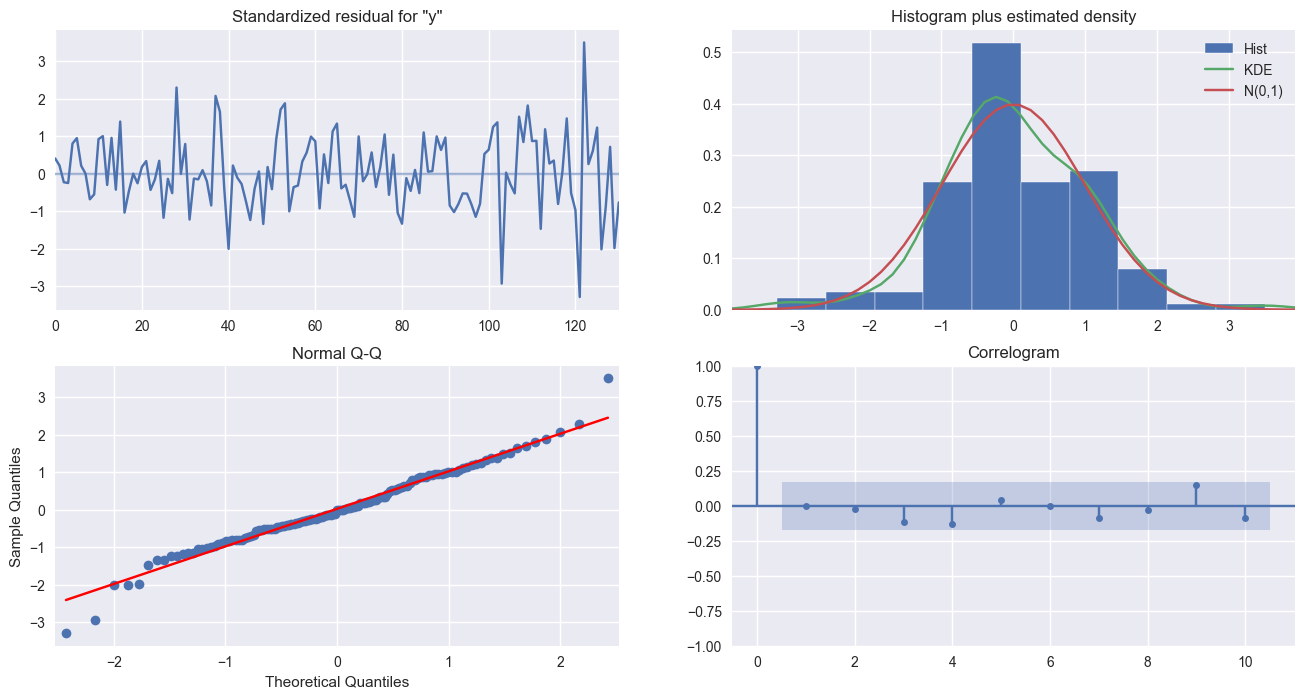

In [12]:
Ntest = 3
display(dfXY.head())

exogvars = ["month_no"]

swin_parameters = {
    "Ntest":Ntest,
    "Nlags":5,
    "minmax" :(0,None),
    "Nhorizon":1,
    "exogvars": exogvars
    }

cm_parameters = {
    "model":"sarimax",
    "order":(2,1,0),
    "seasonal_order":(0,1,0,12)
    }

y = "Passengers"
sf_sarimax = sf.sforecast(y = y, model=None, model_type="cm", cm_parameters=cm_parameters,
                    swin_parameters=swin_parameters,)

df_pred_sarimax = sf_sarimax.fit(dfXY)

print(f'\nmetrics = {sf_sarimax.metrics}')
dfXY_pred_sarimax = dfXY.join(df_pred_sarimax)
display(dfXY_pred_sarimax.tail())

sf_sarimax.model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

**predict sarimax w/ exogs**

In [13]:
ts_period = pd.DateOffset(months=1)
dfexogs = pd.DataFrame(data={"month_no":[1]})
df_pred=sf_sarimax.predict(Nperiods=1,dfexogs = dfexogs, ts_period=ts_period)
df_pred

Passengers_pred
1961-01-01       444.327802

**Endogenous Variables**  
  
Derived variables transform. This transform is applied to generate variables from the past dependent variables. Thus, the derived variables are dependent (i.e., "engogenous").
  
These are variables derived from past targget variables (Passengers). They will be derived prior to each forecast.

In summary, it works as follws. Before each prediction, take the output from the previous prediction and update the dataframe. Then create a new set of derived variables. 

In this case, the below transform employs a rolling function (window = Nr past rows) to create mean and standard deviation variables. Since in this case the derived variables transform includes rolling window functions then enough past dataframe rows are saved for generation of the derived variables.

After each new prediction, a new row is appended to the dataframe and the last Nr rows are saved for generation of the next set of derived variables.

In [14]:
# derived attributes custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

# pipeline/transformer development
# BaseEstimater ... get_params(), set_params() methods
# TransformerMixin ... fit_transform() method
Nr = 3
class derived_attributes(BaseEstimator,TransformerMixin):
    def __init__(self, Nr = Nr): 
        self.Nr = Nr # slidig/rolling window rows
        self.dfmemory = None
    
    def fit(self,df):
        # ensure dataframe has enough rows
        self.dfmemory = df.tail(self.Nr) if df.index.size > self.Nr else df.index.size
        return self
    
    def transform(self,df=None, Nout=None, dfnewrows=None):
        # if df not spefified then transform on dfmemory
        # add new row(s) ... these will be provided from the predict operation
        if not isinstance(df,pd.DataFrame):
            df = self.dfmemory
            if isinstance(dfnewrows,pd.DataFrame):
                df = pd.concat([df,dfnewrows])
        self.dfmemory = df.tail(self.Nr) 
        Nr=self.Nr
        dfnew=df.copy()
        
        dfnew["Passengers_m1_ravg"+str(Nr)] = dfnew["Passengers_m1"].rolling(window=Nr).mean()  
        dfnew["Passengers_m1_rstd"+str(Nr)] = dfnew["Passengers_m1"].rolling(window=Nr).std()
        # dfnew=dfnew.iloc[Nr:] # do not toss out first Nr rows since they will be NA  this will be managed by sforecast
    
        Nclip = self.Nr
        return dfnew if Nout == None else dfnew.tail(Nout)
    
    def get_Nclip(self): # returns the number of initial rows are desgarded (clipped) for NaN avoidence
        return self.Nr
    
    def get_derived_attribute_names(self):
        Nr = self.Nr
        return [ "Passengers_m1_ravg"+str(Nr), "Passengers_m1_rstd"+str(Nr) ]
        
        
# the variables eill be created by sforecast
# here we test the transform to see what the new variables look like.
Nclip =derived_attributes().get_Nclip()
print("Nclip =",Nclip)

drived_var_transform = derived_attributes()
df_airp_m1 = df_airp.copy()
df_airp_m1["Passengers_m1"] = df_airp["Passengers"].shift(1)
dftest = drived_var_transform.fit_transform(df_airp_m1)
print("dataframe, df_arip, with derived variables")
display(dftest)

print(f'Nr= {Nr} dfmemory 3 rows from dataframe, saved by the transform after first use')
display(drived_var_transform.dfmemory)

Nclip = 3
dataframe, df_arip, with derived variables


Passengers  Passengers_m1  Passengers_m1_ravg3  \
Month                                                        
1949-01-01         112            NaN                  NaN   
1949-02-01         118          112.0                  NaN   
1949-03-01         132          118.0                  NaN   
1949-04-01         129          132.0           120.666667   
1949-05-01         121          129.0           126.333333   
...                ...            ...                  ...   
1960-08-01         606          622.0           543.000000   
1960-09-01         508          606.0           587.666667   
1960-10-01         461          508.0           578.666667   
1960-11-01         390          461.0           525.000000   
1960-12-01         432          390.0           453.000000   

            Passengers_m1_rstd3  
Month                            
1949-01-01                  NaN  
1949-02-01                  NaN  
1949-03-01                  NaN  
1949-04-01            10.263203  
1949-05-01             7.371115  
...                         ...  
1960-08-01            75.319320  
1960-09-01            46.306947  
1960-10-01            61.719797  
1960-11-01            73.979727  
1960-12-01            59.405387  

[144 rows x 4 columns]

Nr= 3 dfmemory 3 rows from dataframe, saved by the transform after first use


Passengers  Passengers_m1
Month                                
1960-10-01         461          508.0
1960-11-01         390          461.0
1960-12-01         432          390.0


df_airp with exogenous variables is input to sforecast

The derived_attributes transform is passed into sforecast with the swin_parameters

The input dataframe does not include endogenous (derived variables). The engogenous will be created during the forecast (fit and predict) operations

dfXY


Passengers  month_no
Month                           
1949-01-01         112         1
1949-02-01         118         2
1949-03-01         132         3
1949-04-01         129         4
1949-05-01         121         5


metrics = {'Passengers_pred': {'RMSE': 17.16374548090822, 'MAE': 15.650663070929204}}


Passengers  month_no  Passengers_train  Passengers_test  \
Month                                                                 
1960-08-01         606         8               NaN            606.0   
1960-09-01         508         9               NaN            508.0   
1960-10-01         461        10               NaN            461.0   
1960-11-01         390        11               NaN            390.0   
1960-12-01         432        12               NaN            432.0   

            Passengers_pred  Passengers_pred_error  Passengers_pred_lower  \
Month                                                                       
1960-08-01       629.985383              23.985383             629.462130   
1960-09-01       517.862159               9.862159             517.338905   
1960-10-01       453.553138              -7.446862             453.029884   
1960-11-01       414.046039              24.046039             413.522785   
1960-12-01       444.912872              12.912872             444.389618   

            Passengers_pred_upper  
Month                              
1960-08-01             654.007160  
1960-09-01             541.883936  
1960-10-01             477.574914  
1960-11-01             438.067815  
1960-12-01             468.934648

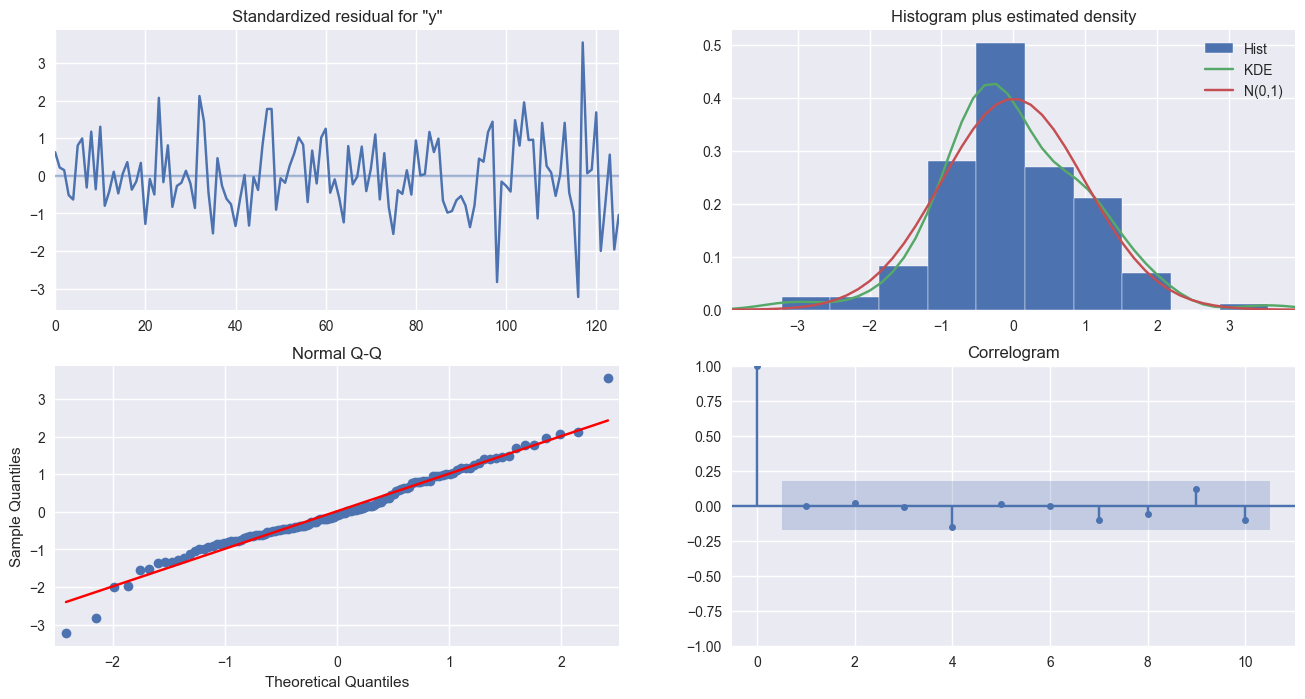

In [15]:
Ntest = 5

dfXY = df_airp.copy()

# Exogenous variables
dfXY["month_no"] = dfXY.index.month # exog variable
print('dfXY')
display(dfXY.head())

exenvars = ["month_no", "Passengers_m1_ravg3","Passengers_m1_rstd3"]
exogvars = ["month_no"]

swin_parameters = {
    "Ntest":Ntest,
    "Nlags":5,
    "minmax" :(0,None),
    "Nhorizon":1,
    "exogvars": exogvars,
    "derived_attributes_transform":derived_attributes
    }

cm_parameters = {
    "model":"sarimax",
    "order":(2,1,0),
    "seasonal_order":(0,1,0,12)
    }

y = "Passengers"
sf_sarimax = sf.sforecast(y = y, model=None, model_type="cm", cm_parameters=cm_parameters,
                    swin_parameters=swin_parameters,)

df_pred_sarimax = sf_sarimax.fit(dfXY)

print(f'\nmetrics = {sf_sarimax.metrics}')
dfXY_pred_sarimax = dfXY.join(df_pred_sarimax)
display(dfXY_pred_sarimax.tail())

sf_sarimax.model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

**Predict sarimax w exogenous and endogenous/derived variables**  
must specify dfexogenous  
also since index is a timestamp, must specify the time series period, s_period

In [17]:

dfexogs = pd.DataFrame(data = {"month_no":[1]})
ts_period = pd.DateOffset(months=1)
df_pred=sf_sarimax.predict(Nperiods=1,dfexogs=dfexogs, ts_period=ts_period)
df_pred

Passengers_pred
1961-01-01       446.107189

**Multiple Univariate Forecats**

Add another passenger. This assumes that the basic statistical properties, ARIMA order and Seasonal orders, are shared by the two variables. The forecast does make use of multivariate information, they are three separate independant univariate forecasts. If the statistics differ between multiple variables then it is better to run multiple sforecast predictions with appropriate input parameters that account for the respective statistical properties. 

dfXY.tail()


Passengers  Passengers2  month_no
Month                                        
1960-08-01         606       761.50         8
1960-09-01         508       659.50         9
1960-10-01         461       588.00        10
1960-11-01         390       505.25        11
1960-12-01         432       529.50        12


metrics = {'Passengers_pred': {'RMSE': 16.74309801335174, 'MAE': 15.244803777810876}, 'Passengers2_pred': {'RMSE': 16.525756205160498, 'MAE': 14.950278558420905}}


Passengers  Passengers2  month_no  Passengers_train  \
Month                                                             
1960-08-01         606       761.50         8               NaN   
1960-09-01         508       659.50         9               NaN   
1960-10-01         461       588.00        10               NaN   
1960-11-01         390       505.25        11               NaN   
1960-12-01         432       529.50        12               NaN   

            Passengers_test  Passengers_pred  Passengers_pred_error  \
Month                                                                 
1960-08-01            606.0       630.137901              24.137901   
1960-09-01            508.0       518.765675              10.765675   
1960-10-01            461.0       452.211667              -8.788333   
1960-11-01            390.0       413.220001              23.220001   
1960-12-01            432.0       441.312108               9.312108   

            Passengers_pred_lower  Passengers_pred_upper  Passengers2_train  \
Month                                                                         
1960-08-01             628.589745             653.908643                NaN   
1960-09-01             517.217518             542.536416                NaN   
1960-10-01             450.663510             475.982408                NaN   
1960-11-01             411.671845             436.990743                NaN   
1960-12-01             439.763952             465.082850                NaN   

            Passengers2_test  Passengers2_pred  Passengers2_pred_error  \
Month                                                                    
1960-08-01            761.50        785.191671               23.691671   
1960-09-01            659.50        670.054853               10.554853   
1960-10-01            588.00        580.029964               -7.970036   
1960-11-01            505.25        528.589324               23.339324   
1960-12-01            529.50        538.695510                9.195510   

            Passengers2_pred_lower  Passengers2_pred_upper  
Month                                                       
1960-08-01              784.087854              808.742403  
1960-09-01              668.951035              693.605585  
1960-10-01              578.926147              603.580697  
1960-11-01              527.485506              552.140056  
1960-12-01              537.591693              562.246242

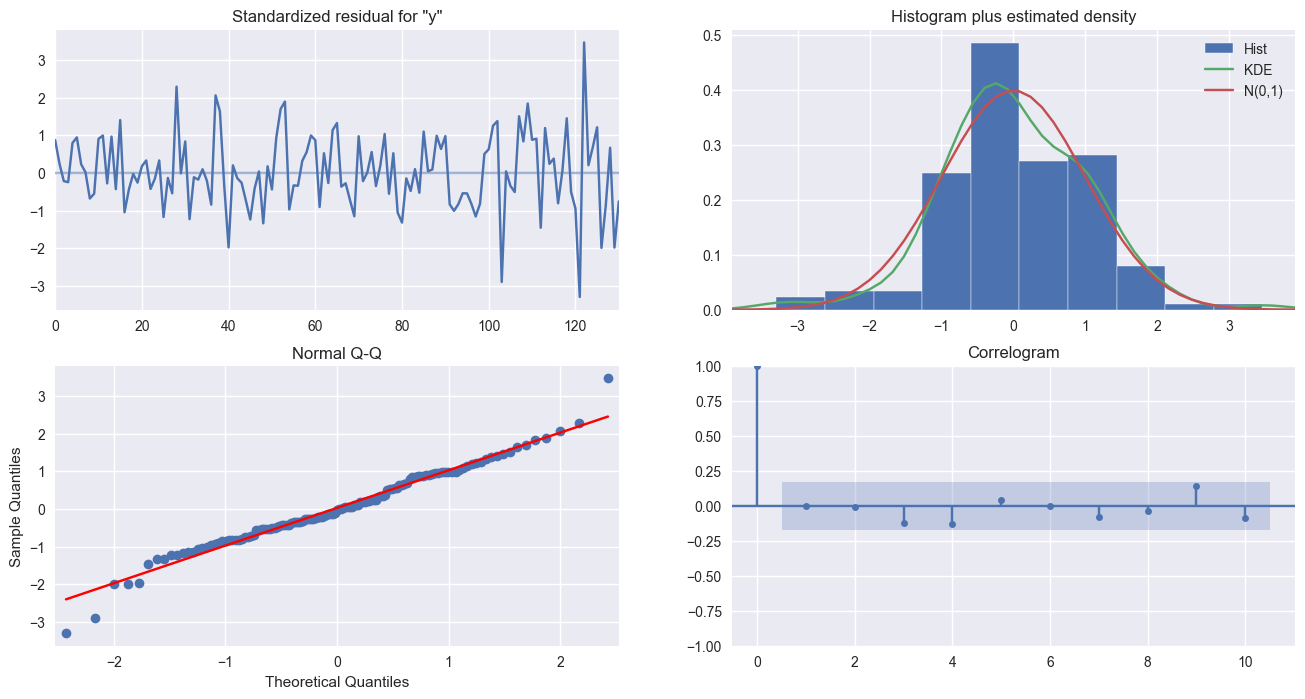

In [18]:
dfXY = df_airp.copy()
# Passengers 2 exponential smooth and scaled
a = 0.2
dfXY["Passengers2"]= 1.25*((1-a)*dfXY["Passengers"] + a* (dfXY["Passengers"].shift(1)) )
dfXY["Passengers2"] = dfXY["Passengers2"].bfill()

Ntest = 5

# Exogenous variables
dfXY["month_no"] = dfXY.index.month # exog variable
print('dfXY.tail()')

display(dfXY.tail())

exogvars = ["month_no"]

swin_parameters = {
    "Ntest":Ntest,
    "Nlags":5,
    "minmax" :(0,None),
    "Nhorizon":1,
    "exogvars": exogvars,
    }

cm_parameters = {
    "model":"sarimax",
    "order":(2,1,0),
    "seasonal_order":(0,1,0,12)
    }

y = ["Passengers", "Passengers2"]
sf_sarimax = sf.sforecast(y = y, model=None, model_type="cm", cm_parameters=cm_parameters,
                    swin_parameters=swin_parameters,)

df_pred_sarimax = sf_sarimax.fit(dfXY)

print(f'\nmetrics = {sf_sarimax.metrics}')
dfXY_pred_sarimax = dfXY.join(df_pred_sarimax)
display(dfXY_pred_sarimax.tail())

sf_sarimax.model_fit["Passengers2"].plot_diagnostics(figsize=(16, 8))
plt.show()

**Predict multiple outputs (1-step)**

In [19]:
dfexogs = pd.DataFrame(data = {"month_no":[1]})
ts_period = pd.DateOffset(months=1)
df_pred=sf_sarimax.predict(Nperiods=1,dfexogs=dfexogs, ts_period=ts_period)
df_pred

Passengers_pred  Passengers2_pred
1961-01-01       444.327802        552.827532

direct use of SARIMAX for comparision. 1 period forward forecast

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
y = "Passengers"

exens = ["month_no","Passengers_m1_ravg3","Passengers_m1_rstd3"]
make_derived_attributes = derived_attributes()
dfXY2 = dfXY.copy()
dfXY2["Passengers_m1"]= dfXY2["Passengers"].shift(1) # derived variables needs the lagged output y(-1) = Passengers_m1
dfXY2=make_derived_attributes.fit_transform(dfXY2)
dfXY2=dfXY2.iloc[5:]
display(dfXY2.head())

sarima_model=SARIMAX(dfXY2.iloc[:-1][y].values, exog = dfXY2.iloc[:-1][exens].values, order=(1, 1, 0), seasonal_order=(0, 1, 0, 12),
                    enforce_stationarity=False, enforce_invertibility=False)

sarima_model_fit = sarima_model.fit(disp=False)
y_pred = sarima_model_fit.forecast(exog=dfXY2[exens].tail(1).values)[0]   # note, derived variables (i.e., exogs / endogenous ) not updated
print("y_pred =",y_pred)
#print("y_actual =",dfXY2.tail(1)[y].values[0])

Passengers  Passengers2  month_no  Passengers_m1  \
Month                                                          
1949-06-01         135       165.25         6          121.0   
1949-07-01         148       181.75         7          135.0   
1949-08-01         148       185.00         8          148.0   
1949-09-01         136       173.00         9          148.0   
1949-10-01         119       153.00        10          136.0   

            Passengers_m1_ravg3  Passengers_m1_rstd3  
Month                                                 
1949-06-01           127.333333             5.686241  
1949-07-01           128.333333             7.023769  
1949-08-01           134.666667            13.503086  
1949-09-01           143.666667             7.505553  
1949-10-01           144.000000             6.928203

y_pred = 445.0213136581503


### Auto ARIMA

exenvars = None ... without exogvars and without derived attributes

In [21]:
Ntest = 4
Nhorizon = 2
dfXY = df_airp
print("dfXY.index.size = ", dfXY.index.size)
print('dfXY.tail()')
display(dfXY.tail())


swin_params = {
    "Ntest":Ntest,
    "Nlags":5,
    "Nhorizon": Nhorizon,
    "minmax" :(0,None)
    }  

cm_parameters = {
    "model":"auto_arima",
    "d":None, # let the auto search determine d
    "start_p":1,
    "start_q":1,
    "seasonal":True ,
    "D":None, # let auto search determine D
    "m":12, # 12, period (i.e., month) seasonality period
    "start_P":1,
    "start_Q":1,
    "error_action":"ignore", # don't want to know if order does not work
    "suppress_warnings":True, # don't want convergence warnings
    "stepwise":True # stepwise search
}

y = "Passengers"
sf_autoarima = sf.sforecast(y = y, model=None, model_type="cm", cm_parameters=cm_parameters,
                    swin_parameters=swin_params,)

df_pred_autoarima = sf_autoarima.fit(dfXY)

print(f'\nmetrics = {sf_autoarima.metrics}')

print("confidence intervals = ",sf_autoarima.ci )
dfXY_pred_autoarima = dfXY.join(df_pred_autoarima)
display(dfXY_pred_autoarima.tail())


dfXY.index.size =  144
dfXY.tail()


Passengers
Month                 
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=999.041, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=988.030, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=988.606, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=987.497, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=988.367, Time=0.08 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=989.465, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=989.427, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=987.923, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=985.987, Time=0.15 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=986.643, Time=0.32 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=986.912, Time=0.28 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(3,1,1)(0,1,0)[12]             : AIC=98

Passengers  Passengers_train  Passengers_test  Passengers_pred  \
Month                                                                        
1960-08-01         606             606.0              NaN              NaN   
1960-09-01         508               NaN            508.0       514.690165   
1960-10-01         461               NaN            461.0       455.350909   
1960-11-01         390               NaN            390.0       414.046232   
1960-12-01         432               NaN            432.0       457.046232   

            Passengers_pred_error  Passengers_pred_lower  \
Month                                                      
1960-08-01                    NaN                    NaN   
1960-09-01               6.690165             523.115937   
1960-10-01              -5.649091             452.771351   
1960-11-01              24.046232             422.472004   
1960-12-01              25.046232             454.466674   

            Passengers_pred_upper  
Month                              
1960-08-01                    NaN  
1960-09-01             537.000791  
1960-10-01             477.327609  
1960-11-01             436.356857  
1960-12-01             479.022932

**predict autoarima**

In [22]:

ts_period = pd.DateOffset(months=1)
df_pred=sf_autoarima.predict(Nperiods=3, ts_period=ts_period)
df_pred

Passengers_pred
1961-01-01       451.347076
1961-02-01       427.102222
1961-03-01       463.382490

**autoarima fit with exogenous variables, Nhorizon = 3**

In [23]:
Ntest = 3
Nhorizon = 3
dfXY = df_airp.copy()

# Exogenous variables
dfXY["month_no"] = dfXY.index.month # exog variable

print('dfXY')
display(dfXY.head())

exogvars = ["month_no"]

swin_params = {
    "Ntest":Ntest,
    "Nlags":5,
    "Nhorizon":Nhorizon,
    "minmax" :(0,None),
    "exogvars": exogvars,
    }  

cm_parameters = {
    "model":"auto_arima",
    "d":None, # let the auto search determine d
    "start_p":1,
    "start_q":1,
    "seasonal":True ,
    "D":None, # let auto search determine D
    "m":12, # 12, period (i.e., month) seasonality period
    "start_P":1,
    "start_Q":1,
    "error_action":"ignore", # don't want to know if order does not work
    "suppress_warnings":True, # don't want convergence warnings
    "stepwise":True # stepwise search
}

y = "Passengers"
sf_autoarima = sf.sforecast(y = y, model=None, model_type="cm", cm_parameters=cm_parameters,
                    swin_parameters=swin_params,)

df_pred_autoarima = sf_autoarima.fit(dfXY)

print(f'\nmetrics = {sf_autoarima.metrics}')

dfXY_pred_autoarima = dfXY.join(df_pred_autoarima)
display(dfXY_pred_autoarima.tail())

dfXY


Passengers  month_no
Month                           
1949-01-01         112         1
1949-02-01         118         2
1949-03-01         132         3
1949-04-01         129         4
1949-05-01         121         5

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.06 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1005.914, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=995.467, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=995.933, Time=0.15 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=995.060, Time=0.04 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=995.871, Time=0.22 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=997.033, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=996.991, Time=0.05 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=995.306, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=993.005, Time=0.20 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=993.546, Time=0.55 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=993.857, Time=0.62 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(3,1,1)(0,1,0)[12]             : AIC=9

Passengers  month_no  Passengers_train  Passengers_test  \
Month                                                                 
1960-08-01         606         8             606.0              NaN   
1960-09-01         508         9             508.0              NaN   
1960-10-01         461        10               NaN            461.0   
1960-11-01         390        11               NaN            390.0   
1960-12-01         432        12               NaN            432.0   

            Passengers_pred  Passengers_pred_error  Passengers_pred_lower  \
Month                                                                       
1960-08-01              NaN                    NaN                    NaN   
1960-09-01              NaN                    NaN                    NaN   
1960-10-01       451.130222              -9.869778             441.260444   
1960-11-01       405.185239              15.185239             420.370478   
1960-12-01       447.437675              15.437675             462.875350   

            Passengers_pred_upper  
Month                              
1960-08-01                    NaN  
1960-09-01                    NaN  
1960-10-01             441.260444  
1960-11-01             420.370478  
1960-12-01             462.875350

**autoarima predict with exogvars**

In [24]:

dfexogs = pd.DataFrame(data = {"month_no":[1,2,3,4,5]})
print("dfexogs")
display(dfexogs)
ts_period = pd.DateOffset(months=1)
df_pred=sf_autoarima.predict(Nperiods=5,dfexogs=dfexogs, ts_period=ts_period)
df_pred

dfexogs


month_no
0         1
1         2
2         3
3         4
4         5

Passengers_pred
1961-01-01       451.347076
1961-02-01       427.102222
1961-03-01       463.382490
1961-04-01       499.705770
1961-05-01       514.035525

**autoarima fit with exogenous and endogenous (derived) variables**

In [25]:
Ntest = 2
Nhorizon = 1
dfXY = df_airp.copy()
# Exogenous variables
dfXY["month_no"] = dfXY.index.month # exog variable

print('dfXY')
display(dfXY.head())

exenvars = ["month_no", "Passengers_m1_ravg3","Passengers_m1_rstd3"]
exogvars = ["month_no"]

swin_params = {
    "Ntest":Ntest,
    "Nlags":5,
    "Nhorizon":Nhorizon,
    "minmax" :(0,None),
    "exogvars": exogvars,
    "derived_attributes_transform":derived_attributes
    }  

cm_parameters = {
    "model":"auto_arima",
    "d":None, # let the auto search determine d
    "start_p":1,
    "start_q":1,
    "seasonal":True ,
    "D":None, # let auto search determine D
    "m":12, # 12, period (i.e., month) seasonality period
    "start_P":1,
    "start_Q":1,
    "error_action":"ignore", # don't want to know if order does not work
    "suppress_warnings":True, # don't want convergence warnings
    "stepwise":True # stepwise search
}

y = "Passengers"
sf_autoarima = sf.sforecast(y = y, model=None, model_type="cm", cm_parameters=cm_parameters,
                    swin_parameters=swin_params,)

df_pred_autoarima = sf_autoarima.fit(dfXY)

print(f'\nmetrics = {sf_autoarima.metrics}')

print("confidence intervals = ",sf_autoarima.ci )
dfXY_pred_autoarima = dfXY.join(df_pred_autoarima)
display(dfXY_pred_autoarima.tail())

dfXY


Passengers  month_no
Month                           
1949-01-01         112         1
1949-02-01         118         2
1949-03-01         132         3
1949-04-01         129         4
1949-05-01         121         5

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.85 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=978.102, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=967.747, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=967.946, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=967.102, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=968.074, Time=0.09 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=969.102, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=969.102, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=967.131, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=964.570, Time=0.11 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=965.398, Time=0.36 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=965.622, Time=0.46 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=inf, Time=0.95 sec
 ARIMA(3,1,1)(0,1,0)[12]             : AIC=96

Passengers  month_no  Passengers_train  Passengers_test  \
Month                                                                 
1960-08-01         606         8             606.0              NaN   
1960-09-01         508         9             508.0              NaN   
1960-10-01         461        10             461.0              NaN   
1960-11-01         390        11               NaN            390.0   
1960-12-01         432        12               NaN            432.0   

            Passengers_pred  Passengers_pred_error  Passengers_pred_lower  \
Month                                                                       
1960-08-01              NaN                    NaN                    NaN   
1960-09-01              NaN                    NaN                    NaN   
1960-10-01              NaN                    NaN                    NaN   
1960-11-01       410.903505              20.903505             420.313308   
1960-12-01       440.132725               8.132725             449.542529   

            Passengers_pred_upper  
Month                              
1960-08-01                    NaN  
1960-09-01                    NaN  
1960-10-01                    NaN  
1960-11-01             430.529931  
1960-12-01             459.759152

**autoarima predict w exogenous and endogenous variables**

In [26]:
dfexogs = pd.DataFrame(data = {"month_no":[1]})

ts_period = pd.DateOffset(months=1)
df_pred=sf_autoarima.predict(Nperiods=1,dfexogs=dfexogs, ts_period=ts_period)
df_pred

Passengers_pred
1961-01-01       444.313732

**multiple pdarima univariate forecast w/ exogenous and endogenous variabless**

In [27]:
Ntest = 2
Nhorizon = 1
dfXY = df_airp.copy()

# Passengers 2 exponential smooth and scale
a = 0.2
dfXY["Passengers2"]= 1.25*((1-a)*dfXY["Passengers"] + a* (dfXY["Passengers"].shift(1)) )
dfXY["Passengers2"] = dfXY["Passengers2"].bfill()

# Exogenous variables
dfXY["month_no"] = dfXY.index.month # exog variable

print('dfXY')
display(dfXY.tail())


exogvars = ["month_no"]

swin_params = {
    "Ntest":Ntest,
    "Nlags":5,
    "Nhorizon":Nhorizon,
    "minmax" :(0,None),
    "exogvars": exogvars,
    "derived_attributes_transform":derived_attributes
    }  

cm_parameters = {
    "model":"auto_arima",
    "d":None, # let the auto search determine d
    "start_p":1,
    "start_q":1,
    "seasonal":True ,
    "D":None, # let auto search determine D
    "m":12, # 12, period (i.e., month) seasonality period
    "start_P":1,
    "start_Q":1,
    "error_action":"ignore", # don't want to know if order does not work
    "suppress_warnings":True, # don't want convergence warnings
    "stepwise":True # stepwise search
}

y = ["Passengers", "Passengers2"]
sf_autoarima = sf.sforecast(y = y, model=None, model_type="cm", cm_parameters=cm_parameters,
                    swin_parameters=swin_params,)

df_pred_autoarima = sf_autoarima.fit(dfXY)

print(f'\nmetrics = {sf_autoarima.metrics}')

dfXY_pred_autoarima = dfXY.join(df_pred_autoarima)
display(dfXY_pred_autoarima.tail())

dfXY


Passengers  Passengers2  month_no
Month                                        
1960-08-01         606       761.50         8
1960-09-01         508       659.50         9
1960-10-01         461       588.00        10
1960-11-01         390       505.25        11
1960-12-01         432       529.50        12

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.92 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=978.102, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=967.747, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=967.946, Time=0.15 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=967.102, Time=0.03 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=968.074, Time=0.11 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=969.102, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=969.102, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=967.131, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=964.570, Time=0.18 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=965.398, Time=0.45 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=965.622, Time=0.40 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=inf, Time=0.96 sec
 ARIMA(3,1,1)(0,1,0)[12]             : AIC=96

Passengers  Passengers2  month_no  Passengers_train  \
Month                                                             
1960-08-01         606       761.50         8             606.0   
1960-09-01         508       659.50         9             508.0   
1960-10-01         461       588.00        10             461.0   
1960-11-01         390       505.25        11               NaN   
1960-12-01         432       529.50        12               NaN   

            Passengers_test  Passengers_pred  Passengers_pred_error  \
Month                                                                 
1960-08-01              NaN              NaN                    NaN   
1960-09-01              NaN              NaN                    NaN   
1960-10-01              NaN              NaN                    NaN   
1960-11-01            390.0       410.903505              20.903505   
1960-12-01            432.0       440.132725               8.132725   

            Passengers_pred_lower  Passengers_pred_upper  Passengers2_train  \
Month                                                                         
1960-08-01                    NaN                    NaN              761.5   
1960-09-01                    NaN                    NaN              659.5   
1960-10-01                    NaN                    NaN              588.0   
1960-11-01             420.313308             430.529931                NaN   
1960-12-01             449.542529             459.759152                NaN   

            Passengers2_test  Passengers2_pred  Passengers2_pred_error  \
Month                                                                    
1960-08-01               NaN               NaN                     NaN   
1960-09-01               NaN               NaN                     NaN   
1960-10-01               NaN               NaN                     NaN   
1960-11-01            505.25         526.29444                21.04444   
1960-12-01            529.50         537.00000                 7.50000   

            Passengers2_pred_lower  Passengers2_pred_upper  
Month                                                       
1960-08-01                     NaN                     NaN  
1960-09-01                     NaN                     NaN  
1960-10-01                     NaN                     NaN  
1960-11-01              535.148884              545.984436  
1960-12-01              545.854444              556.689996

**predict multiple univariate pdarima**

In [28]:
dfexogs = pd.DataFrame(data = {"month_no":[1]})
ts_period = pd.DateOffset(months=1)
df_pred=sf_autoarima.predict(Nperiods=1,dfexogs=dfexogs, ts_period=ts_period)
df_pred

Passengers_pred  Passengers2_pred
1961-01-01       444.313732        553.432021

**autoarima: direct use of auto_arima for comparison**

In [29]:
# autoarima tutorial references
# https://alkaline-ml.com/pmdarima/1.3.0/tips_and_tricks.html
# https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd

# note that dfXY index is month so autoarima figures out the indexes corresponding to the forecasted horizon

import pmdarima as pm

Ntest = 3

y=["Passengers"]
exog_vars = ["Passengers_m1_ravg3","Passengers_m1_rstd3","month_no"]


exens = ["month_no","Passengers_m1_ravg3","Passengers_m1_rstd3"]
make_derived_attributes = derived_attributes()
dfXY2 = dfXY.copy()
dfXY2["Passengers_m1"]= dfXY2["Passengers"].shift(1) # derived variables needs the lagged output y(-1) = Passengers_m1
dfXY2=make_derived_attributes.fit_transform(dfXY2)
dfXY2=dfXY2.iloc[5:]
display(dfXY2.head())

arima_model = pm.auto_arima(dfXY2.iloc[:-Ntest][y], exogenous = dfXY2.iloc[:-Ntest][exog_vars] , 
                         start_p=1, start_q=1, d=None,
                         test = "adf", # test ADF (augmented Dickey-Fuller) for stationarity
                         #max_p=5, max_q=5, 
                         max_q=None,
                         seasonal=True, #set to seasonal 
                         #start_P=0, start_Q=1,
                         start_Q=0,
                         max_Q=None,
                         m=12, # frequncy of the cycle 12 months
                         D=None, #order of the seasonal differencing ... will be estimated when seasonality = True
                         trace=True,   # print model AIC 
                         error_action='ignore',  # don't want to know if an order does not work
                         suppress_warnings=True, # don't want convergence warnings
                         stepwise=True # stepwise search
                                                      )
arima_model.fit(dfXY2.iloc[:-Ntest][y], exogenous = dfXY2.iloc[:-Ntest][exog_vars])

n_periods = 3
ypred=arima_model.predict(n_periods,dfXY2.tail(Ntest)[exog_vars])


display(ypred)

Passengers  Passengers2  month_no  Passengers_m1  \
Month                                                          
1949-06-01         135       165.25         6          121.0   
1949-07-01         148       181.75         7          135.0   
1949-08-01         148       185.00         8          148.0   
1949-09-01         136       173.00         9          148.0   
1949-10-01         119       153.00        10          136.0   

            Passengers_m1_ravg3  Passengers_m1_rstd3  
Month                                                 
1949-06-01           127.333333             5.686241  
1949-07-01           128.333333             7.023769  
1949-08-01           134.666667            13.503086  
1949-09-01           143.666667             7.505553  
1949-10-01           144.000000             6.928203

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=962.600, Time=0.24 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=970.701, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=960.603, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=960.993, Time=0.12 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=959.828, Time=0.04 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=960.899, Time=0.09 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=961.801, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=961.762, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=960.112, Time=0.04 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=957.064, Time=0.20 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=958.007, Time=0.35 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=958.212, Time=0.44 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(3,1,1)(0,1,0)[12]             : AI

1960-10-01    450.689969
1960-11-01    404.489210
1960-12-01    446.502509
Freq: MS, dtype: float64

## 2. SK Learn Models

### Superstore Data

Often data needs pre-processing in the form of aggregattions and cleansing so that it is suitable for forecasting. The data for these examples is derived from the Superstore dataset avaliable [here](https://community.tableau.com/s/question/0D54T00000CWeX8SAL/sample-superstore-sales-excelxls). In order to not over complicate this notebook we will not demonstrate all the pre-processing here. Howevver, for reference, all the details are contaned in the EDA/pre-procssing notebook  - [pre-processing notebook](https://github.com/Aljgutier/sforecast/blob/main/docs/forecast_EDA_Superstore.ipynb)

Data pre-processing, prior to loading the data (below), include the following steps
* contiguous dates - ensure that there are no missing dates
* the data is aggregated to sub category - the original dateset containes categories, sub-categories, and product ids. Below, we will further aggregate to category.

The output of the preprocesing (i.e., data loaded below) is avaialable in this github repo, [pre-processed data](https://github.com/Aljgutier/sforecast/blob/main/data/Superstore_subcatsales_2017_cdp.csv).

 After loading the data there are two additional steps (shown below) to prepare it for forecasting
 * The data will be aggregated to the three categories (office supplies, technology, furniture)
 * It will be transformed to wide format so that all categories are columns

All these transformations (before and after loading) typify transformations required in real situations.

In [2]:
df_sales = pd.read_csv(f'{datapath}/Superstore_subcatsales_2017_cdp.csv', parse_dates = ["Order Date"])
display(df_sales.head(10))

print(f'date min = {df_sales["Order Date"].min()}')
print(f'date max = {df_sales["Order Date"].max()}')
print(f'N rows (sales) = {df_sales.shape[0]}')
print( f'N Sub-Catetories = {df_sales.groupby("Sub-Category")["Sales"].count().count()} ')

Order Date         Category Sub-Category    Sales  Quantity
0 2014-01-03  Office Supplies        Paper   16.448       2.0
1 2014-01-04  Office Supplies       Labels   11.784       3.0
2 2014-01-04  Office Supplies      Binders    3.540       2.0
3 2014-01-04  Office Supplies        Paper    0.000       0.0
4 2014-01-04  Office Supplies      Storage  272.736       3.0
5 2014-01-05  Office Supplies       Labels    0.000       0.0
6 2014-01-05  Office Supplies      Binders    0.000       0.0
7 2014-01-05  Office Supplies        Paper    0.000       0.0
8 2014-01-05  Office Supplies          Art   19.536       3.0
9 2014-01-05  Office Supplies      Storage    0.000       0.0

date min = 2014-01-03 00:00:00
date max = 2017-12-30 00:00:00
N rows (sales) = 24431
N Sub-Catetories = 17 


Aggregate to Category Time-Series


* aggregate category sales by date
* three categories - office supplies, furniture, technology
* lineplots to observe the timeseries

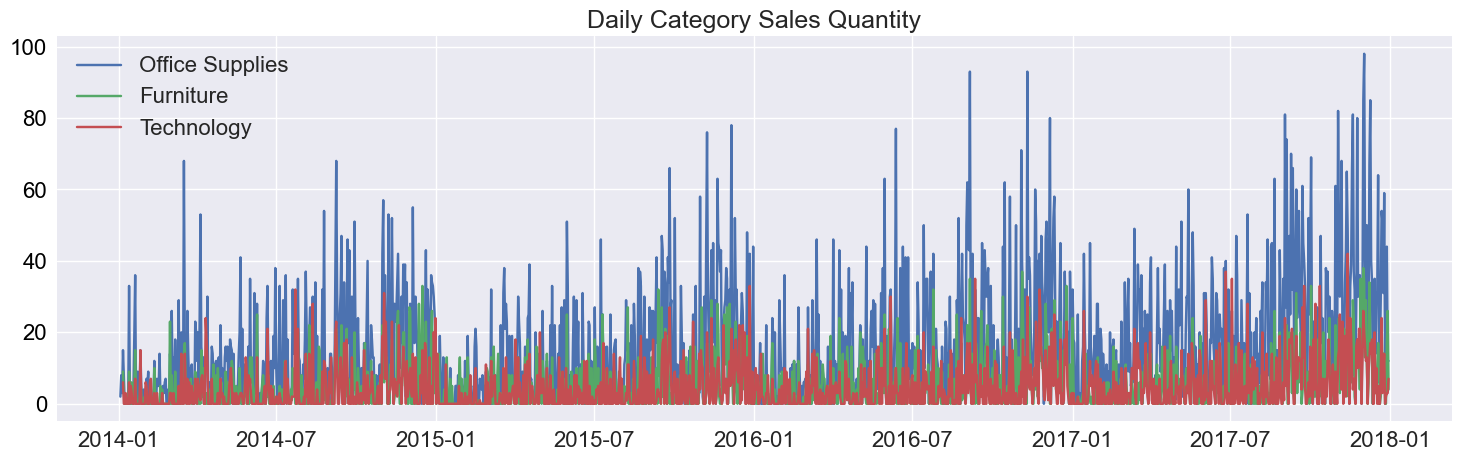

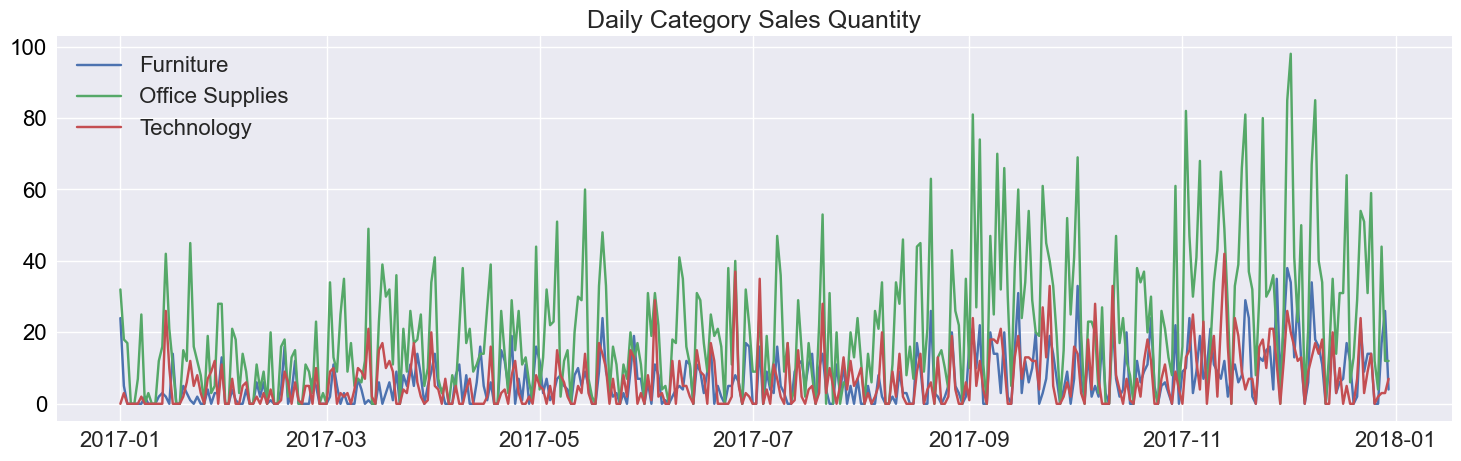

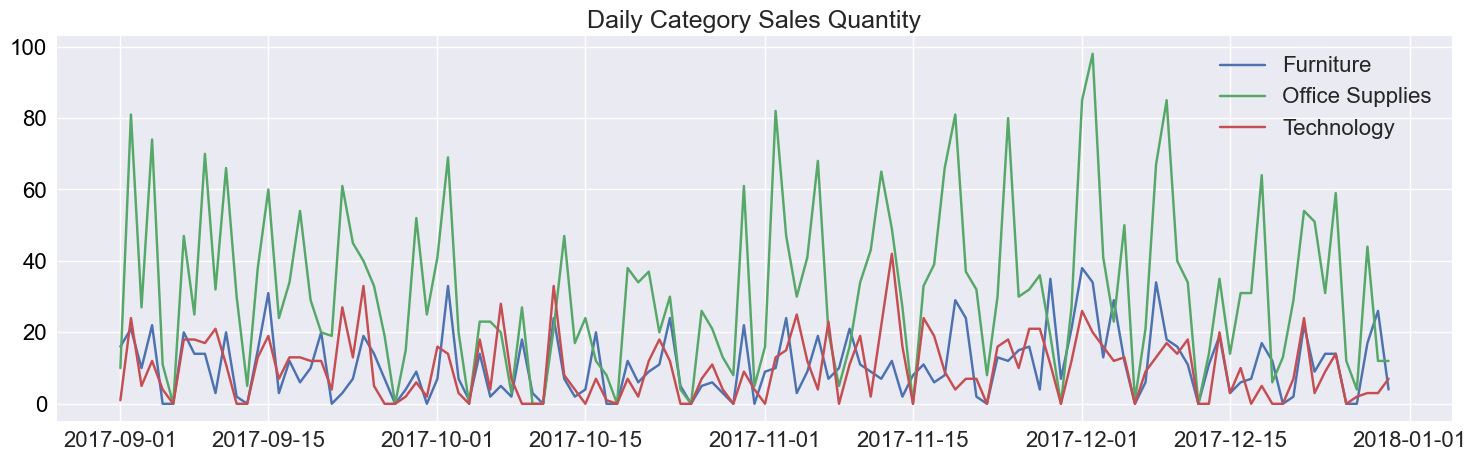

In [3]:
aggs = {
    "Sales":"sum",
    "Quantity":"sum"  
}

df_catsales = df_sales.groupby(["Order Date" , "Category"]).agg(aggs).reset_index()
df_catsales.head(10)

bp.lineplot(df_catsales,"Order Date","Quantity",hue="Category",  y_axis_format = ",.0f" , 
            title = "Daily Category Sales Quantity", figsize=(18,5))

d=datetime(2017,1,1)
bp.lineplot(df_catsales[df_catsales["Order Date"]>=d],"Order Date","Quantity",hue="Category",  y_axis_format = ",.0f" , 
            title = "Daily Category Sales Quantity", figsize=(18,5))

d=datetime(2017,9,1)
bp.lineplot(df_catsales[df_catsales["Order Date"]>=d],"Order Date","Quantity",hue="Category",  y_axis_format = ",.0f" ,
            title = "Daily Category Sales Quantity", figsize=(18,5))

Wide (Multivariate) Format

* Below is a demonstration of how to pivot the DataFrame to a wide format
* * Wide format will be especially useful for accounting for exogenous variables and covariates.
  * Pivot to wide format - time (index or colum) 
  * ll variables including co-variates in corresponding columns.
* We are interested in forecasting unit sales volume, "Quantity." 
  * We do not need the sales revenue columns.

In [4]:
dfXYw = df_catsales.copy()

def to_flat_columns(hier_cols):
    flat_cols=[]
    for clist in hier_cols:
        for n,ci in enumerate(clist):
            c = ci if n == 0 else c+"_"+ci 
        flat_cols.append(c)
    return flat_cols

dp = "Order Date" # demand period

# demand period (dp) = "Order Date" becomes the index
dfXYw = dfXYw.pivot(index=dp, columns = "Category" , values = ["Quantity" , "Sales"] )
flat_cols = to_flat_columns(dfXYw.columns)
dfXYw.columns = flat_cols 
dfXYw = dfXYw.fillna(0)

display(dfXYw.head(3))

display(dfXYw.tail(7))

Quantity_Furniture  Quantity_Office Supplies  Quantity_Technology  \
Order Date                                                                      
2014-01-03                 0.0                       2.0                  0.0   
2014-01-04                 0.0                       8.0                  0.0   
2014-01-05                 0.0                       3.0                  0.0   

            Sales_Furniture  Sales_Office Supplies  Sales_Technology  
Order Date                                                            
2014-01-03              0.0                 16.448               0.0  
2014-01-04              0.0                288.060               0.0  
2014-01-05              0.0                 19.536               0.0

Quantity_Furniture  Quantity_Office Supplies  Quantity_Technology  \
Order Date                                                                      
2017-12-24                14.0                      31.0                  9.0   
2017-12-25                14.0                      59.0                 14.0   
2017-12-26                 0.0                      12.0                  0.0   
2017-12-27                 0.0                       4.0                  2.0   
2017-12-28                17.0                      44.0                  3.0   
2017-12-29                26.0                      12.0                  3.0   
2017-12-30                 4.0                      12.0                  7.0   

            Sales_Furniture  Sales_Office Supplies  Sales_Technology  
Order Date                                                            
2017-12-24        1393.4940               1479.638          3359.922  
2017-12-25         832.4540               1465.265           401.208  
2017-12-26           0.0000                814.594             0.000  
2017-12-27           0.0000                 13.248           164.388  
2017-12-28         551.2568               1091.244            14.850  
2017-12-29        2330.7180                282.440           302.376  
2017-12-30         323.1360                299.724            90.930

### Import XGBoost

In [35]:
from xgboost import XGBRegressor

### Univariate fit and predict

Univariate forecast considers only one variable
  * Slideing forecast: 30 day sliding forecast, Ntest = 30 days
  * Predict horizon:  Nhorizon = 1. Model is retrained after every prediction, to account for new observation after sliding over by 1.
  * Target Variable: y = "Quantity_Furniture"
  * Lags: Nlags = 40. The univariate (y) will be lagged over 40 days.
  * ML model: XGBoost. Generally, any SK Learn model can be input to sforecast
  * Output: DataFrame with output predictions, upper lower bounds, error wrt to target variable. Join the forecast result with the input DataFrame dfXY
  * Data scaling: By default the sliding model will scale the input variables with the SKlearn minmax scaler (normalization). However, there is an option to scale with the StandardScaler (standardization). 
  * RMSE result = 10.94
  * See the [sforecast](https://sforecast.readthedocs.io/en/latest/) documentaton for more information.

Next, after the univariate forecast, are multivariate forecasts
   * Mutlivariate forecast single output(Quantity_Furniture),  RMSE (Quantity_Furniture)  = 9.92
   * Multivaritate forecast multiple output (Furniture, Office Supplies, Technology), with Nhorizon = 5, RMSE (Quantity_Furniture) = 10.23

In [30]:
dfXY = dfXYw[["Quantity_Furniture"]].copy()

print('dfXY')
display(dfXY.tail())

Ntest = 30
Nhorizon = 1

swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":40,
    "minmax" :(0,None)}  

y = ["Quantity_Furniture"]

xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 

sfxgbuv = sf.sforecast(y = y, swin_parameters=swin_params,model=xgb_model,model_type="sk")

df_pred_xgbuv = sfxgbuv.fit(dfXY)

print(f'\nmetrics = {sfxgbuv.metrics}')


dfXY_pred_xgbuv = dfXY.join(df_pred_xgbuv)
display(dfXY_pred_xgbuv)


dfXY


Quantity_Furniture
Order Date                    
2017-12-26                 0.0
2017-12-27                 0.0
2017-12-28                17.0
2017-12-29                26.0
2017-12-30                 4.0


metrics = {'Quantity_Furniture_pred': {'RMSE': 10.93991802246071, 'MAE': 8.818413734436035}}


Quantity_Furniture  Quantity_Furniture_train  \
Order Date                                                 
2014-01-03                 0.0                       0.0   
2014-01-04                 0.0                       0.0   
2014-01-05                 0.0                       0.0   
2014-01-06                 9.0                       9.0   
2014-01-07                 3.0                       3.0   
...                        ...                       ...   
2017-12-26                 0.0                       NaN   
2017-12-27                 0.0                       NaN   
2017-12-28                17.0                       NaN   
2017-12-29                26.0                       NaN   
2017-12-30                 4.0                       NaN   

            Quantity_Furniture_test  Quantity_Furniture_pred  \
Order Date                                                     
2014-01-03                      NaN                      NaN   
2014-01-04                      NaN                      NaN   
2014-01-05                      NaN                      NaN   
2014-01-06                      NaN                      NaN   
2014-01-07                      NaN                      NaN   
...                             ...                      ...   
2017-12-26                      0.0                 8.522676   
2017-12-27                      0.0                 5.819362   
2017-12-28                     17.0                10.800791   
2017-12-29                     26.0                 6.485473   
2017-12-30                      4.0                 8.459241   

            Quantity_Furniture_pred_error  Quantity_Furniture_pred_lower  \
Order Date                                                                 
2014-01-03                            NaN                            NaN   
2014-01-04                            NaN                            NaN   
2014-01-05                            NaN                            NaN   
2014-01-06                            NaN                            NaN   
2014-01-07                            NaN                            NaN   
...                                   ...                            ...   
2017-12-26                       8.522676                            0.0   
2017-12-27                       5.819362                            0.0   
2017-12-28                      -6.199209                            0.0   
2017-12-29                     -19.514527                            0.0   
2017-12-30                       4.459241                            0.0   

            Quantity_Furniture_pred_upper  
Order Date                                 
2014-01-03                            NaN  
2014-01-04                            NaN  
2014-01-05                            NaN  
2014-01-06                            NaN  
2014-01-07                            NaN  
...                                   ...  
2017-12-26                      18.624882  
2017-12-27                      15.921568  
2017-12-28                      20.902997  
2017-12-29                      16.587679  
2017-12-30                      18.561447  

[1458 rows x 7 columns]

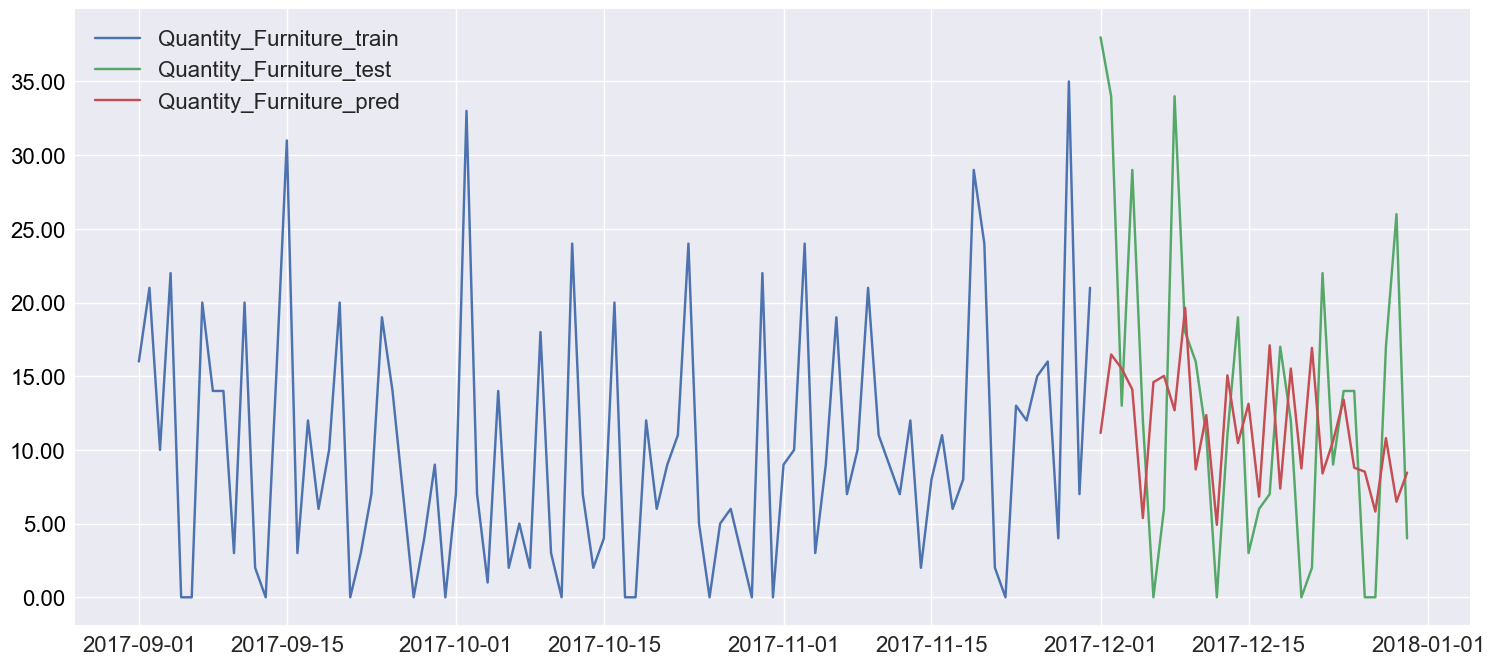

In [31]:

y =  "Quantity_Furniture" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"
dfxgbuv = dfXY_pred_xgbuv.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

d=datetime(2017,9,1)
bp.lineplot(dfxgbuv[dfxgbuv["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , figsize=(18,8) , legend=True)

**Predict SK XGB univariate**

In [32]:
ts_period = pd.DateOffset(days=1)
df_pred=sfxgbuv.predict(Nperiods=2,ts_period=ts_period)
df_pred

Quantity_Furniture_pred
2017-12-31                12.184675
2018-01-01                 1.541578

### Train Test and Validation

The purpose of this next exericise is for validation of our predictions against unseen data. The key goal is to validate that the out-of-sample predictions are the same as for predictions on unseen data. Below is the process for validating the out-of-sample predictions are correct.

Step 1. Create training/Test and validation (holdout set) data sets.   

Step 2.  Train Test with sforecast -  slidng forecast out of sample training and test, N-step recursive forecast methodFit the forecast model using the train/test data set

Step 3: Train (fit) using train set (separate from the validation set) ... 5 x 1-step recursive forward forecasts (should be identical to the above results)

Step 4. Compare the results of the two methods and ensure they produce identical forecasts.

Step 1: Create Data Sets - Train/Test and Validation

(1458, 6)


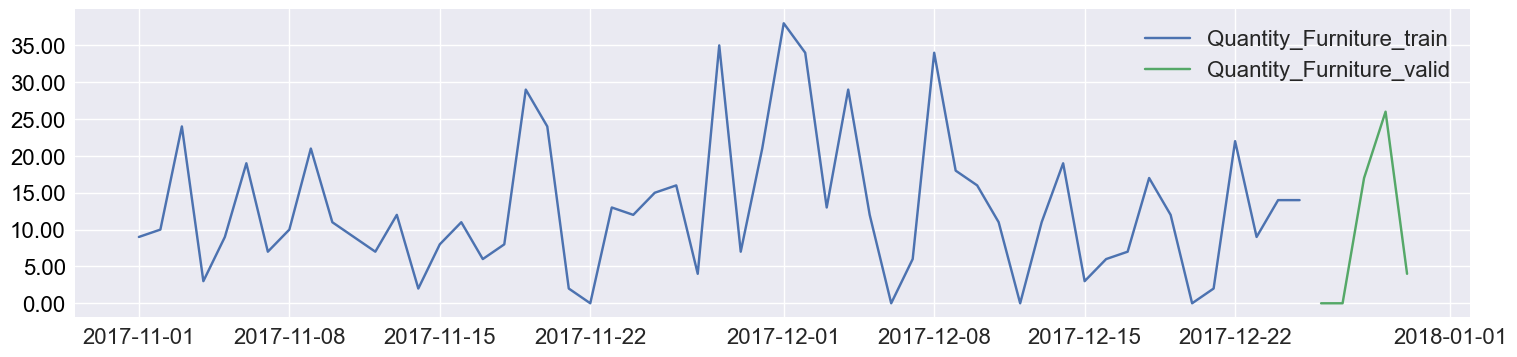

In [90]:
print(dfXYw.shape)
dfXY_traintest = dfXYw[["Quantity_Furniture"]]
dfXY_train = dfXYw[["Quantity_Furniture"]][:1453]
dfXY_train.columns = ["Quantity_Furniture_train"]
dfXY_valid = dfXYw[["Quantity_Furniture"]][1453:]
dfXY_valid.columns = ["Quantity_Furniture_valid"]

# plot
dfXY_train_valid_pred = pd.concat([dfXY_train, dfXY_valid])
dfXY_plot = dfXY_train_valid_pred.reset_index()
bp.lineplot(dfXY_plot.tail(60), x= "Order Date", y=["Quantity_Furniture_train", "Quantity_Furniture_valid"  ] , figsize=(18,4) , legend=True)

Step 2: model fit dfXY_traintest train and fit over all observations using out-of-sample prediction method with forecast horizon 5 ... 5 x 1-step recursive forecasts

In [82]:
# Step 2 a: Fit
Ntest = 5
Nhorizon = 5
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":40,
    "minmax" :(0,None)}  

y = ["Quantity_Furniture"]

xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 
sfmodel_1 = sf.sforecast(y = y, swin_parameters=swin_params,model=xgb_model,model_type="sk")
df_pred=sfmodel_1.fit(dfXY_traintest)

# housekeeping ... df_pred5_s2 
df_pred5_s2=df_pred[["Quantity_Furniture_pred"]].tail(5)
df_pred5_s2.columns = ["Quantity_Furniture_pred_s2"]
df_pred5_s2


Quantity_Furniture_pred_s2
Order Date                            
2017-12-26                    8.522676
2017-12-27                   11.428208
2017-12-28                   10.761415
2017-12-29                    9.716197
2017-12-30                   15.281743

Step 3: Train (fit) using train set (separate from the validation set) ... 5 x 1-step recursive forward forecasts (should be identical to the above results)

In [98]:
# Step 3 a: Fit on dfXY_train

Ntest = 0
Nhorizon = 1
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":40,
    "minmax" :(0,None)}  
y = ["Quantity_Furniture_train"]

xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 
sfmodel_2 = sf.sforecast(y = y, swin_parameters=swin_params,model=xgb_model,model_type="sk")
sfmodel_2.fit(dfXY_train)

# Step 2 b: Predict the next 5 days
ts_period = pd.DateOffset(days=1)
df_pred5_s3=sfmodel_2.predict(Nperiods=5,ts_period=ts_period)

# housekeeping ... df_pred5_s2 ... change column name for convenience
df_pred5_s3.columns = ["Quantity_Furniture_pred_s3"]
df_pred5_s3


Quantity_Furniture_pred_s3
2017-12-26                    8.522676
2017-12-27                   11.428208
2017-12-28                   10.761415
2017-12-29                    9.716197
2017-12-30                   15.281743

Step 4. Compare the results of the two methods
* Step 2 - Step 2: model fit dfXY_traintest train and fit over all observations using out-of-sample prediction method with forecast horizon 5 ... 5 x 1-step recursive forecasts
* Step 3 - model fit on training data (dfXY_train). Valdation data, last 5 days is unseen - 5 day forward forecast based recursive 1-step forecast over 5 days

We see that both predictions above are identical which proves that s-forecast out-of-sample sliding forecast is not leaking test/observation information data into the training set. 

Quantity_Furniture_train  Quantity_Furniture_pred_s2  \
Order Date                                                         
2017-12-21                       2.0                         NaN   
2017-12-22                      22.0                         NaN   
2017-12-23                       9.0                         NaN   
2017-12-24                      14.0                         NaN   
2017-12-25                      14.0                         NaN   
2017-12-26                       NaN                    8.522676   
2017-12-27                       NaN                   11.428208   
2017-12-28                       NaN                   10.761415   
2017-12-29                       NaN                    9.716197   
2017-12-30                       NaN                   15.281743   

            Quantity_Furniture_pred_s3  Quantity_Furniture_valid  
Order Date                                                        
2017-12-21                         NaN                       NaN  
2017-12-22                         NaN                       NaN  
2017-12-23                         NaN                       NaN  
2017-12-24                         NaN                       NaN  
2017-12-25                         NaN                       NaN  
2017-12-26                    8.522676                       0.0  
2017-12-27                   11.428208                       0.0  
2017-12-28                   10.761415                      17.0  
2017-12-29                    9.716197                      26.0  
2017-12-30                   15.281743                       4.0

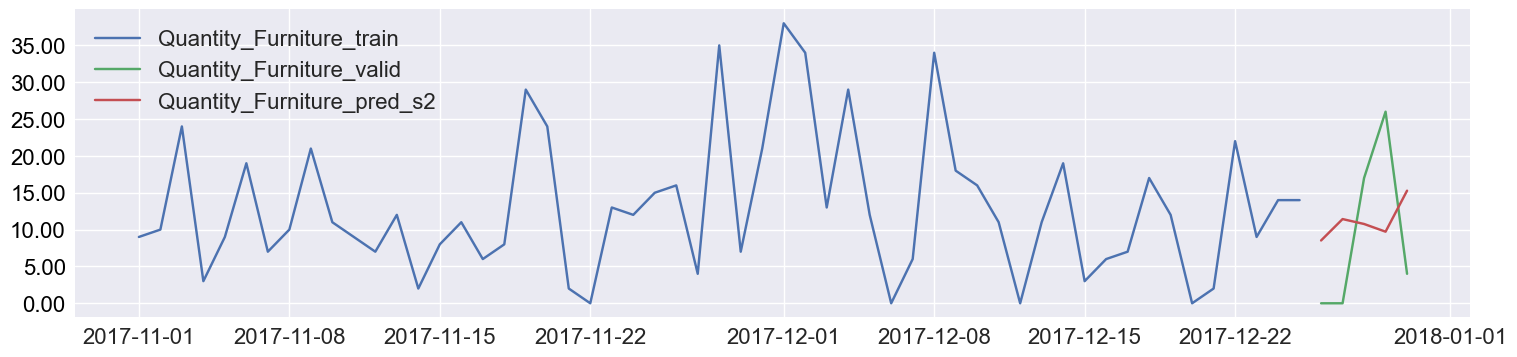

In [95]:
# Join the training, predictions and validations for easy comparison 
dfXY_testtrainpred = pd.concat([dfXY_train, df_pred5_s2])
dfXY_testtrainpred = dfXY_testtrainpred.join(df_pred5_s3)
dfXY_testtrainpred = dfXY_testtrainpred.join(dfXY_valid)

display(dfXY_testtrainpred.tail(10))

# plot
dfXY_plot = dfXY_testtrainpred.reset_index()
bp.lineplot(dfXY_plot.tail(60), x= "Order Date", y=["Quantity_Furniture_train", "Quantity_Furniture_valid","Quantity_Furniture_pred_s2"  ] , figsize=(18,4) , legend=True)

### Univariate Exogenous, Endogenous/derived variabless, Nhorizon = 2**

In [14]:
# deirvied variables transform

# derived attributes custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

# pipeline/transformer development
# BaseEstimater ... get_params(), set_params() methods
# TransformerMixin ... fit_transform() method
Nr = 3
class derived_attributes(BaseEstimator,TransformerMixin):
    def __init__(self, Nr = Nr): 
        self.Nr = Nr # slidig/rolling window rows
        self.dfmemory = None
    
    def fit(self,df):
        # ensure dataframe has enough rows
        self.dfmemory = df.tail(self.Nr) if df.index.size > self.Nr else df.index.size
        return self
    
    def transform(self,df=None, Nout=None, dfnewrows=None):
        # if df not spefified then transform on dfmemory
        # add new row(s) ... these will be provided from the predict operation
        if not isinstance(df,pd.DataFrame):
            df = self.dfmemory
            if isinstance(dfnewrows,pd.DataFrame):
                df = pd.concat([df,dfnewrows])
        self.dfmemory = df.tail(self.Nr) 
        Nr=self.Nr
        dfnew=df.copy()
        
        dfnew["Quantity_Furniture_m1_ravg"+str(Nr)] = dfnew["Quantity_Furniture_m1"].rolling(window=Nr).mean()  
        dfnew["Quantity_Furniture_m1_rstd"+str(Nr)] = dfnew["Quantity_Furniture_m1"].rolling(window=Nr).std()
        # dfnew=dfnew.iloc[Nr:] # do not toss out first Nr rows since they will be NA  this will be managed by sforecast
    
        Nclip = self.Nr
        return dfnew if Nout == None else dfnew.tail(Nout)
    
    def get_Nclip(self): # returns the number of initial rows are desgarded (clipped) for NaN avoidence
        return self.Nr
    
    def get_derived_attribute_names(self):
        Nr = self.Nr
        return [ "Quantity_Furniture_m1_ravg"+str(Nr), "Quantity_Furniture_m1_rstd"+str(Nr) ]
 
cols = ["Quantity_Furniture"]        
dfXY_m1 = dfXYw[cols].copy()


# the variables eill be created by sforecast
# here we test the transform to see what the new variables look like.
Nclip =derived_attributes().get_Nclip()
print("Nclip =",Nclip)
drived_var_transform = derived_attributes()
dfXY_m1["Quantity_Furniture_m1"] = dfXY_m1["Quantity_Furniture"].shift(1)
dftest = drived_var_transform.fit_transform(dfXY_m1)
print("dataframe, dftest, with derived variables")
display(dftest)

print(f'Nr= {Nr} dfmemory 3 rows from dataframe, saved by the transform after first use')
display(drived_var_transform.dfmemory)

Nclip = 3
dataframe, dftest, with derived variables


Quantity_Furniture  Quantity_Furniture_m1  \
Order Date                                              
2014-01-03                 0.0                    NaN   
2014-01-04                 0.0                    0.0   
2014-01-05                 0.0                    0.0   
2014-01-06                 9.0                    0.0   
2014-01-07                 3.0                    9.0   
...                        ...                    ...   
2017-12-26                 0.0                   14.0   
2017-12-27                 0.0                    0.0   
2017-12-28                17.0                    0.0   
2017-12-29                26.0                   17.0   
2017-12-30                 4.0                   26.0   

            Quantity_Furniture_m1_ravg3  Quantity_Furniture_m1_rstd3  
Order Date                                                            
2014-01-03                          NaN                          NaN  
2014-01-04                          NaN                          NaN  
2014-01-05                          NaN                          NaN  
2014-01-06                     0.000000                     0.000000  
2014-01-07                     3.000000                     5.196152  
...                                 ...                          ...  
2017-12-26                    12.333333                     2.886751  
2017-12-27                     9.333333                     8.082904  
2017-12-28                     4.666667                     8.082904  
2017-12-29                     5.666667                     9.814955  
2017-12-30                    14.333333                    13.203535  

[1458 rows x 4 columns]

Nr= 3 dfmemory 3 rows from dataframe, saved by the transform after first use


Quantity_Furniture  Quantity_Furniture_m1
Order Date                                           
2017-12-28                17.0                    0.0
2017-12-29                26.0                   17.0
2017-12-30                 4.0                   26.0

In [15]:
dfXY = dfXYw[["Quantity_Furniture"]].copy()

# Exogenous Variables
dfXY["dayofweek"] = dfXY.index.dayofweek

print('dfXY')
display(dfXY.head())

Ntest = 30
Nhorizon = 1
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":40,
    "exogvars": "dayofweek",
    "minmax" :(0,None),
    "derived_attributes_transform":derived_attributes # Endogenous Variables
    }  

y = ["Quantity_Furniture"]

xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 

sfxgbuv = sf.sforecast(y = y, swin_parameters=swin_params,model=xgb_model,model_type="sk")

df_pred_xgbuv = sfxgbuv.fit(dfXY)

display(df_pred_xgbuv.tail(5))

print(f'\nmetrics = {sfxgbuv.metrics}')

dfXY


Quantity_Furniture  dayofweek
Order Date                               
2014-01-03                 0.0          4
2014-01-04                 0.0          5
2014-01-05                 0.0          6
2014-01-06                 9.0          0
2014-01-07                 3.0          1

Quantity_Furniture_train  Quantity_Furniture_test  \
Order Date                                                      
2017-12-26                       NaN                      0.0   
2017-12-27                       NaN                      0.0   
2017-12-28                       NaN                     17.0   
2017-12-29                       NaN                     26.0   
2017-12-30                       NaN                      4.0   

            Quantity_Furniture_pred  Quantity_Furniture_pred_error  \
Order Date                                                           
2017-12-26                13.802155                      13.802155   
2017-12-27                 6.074481                       6.074481   
2017-12-28                10.371642                      -6.628358   
2017-12-29                16.953768                      -9.046232   
2017-12-30                10.460499                       6.460499   

            Quantity_Furniture_pred_lower  Quantity_Furniture_pred_upper  
Order Date                                                                
2017-12-26                            0.0                      25.416108  
2017-12-27                            0.0                      17.688434  
2017-12-28                            0.0                      21.985595  
2017-12-29                            0.0                      28.567721  
2017-12-30                            0.0                      22.074452


metrics = {'Quantity_Furniture_pred': {'RMSE': 11.268757705882695, 'MAE': 8.683470225334167}}


**Predict with Exogenous Variables and Engogenous/Derived Variables**

In [16]:
ts_period = pd.DateOffset(days=1)
dfexogs=pd.DataFrame(data = {"dayofweek":[2,3]})
df_pred=sfxgbuv.predict(Nperiods = 2, dfexogs = dfexogs, ts_period=ts_period)
df_pred

Quantity_Furniture_pred
2017-12-31                 8.322301
2018-01-01                12.238869

### Multivariate, Exogenous, Endogenous, one Output


* this case is similar to the previous one, but also includes the covariates in the dfXY dataset
* initialize the sliding window model as before
* we must declare the covariates so that they are accounted for properly - unlagged covariates are not included in the training set
* we have an improved forecast accuracy for y = Quantity_Furniture: RMSE': 9.83, 'MAE': 7.36
* when comparing the previous example's lineplot we notice improved accuracy. In this example the predicted line follows the actual ("test") line a little more closely. 

forecast fit

In [33]:
dfXY = dfXYw[["Quantity_Furniture","Quantity_Office Supplies", "Quantity_Technology" ]].copy()
y = ["Quantity_Furniture"]
print('dfXY',end="")
display(dfXY.tail())
Ntest = 30
Nhorizon = 1

swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":40,
    "minmax" :(0,None),
    "covars":[ "Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]} 

xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 
sfxgbmv1 = sf.sforecast(y = y, swin_parameters=swin_params,model=xgb_model, model_type="sk")
df_pred_xgbmv1 = sfxgbmv1.fit(dfXY)

print(f'\nmetrics = {sfxgbmv1.metrics}')
dfXY_pred_xgbmv1 = dfXY.join(df_pred_xgbmv1)
display(dfXY_pred_xgbmv1.tail(10))

dfXY

Quantity_Furniture  Quantity_Office Supplies  Quantity_Technology
Order Date                                                                   
2017-12-26                 0.0                      12.0                  0.0
2017-12-27                 0.0                       4.0                  2.0
2017-12-28                17.0                      44.0                  3.0
2017-12-29                26.0                      12.0                  3.0
2017-12-30                 4.0                      12.0                  7.0


metrics = {'Quantity_Furniture_pred': {'RMSE': 9.826672736184616, 'MAE': 7.359953657786051}}


Quantity_Furniture  Quantity_Office Supplies  Quantity_Technology  \
Order Date                                                                      
2017-12-21                 2.0                      29.0                  7.0   
2017-12-22                22.0                      54.0                 24.0   
2017-12-23                 9.0                      51.0                  3.0   
2017-12-24                14.0                      31.0                  9.0   
2017-12-25                14.0                      59.0                 14.0   
2017-12-26                 0.0                      12.0                  0.0   
2017-12-27                 0.0                       4.0                  2.0   
2017-12-28                17.0                      44.0                  3.0   
2017-12-29                26.0                      12.0                  3.0   
2017-12-30                 4.0                      12.0                  7.0   

            Quantity_Furniture_train  Quantity_Furniture_test  \
Order Date                                                      
2017-12-21                       NaN                      2.0   
2017-12-22                       NaN                     22.0   
2017-12-23                       NaN                      9.0   
2017-12-24                       NaN                     14.0   
2017-12-25                       NaN                     14.0   
2017-12-26                       NaN                      0.0   
2017-12-27                       NaN                      0.0   
2017-12-28                       NaN                     17.0   
2017-12-29                       NaN                     26.0   
2017-12-30                       NaN                      4.0   

            Quantity_Furniture_pred  Quantity_Furniture_pred_error  \
Order Date                                                           
2017-12-21                14.639476                      12.639476   
2017-12-22                 9.111044                     -12.888956   
2017-12-23                 7.607533                      -1.392467   
2017-12-24                 8.155879                      -5.844121   
2017-12-25                14.033888                       0.033888   
2017-12-26                 6.055835                       6.055835   
2017-12-27                 2.989914                       2.989914   
2017-12-28                18.785179                       1.785179   
2017-12-29                19.470705                      -6.529295   
2017-12-30                 9.454106                       5.454106   

            Quantity_Furniture_pred_lower  Quantity_Furniture_pred_upper  
Order Date                                                                
2017-12-21                       1.073297                      22.220024  
2017-12-22                       0.000000                      16.691592  
2017-12-23                       0.000000                      15.188082  
2017-12-24                       0.000000                      15.736427  
2017-12-25                       0.467709                      21.614436  
2017-12-26                       0.000000                      13.636383  
2017-12-27                       0.000000                      10.570462  
2017-12-28                       5.219000                      26.365727  
2017-12-29                       5.904526                      27.051253  
2017-12-30                       0.000000                      17.034654

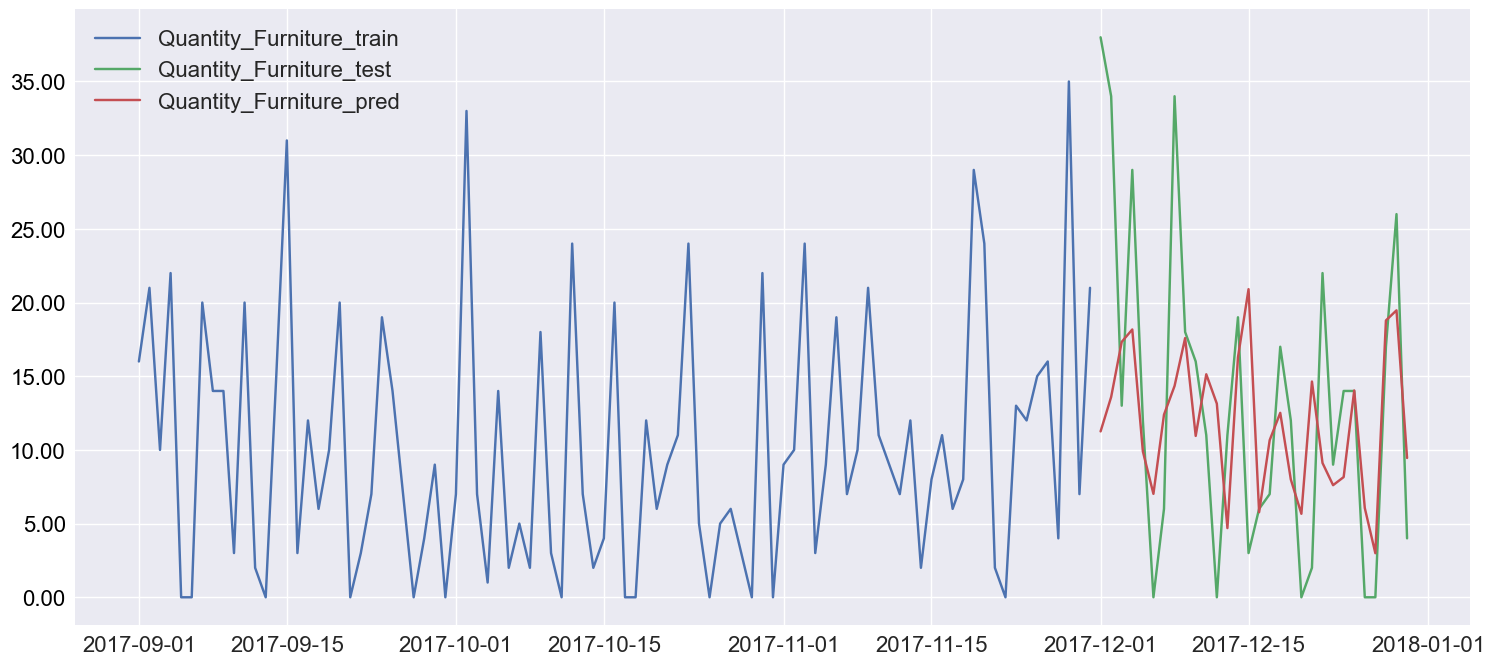

In [34]:
y =  "Quantity_Furniture" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"
dfxgbmv1 = dfXY_pred_xgbmv1.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

d=datetime(2017,9,1)
bp.lineplot(dfxgbmv1[dfxgbmv1["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , figsize=(18,8))

**3 derived attributes**

In [35]:
# deirvied variables transform

# derived attributes custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

# pipeline/transformer development
# BaseEstimater ... get_params(), set_params() methods
# TransformerMixin ... fit_transform() method
Nr = 3
class derived_attributes_3(BaseEstimator,TransformerMixin):
    def __init__(self, Nr = Nr): 
        self.Nr = Nr # slidig/rolling window rows
        self.dfmemory = None
    
    def fit(self,df):
        # ensure dataframe has enough rows
        self.dfmemory = df.tail(self.Nr) if df.index.size > self.Nr else df.index.size
        return self
    
    def transform(self,df=None, Nout=None, dfnewrows=None):
        # if df not spefified then transform on dfmemory
        # add new row(s) ... these will be provided from the predict operation
        if not isinstance(df,pd.DataFrame):
            df = self.dfmemory
            if isinstance(dfnewrows,pd.DataFrame):
                df = pd.concat([df,dfnewrows])
        self.dfmemory = df.tail(self.Nr) 
        Nr=self.Nr
        dfnew=df.copy()
        
        dfnew["Quantity_Furniture_m1_ravg"+str(Nr)] = dfnew["Quantity_Furniture_m1"].rolling(window=Nr).mean()  
        dfnew["Quantity_Furniture_m1_rstd"+str(Nr)] = dfnew["Quantity_Furniture_m1"].rolling(window=Nr).std()
        dfnew["Quantity_Office_Supplies_m1_ravg"+str(Nr)] = dfnew["Quantity_Office Supplies_m1"].rolling(window=Nr).mean()  
        dfnew["Quantity_Office_Supplies_m1_rstd"+str(Nr)] = dfnew["Quantity_Office Supplies_m1"].rolling(window=Nr).std()
        dfnew["Quantity_Technology_m1_ravg"+str(Nr)] = dfnew["Quantity_Technology_m1"].rolling(window=Nr).mean()  
        dfnew["Quantity_Technology_m1_rstd"+str(Nr)] = dfnew["Quantity_Technology_m1"].rolling(window=Nr).std()
        # dfnew=dfnew.iloc[Nr:] # do not toss out first Nr rows since they will be NA  this will be managed by sforecast
    
        Nclip = self.Nr
        return dfnew if Nout == None else dfnew.tail(Nout)
    
    def get_Nclip(self): # returns the number of initial rows are desgarded (clipped) for NaN avoidence
        return self.Nr
    
    def get_derived_attribute_names(self):
        Nr = self.Nr
        return [ "Quantity_Furniture_m1_ravg"+str(Nr), "Quantity_Furniture_m1_rstd"+str(Nr),
                "Quantity_Office_Supplies_m1_ravg"+str(Nr), "Quantity_Office_Supplies_m1_rstd"+str(Nr),
                "Quantity_Technology_m1_ravg"+str(Nr), "Quantity_Technology_m1_rstd"+str(Nr)
                ]
 
cols = ["Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]        
dfXY_m1 = dfXYw[cols].copy()


# the variables eill be created by sforecast
# here we test the transform to see what the new variables look like.
Nclip =derived_attributes_3().get_Nclip()
print("Nclip =",Nclip)
drived_var_transform = derived_attributes_3()
dfXY_m1[["Quantity_Furniture_m1", "Quantity_Office Supplies_m1","Quantity_Technology_m1" ]] = dfXY_m1[["Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"  ]].shift(1)
dftest = drived_var_transform.fit_transform(dfXY_m1)
print("dataframe, dftest, with derived variables")
display(dftest)

print(f'Nr= {Nr} dfmemory 3 rows from dataframe, saved by the transform after first use')
display(drived_var_transform.dfmemory)

Nclip = 3
dataframe, dftest, with derived variables


Quantity_Furniture  Quantity_Office Supplies  Quantity_Technology  \
Order Date                                                                      
2014-01-03                 0.0                       2.0                  0.0   
2014-01-04                 0.0                       8.0                  0.0   
2014-01-05                 0.0                       3.0                  0.0   
2014-01-06                 9.0                      15.0                  6.0   
2014-01-07                 3.0                       7.0                  0.0   
...                        ...                       ...                  ...   
2017-12-26                 0.0                      12.0                  0.0   
2017-12-27                 0.0                       4.0                  2.0   
2017-12-28                17.0                      44.0                  3.0   
2017-12-29                26.0                      12.0                  3.0   
2017-12-30                 4.0                      12.0                  7.0   

            Quantity_Furniture_m1  Quantity_Office Supplies_m1  \
Order Date                                                       
2014-01-03                    NaN                          NaN   
2014-01-04                    0.0                          2.0   
2014-01-05                    0.0                          8.0   
2014-01-06                    0.0                          3.0   
2014-01-07                    9.0                         15.0   
...                           ...                          ...   
2017-12-26                   14.0                         59.0   
2017-12-27                    0.0                         12.0   
2017-12-28                    0.0                          4.0   
2017-12-29                   17.0                         44.0   
2017-12-30                   26.0                         12.0   

            Quantity_Technology_m1  Quantity_Furniture_m1_ravg3  \
Order Date                                                        
2014-01-03                     NaN                          NaN   
2014-01-04                     0.0                          NaN   
2014-01-05                     0.0                          NaN   
2014-01-06                     0.0                     0.000000   
2014-01-07                     6.0                     3.000000   
...                            ...                          ...   
2017-12-26                    14.0                    12.333333   
2017-12-27                     0.0                     9.333333   
2017-12-28                     2.0                     4.666667   
2017-12-29                     3.0                     5.666667   
2017-12-30                     3.0                    14.333333   

            Quantity_Furniture_m1_rstd3  Quantity_Office_Supplies_m1_ravg3  \
Order Date                                                                   
2014-01-03                          NaN                                NaN   
2014-01-04                          NaN                                NaN   
2014-01-05                          NaN                                NaN   
2014-01-06                     0.000000                           4.333333   
2014-01-07                     5.196152                           8.666667   
...                                 ...                                ...   
2017-12-26                     2.886751                          47.000000   
2017-12-27                     8.082904                          34.000000   
2017-12-28                     8.082904                          25.000000   
2017-12-29                     9.814955                          20.000000   
2017-12-30                    13.203535                          20.000000   

            Quantity_Office_Supplies_m1_rstd3  Quantity_Technology_m1_ravg3  \
Order Date                                                                    
2014-01-03                                NaN         

Nr= 3 dfmemory 3 rows from dataframe, saved by the transform after first use


Quantity_Furniture  Quantity_Office Supplies  Quantity_Technology  \
Order Date                                                                      
2017-12-28                17.0                      44.0                  3.0   
2017-12-29                26.0                      12.0                  3.0   
2017-12-30                 4.0                      12.0                  7.0   

            Quantity_Furniture_m1  Quantity_Office Supplies_m1  \
Order Date                                                       
2017-12-28                    0.0                          4.0   
2017-12-29                   17.0                         44.0   
2017-12-30                   26.0                         12.0   

            Quantity_Technology_m1  
Order Date                          
2017-12-28                     2.0  
2017-12-29                     3.0  
2017-12-30                     3.0

In [36]:
dfXY = dfXYw[["Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]].copy()
# Exogenous Variables
dfXY["dayofweek"] = dfXY.index.dayofweek

display(dfXY.head())


y = [ "Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]
Ntest= 30
Nhorizon = 1
# sliding forecast inputs
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":40,
    "minmax" :(0,None),
    "covars":[ "Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"],
    "exogvars":"dayofweek",
    "derived_attributes_transform":derived_attributes_3 # Endogenous Variables
    } 


xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 

# sliding forecast model and forecast
sfxgbmv = sf.sforecast(y = y, swin_parameters=swin_params,model=xgb_model,model_type="sk")
df_pred_xgbmv = sfxgbmv.fit(dfXY)


print(f'\nmetrics = {sfxgbmv.metrics}')

print("confidence intervals, 1 to Nh = ",sfxgbmv.ci )

dfXY_pred_xgbmv = dfXY.join(df_pred_xgbmv)
display(dfXY_pred_xgbmv)

Quantity_Furniture  Quantity_Office Supplies  Quantity_Technology  \
Order Date                                                                      
2014-01-03                 0.0                       2.0                  0.0   
2014-01-04                 0.0                       8.0                  0.0   
2014-01-05                 0.0                       3.0                  0.0   
2014-01-06                 9.0                      15.0                  6.0   
2014-01-07                 3.0                       7.0                  0.0   

            dayofweek  
Order Date             
2014-01-03          4  
2014-01-04          5  
2014-01-05          6  
2014-01-06          0  
2014-01-07          1


metrics = {'Quantity_Furniture_pred': {'RMSE': 9.8486353734835, 'MAE': 7.366431101163228}, 'Quantity_Office Supplies_pred': {'RMSE': 22.649182573120264, 'MAE': 15.80677916208903}, 'Quantity_Technology_pred': {'RMSE': 7.403682683708571, 'MAE': 5.99887033700943}}
confidence intervals, 1 to Nh =  {'Quantity_Furniture': [(-14.876869773864746, 6.49545526504517)], 'Quantity_Office Supplies': [(-36.66603240966797, 17.70495643615723)], 'Quantity_Technology': [(-7.866886711120604, 9.409889793395998)]}


Quantity_Furniture  Quantity_Office Supplies  Quantity_Technology  \
Order Date                                                                      
2014-01-03                 0.0                       2.0                  0.0   
2014-01-04                 0.0                       8.0                  0.0   
2014-01-05                 0.0                       3.0                  0.0   
2014-01-06                 9.0                      15.0                  6.0   
2014-01-07                 3.0                       7.0                  0.0   
...                        ...                       ...                  ...   
2017-12-26                 0.0                      12.0                  0.0   
2017-12-27                 0.0                       4.0                  2.0   
2017-12-28                17.0                      44.0                  3.0   
2017-12-29                26.0                      12.0                  3.0   
2017-12-30                 4.0                      12.0                  7.0   

            dayofweek  Quantity_Furniture_train  Quantity_Furniture_test  \
Order Date                                                                 
2014-01-03          4                       0.0                      NaN   
2014-01-04          5                       0.0                      NaN   
2014-01-05          6                       0.0                      NaN   
2014-01-06          0                       9.0                      NaN   
2014-01-07          1                       3.0                      NaN   
...               ...                       ...                      ...   
2017-12-26          1                       NaN                      0.0   
2017-12-27          2                       NaN                      0.0   
2017-12-28          3                       NaN                     17.0   
2017-12-29          4                       NaN                     26.0   
2017-12-30          5                       NaN                      4.0   

            Quantity_Furniture_pred  Quantity_Furniture_pred_error  \
Order Date                                                           
2014-01-03                      NaN                            NaN   
2014-01-04                      NaN                            NaN   
2014-01-05                      NaN                            NaN   
2014-01-06                      NaN                            NaN   
2014-01-07                      NaN                            NaN   
...                             ...                            ...   
2017-12-26                 6.255946                       6.255946   
2017-12-27                 4.276994                       4.276994   
2017-12-28                14.355412                      -2.644588   
2017-12-29                15.359674                     -10.640326   
2017-12-30                 5.929822                       1.929822   

            Quantity_Furniture_pred_lower  Quantity_Furniture_pred_upper  ...  \
Order Date                                                                ...   
2014-01-03                            NaN                            NaN  ...   
2014-01-04                            NaN                            NaN  ...   
2014-01-05                            NaN                            NaN  ...   
2014-01-06                            NaN                            NaN  ...   
2014-01-07                            NaN                            NaN  ...   
...                                   ...                            ...  ...   
2017-12-26                       0.000000                      12.751401  ...   
2017-12-27                       0.000000                      10.772449  ...   
2017-12-28                       0.000000                      20.850867  ...   
2017-12-29                       0.482804                      21.855129  ...   
2017-12-30                       0.000000                      12.425277  ...   

    

Plot

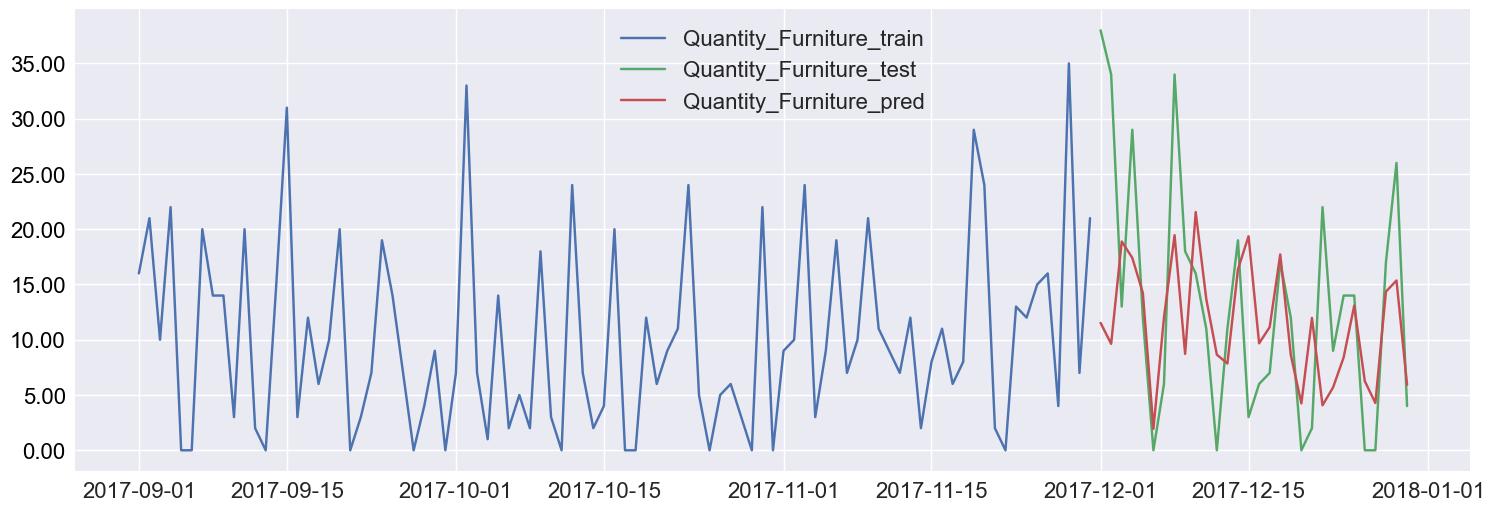

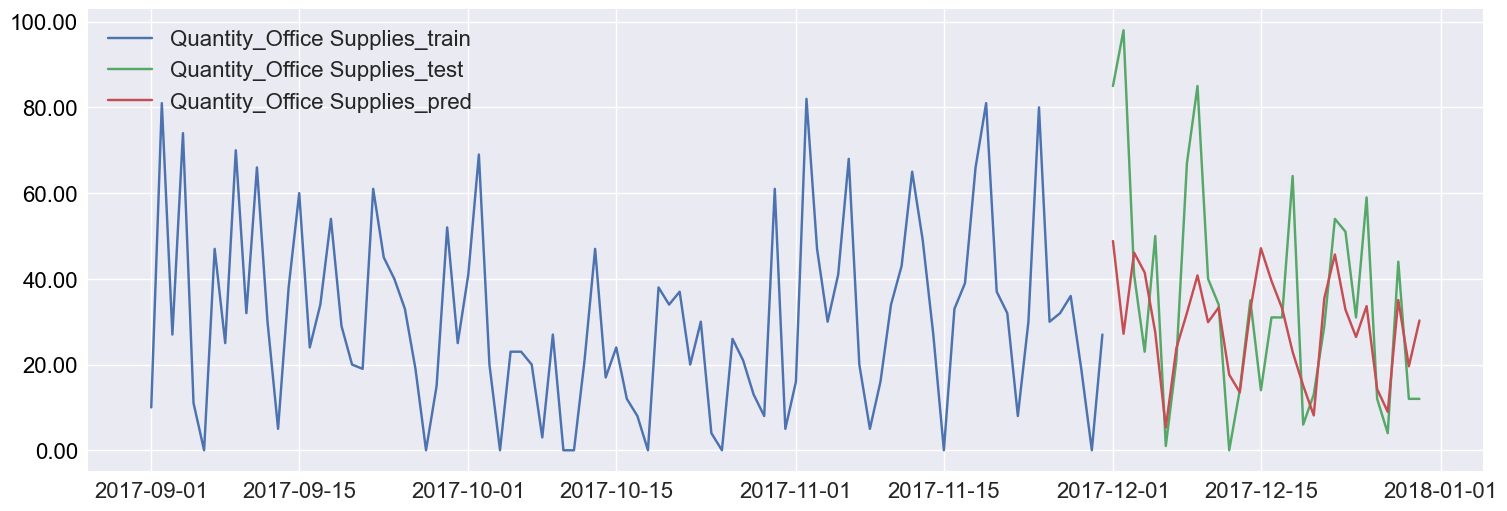

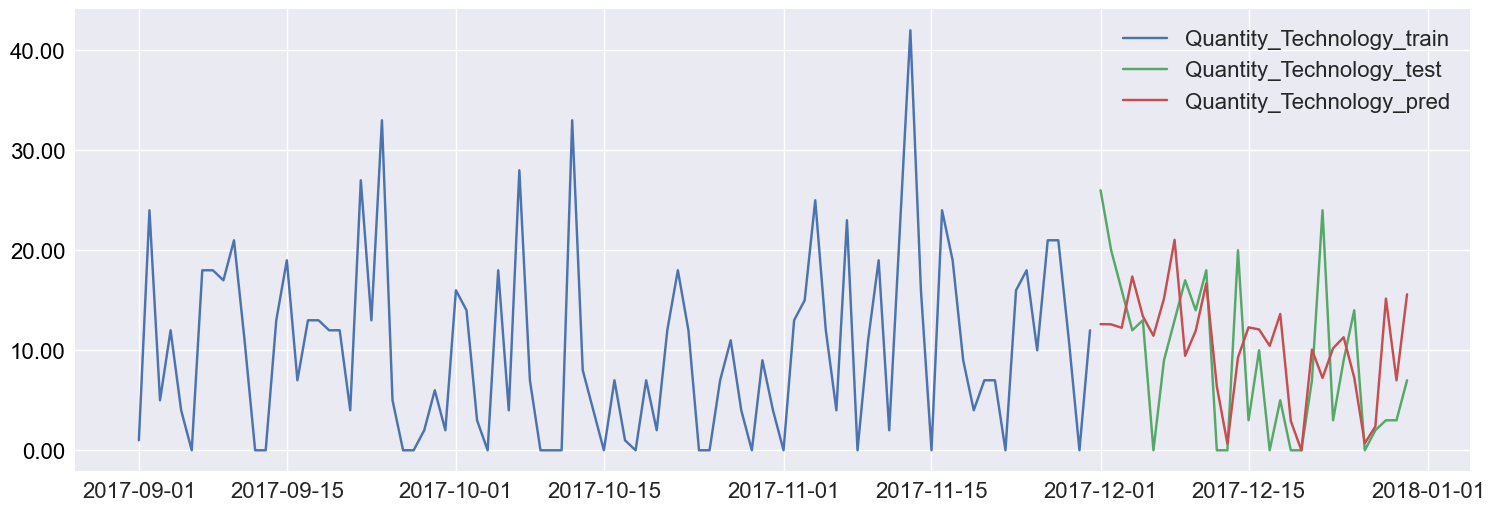

In [37]:

dfxgbmv = dfXY_pred_xgbmv.reset_index().copy() # seaborn lineplot function needs x-axis to be a column
d=datetime(2017,9,1)

y =  "Quantity_Furniture" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"

bp.lineplot(dfxgbmv[dfxgbmv["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , figsize=(18,6) , legend=True)


y =  "Quantity_Office Supplies" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"

bp.lineplot(dfxgbmv[dfxgbmv["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , figsize=(18,6) , legend=True)

y =  "Quantity_Technology" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"

bp.lineplot(dfxgbmv[dfxgbmv["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , figsize=(18,6) , legend=True)

### Multivariate,Exogenous, Endogenous, Multiple Outputs, Nhorizon > 1

* This case is again very similar to the previous examples, with the difference that the forecast horizon is 5 periods between model re-training
* Again we inclue the co-variate variables but now we also forecast the co-variates
* In this case, sforecast loops through these variables and creates the forecasts
* Note that for more advanced types of models, such as deep-learning models the multivarites forecasts can be generated simultaneously
* We display the upper and lower prediction bounds, included with the prediction output.

In [38]:
dfXY = dfXYw[["Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]].copy()
# Exogenous Variables
dfXY["dayofweek"] = dfXY.index.dayofweek

display(dfXY.tail())


y = [ "Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]
Ntest= 30
Nhorizon = 5

# sliding forecast inputs
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":40,
    "minmax" :(0,None),
    "covars":[ "Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"],
    "exogvars":"dayofweek",
    "derived_attributes_transform":derived_attributes_3 # Endogenous Variables
    } 


xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 

# sliding forecast model and forecast
sfxgbmv = sf.sforecast(y = y, swin_parameters=swin_params,model=xgb_model,model_type="sk")
df_pred_xgbmv = sfxgbmv.fit(dfXY)


print(f'\nmetrics = {sfxgbmv.metrics}')

dfXY_pred_xgbmv = dfXY.join(df_pred_xgbmv)
display(dfXY_pred_xgbmv)

Quantity_Furniture  Quantity_Office Supplies  Quantity_Technology  \
Order Date                                                                      
2017-12-26                 0.0                      12.0                  0.0   
2017-12-27                 0.0                       4.0                  2.0   
2017-12-28                17.0                      44.0                  3.0   
2017-12-29                26.0                      12.0                  3.0   
2017-12-30                 4.0                      12.0                  7.0   

            dayofweek  
Order Date             
2017-12-26          1  
2017-12-27          2  
2017-12-28          3  
2017-12-29          4  
2017-12-30          5


metrics = {'Quantity_Furniture_pred': {'RMSE': 9.976216299383216, 'MAE': 7.866652846336365}, 'Quantity_Office Supplies_pred': {'RMSE': 23.934072907054958, 'MAE': 17.96384661992391}, 'Quantity_Technology_pred': {'RMSE': 7.2867655310880295, 'MAE': 6.050153358777364}}


Quantity_Furniture  Quantity_Office Supplies  Quantity_Technology  \
Order Date                                                                      
2014-01-03                 0.0                       2.0                  0.0   
2014-01-04                 0.0                       8.0                  0.0   
2014-01-05                 0.0                       3.0                  0.0   
2014-01-06                 9.0                      15.0                  6.0   
2014-01-07                 3.0                       7.0                  0.0   
...                        ...                       ...                  ...   
2017-12-26                 0.0                      12.0                  0.0   
2017-12-27                 0.0                       4.0                  2.0   
2017-12-28                17.0                      44.0                  3.0   
2017-12-29                26.0                      12.0                  3.0   
2017-12-30                 4.0                      12.0                  7.0   

            dayofweek  Quantity_Furniture_train  Quantity_Furniture_test  \
Order Date                                                                 
2014-01-03          4                       0.0                      NaN   
2014-01-04          5                       0.0                      NaN   
2014-01-05          6                       0.0                      NaN   
2014-01-06          0                       9.0                      NaN   
2014-01-07          1                       3.0                      NaN   
...               ...                       ...                      ...   
2017-12-26          1                       NaN                      0.0   
2017-12-27          2                       NaN                      0.0   
2017-12-28          3                       NaN                     17.0   
2017-12-29          4                       NaN                     26.0   
2017-12-30          5                       NaN                      4.0   

            Quantity_Furniture_pred  Quantity_Furniture_pred_error  \
Order Date                                                           
2014-01-03                      NaN                            NaN   
2014-01-04                      NaN                            NaN   
2014-01-05                      NaN                            NaN   
2014-01-06                      NaN                            NaN   
2014-01-07                      NaN                            NaN   
...                             ...                            ...   
2017-12-26                 6.255946                       6.255946   
2017-12-27                 7.713229                       7.713229   
2017-12-28                12.548862                      -4.451138   
2017-12-29                16.644186                      -9.355814   
2017-12-30                10.808694                       6.808694   

            Quantity_Furniture_pred_lower  Quantity_Furniture_pred_upper  ...  \
Order Date                                                                ...   
2014-01-03                            NaN                            NaN  ...   
2014-01-04                            NaN                            NaN  ...   
2014-01-05                            NaN                            NaN  ...   
2014-01-06                            NaN                            NaN  ...   
2014-01-07                            NaN                            NaN  ...   
...                                   ...                            ...  ...   
2017-12-26                       0.000000                      14.370791  ...   
2017-12-27                       0.000000                      19.176550  ...   
2017-12-28                       0.000000                      12.967516  ...   
2017-12-29                       4.276856                      17.643860  ...   
2017-12-30                       8.046289                      23.339748  ...   

    

plot the observations, predicted output, and test (observations during corresponding to the predictions)

illustrate the confidence interval around the predictions. Sforecast defaults to 80% confidence periods, however the desired confidence interval can be specified as an input parameter.

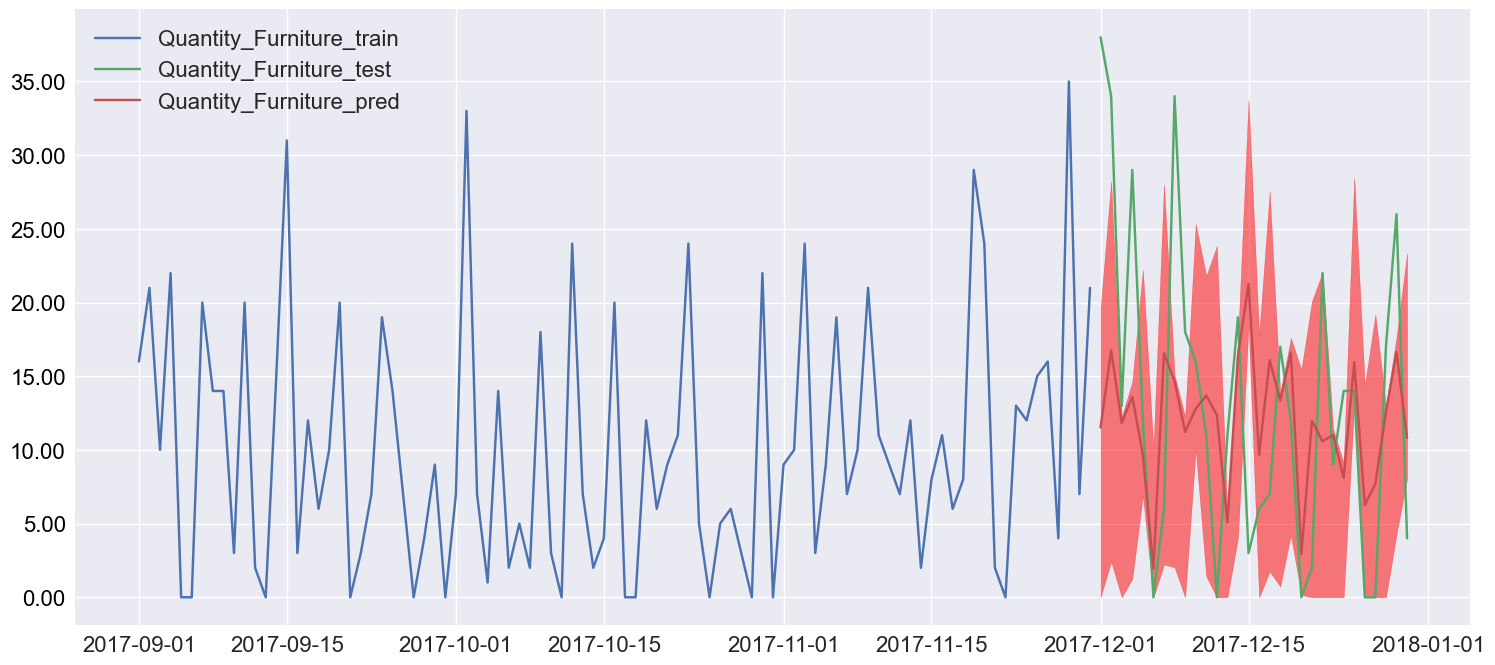

In [39]:
y =  "Quantity_Furniture" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"
dfxgbmv = dfXY_pred_xgbmv.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

yfillbetween = (y+"_pred_lower",y+"_pred_upper")

d=datetime(2017,9,1)
bp.lineplot(dfxgbmv[dfxgbmv["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , yfb=yfillbetween, figsize=(18,8) , legend=True)

**predict multi-output multivariat w/ exogenous and endogenous/derived variablese**

In [40]:
ts_period = pd.DateOffset(days=1)
dfexogs=pd.DataFrame(data = {"dayofweek":[2,3,4,5,6]})
df_pred=sfxgbmv.predict(Nperiods=5,dfexogs = dfexogs, ts_period=ts_period)
df_pred

Quantity_Furniture_pred  Quantity_Office Supplies_pred  \
2017-12-31                10.596957                      21.441370   
2018-01-01                11.101211                      29.642622   
2018-01-02                 8.706774                       6.349918   
2018-01-03                 5.279029                      23.692055   
2018-01-04                 5.839658                      23.958937   

            Quantity_Technology_pred  
2017-12-31                 13.699134  
2018-01-01                  6.676338  
2018-01-02                  7.046351  
2018-01-03                  4.803581  
2018-01-04                 10.914982

fit example using all training observations, Npred = 0

## 3. TensorFlow Models

### TensorFlow Imports

In [5]:
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Embedding, concatenate, Dropout
from keras.layers import LSTM, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

2023-01-12 19:19:06.343108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### M5 Sales data, 7 items, data transformation to wide format

M5 Sales 7 Items

In [6]:

df_m5sales7 = pd.read_csv("../data/m5_sales_7_items_events_cci_wide.csv", parse_dates = ["date"])
df_m5sales7 = df_m5sales7.set_index("date")
print("df_m5sales7")
display(df_m5sales7.tail())

# variable types
covars = [c for c in df_m5sales7.columns if "unit_sales_CA1_" in c]
catvars = [ "weekday", "event_name_1","event_name_2"]
exogvars = [ "year", "month" , "week",  "snap_CA",  "CCI_USA"]
Ncatvars = len(catvars)
Ncovars = len(covars)
Nexogvars = len(exogvars)

# dfXY ... covars + exogvars + catvars
cols = covars+catvars+exogvars
dfXY = df_m5sales7[cols].copy()

# label Encoding
le_catvars = [ "le_"+c for c in ["event_name_1","event_name_2"] ] # label encoded category columns ... weekday already encoded
print(le_catvars)
le = LabelEncoder()
dfXY[le_catvars] =dfXY[["event_name_1","event_name_2"] ].apply(le.fit_transform)
weekday_num = {"Sunday":0, "Monday":1, "Tuesday":2, "Wednesday":3, "Thursday":4, "Friday":5, "Saturday":6}
dfXY["le_weekday"] = dfXY["weekday"].apply( lambda x: weekday_num[x]) # create our own labels or label_encoder creates arbitrary number assignments
le_catvars = ["le_weekday"] + le_catvars # weekday is alread encoded ... add to le_catvars 
print(f'le_catvars = {le_catvars}')
print(f'N event_name_1 labels = {dfXY.groupby("event_name_1")["event_name_1"].count().index.size}')

# embedding dimensions
eindim = [dfXY[le_catvars].groupby(c)[c].count().index.size + 1 for c in le_catvars] # add 1 to the dim or err in TF
eoutdim = [np.rint(np.log2(x)).astype(int) for x in eindim]
print(f'eindim = {eindim}')
print(f'eoutdim = {eoutdim}')

# display dfXY
print(f'dfXY.shape = {dfXY.shape}')
print(f'\ndfXY.head = ')
display(dfXY.head())

df_m5sales7


unit_sales_CA1_HOUSEHOLD_416  unit_sales_CA1_FOODS_044  \
date                                                                 
2016-05-18                           2.0                       0.0   
2016-05-19                           2.0                       0.0   
2016-05-20                           1.0                       0.0   
2016-05-21                           0.0                       3.0   
2016-05-22                           3.0                       2.0   

            unit_sales_CA1_FOODS_030  unit_sales_CA1_HOBBIES_418  \
date                                                               
2016-05-18                       7.0                         1.0   
2016-05-19                      11.0                         1.0   
2016-05-20                       9.0                         4.0   
2016-05-21                       9.0                         0.0   
2016-05-22                       8.0                         0.0   

            unit_sales_CA1_FOODS_185  unit_sales_CA1_HOUSEHOLD_219  \
date                                                                 
2016-05-18                       4.0                           0.0   
2016-05-19                       1.0                           0.0   
2016-05-20                       1.0                           0.0   
2016-05-21                       2.0                           2.0   
2016-05-22                       2.0                           1.0   

            unit_sales_CA1_FOODS_393  sell_price_CA1_HOUSEHOLD_416  \
date                                                                 
2016-05-18                       5.0                          3.88   
2016-05-19                       8.0                          3.88   
2016-05-20                       5.0                          3.88   
2016-05-21                       5.0                          3.88   
2016-05-22                      15.0                          3.88   

            sell_price_CA1_FOODS_044  sell_price_CA1_FOODS_030  ...  \
date                                                            ...   
2016-05-18                       2.5                      1.48  ...   
2016-05-19                       2.5                      1.48  ...   
2016-05-20                       2.5                      1.48  ...   
2016-05-21                       2.5                      1.48  ...   
2016-05-22                       2.5                      1.48  ...   

            sell_price_CA1_FOODS_393  year  month  week    weekday  yearmonth  \
date                                                                            
2016-05-18                      3.56  2016      5    20  Wednesday     201605   
2016-05-19                      3.56  2016      5    20   Thursday     201605   
2016-05-20                      3.56  2016      5    20     Friday     201605   
2016-05-21                      3.56  2016      5    20   Saturday     201605   
2016-05-22                      3.56  2016      5    20     Sunday     201605   

            event_name_1 event_name_2  snap_CA   CCI_USA  
date                                                      
2016-05-18           NaN          NaN        0  100.7612  
2016-05-19           NaN          NaN        0  100.7612  
2016-05-20           NaN          NaN        0  100.7612  
2016-05-21           NaN          NaN        0  100.7612  
2016-05-22           NaN          NaN        0  100.7612  

[5 rows x 23 columns]

['le_event_name_1', 'le_event_name_2']
le_catvars = ['le_weekday', 'le_event_name_1', 'le_event_name_2']
N event_name_1 labels = 30
eindim = [8, 32, 5]
eoutdim = [3, 5, 2]
dfXY.shape = (1206, 18)

dfXY.head = 


unit_sales_CA1_HOUSEHOLD_416  unit_sales_CA1_FOODS_044  \
date                                                                 
2013-02-02                           2.0                       0.0   
2013-02-03                           0.0                       0.0   
2013-02-04                           1.0                       1.0   
2013-02-05                           0.0                       1.0   
2013-02-06                           0.0                       1.0   

            unit_sales_CA1_FOODS_030  unit_sales_CA1_HOBBIES_418  \
date                                                               
2013-02-02                      43.0                         0.0   
2013-02-03                      33.0                         0.0   
2013-02-04                       5.0                         0.0   
2013-02-05                      14.0                         0.0   
2013-02-06                      11.0                         0.0   

            unit_sales_CA1_FOODS_185  unit_sales_CA1_HOUSEHOLD_219  \
date                                                                 
2013-02-02                       0.0                           0.0   
2013-02-03                       0.0                           0.0   
2013-02-04                       0.0                           0.0   
2013-02-05                       0.0                           0.0   
2013-02-06                       0.0                           0.0   

            unit_sales_CA1_FOODS_393    weekday event_name_1 event_name_2  \
date                                                                        
2013-02-02                       4.0   Saturday          NaN          NaN   
2013-02-03                       5.0     Sunday    SuperBowl          NaN   
2013-02-04                       1.0     Monday          NaN          NaN   
2013-02-05                       2.0    Tuesday          NaN          NaN   
2013-02-06                       2.0  Wednesday          NaN          NaN   

            year  month  week  snap_CA   CCI_USA  le_event_name_1  \
date                                                                
2013-02-02  2013      2     5        1  98.72734               30   
2013-02-03  2013      2     5        1  98.72734               26   
2013-02-04  2013      2     6        1  98.72734               30   
2013-02-05  2013      2     6        1  98.72734               30   
2013-02-06  2013      2     6        1  98.72734               30   

            le_event_name_2  le_weekday  
date                                     
2013-02-02                3           6  
2013-02-03                3           0  
2013-02-04                3           1  
2013-02-05                3           2  
2013-02-06                3           3

### Univariate

Univariate Data

In [13]:
# y forecast variable
y = ["unit_sales_CA1_FOODS_030"]

# univariate data
print("dfXYtf univariate")
dfXYtf = dfXY[y] 
display(dfXYtf.tail())

dfXYtf univariate


unit_sales_CA1_FOODS_030
date                                
2016-05-18                       7.0
2016-05-19                      11.0
2016-05-20                       9.0
2016-05-21                       9.0
2016-05-22                       8.0

TF Model - Dense Network, Univariate

In [14]:
# TensorFlow model with 3 hidden layers

Nlags=5
inputs = Input((Nlags,))
h1 = Dense(Nlags, activation='relu')(inputs)
h2 = Dense(20, activation='relu')(h1)
h3 = Dense(10, activation='relu')(h2)
output = Dense(1)(h3) # linear output
model_tf_dense = Model(inputs=inputs, outputs=output)

# define optimizer and compile
optimizer = Adam(learning_rate=0.05, decay=.1)
model_tf_dense.compile(loss='mse', optimizer=optimizer)
print(model_tf_dense.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_4 (Dense)             (None, 5)                 30        
                                                                 
 dense_5 (Dense)             (None, 20)                120       
                                                                 
 dense_6 (Dense)             (None, 10)                210       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________
None


TF forecast Univariate

In [15]:
# display data
print("dfXYtf")
display(dfXYtf.tail())

# compile again to ensure model is initialized w/o training
optimizer = Adam(learning_rate=0.05, decay=.1)
model_tf_dense.compile(loss='mse', optimizer=optimizer)

# Forecast - fit
Ntest=10
Nhorizon = 1
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":Nlags,
    "minmax" :(0,None)
    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 100,
    "batch_size":100
    }

sfuvtf = sf.sforecast(y = y, model_type="tf", swin_parameters=swin_params,model=model_tf_dense, tf_parameters=tf_params)

df_pred_uv = sfuvtf.fit(dfXYtf)

print(f'\nmetrics = {sfuvtf.metrics}')
dfXY_pred_uvtf = dfXYtf.join(df_pred_uv)
display(dfXY_pred_uvtf.tail())


dfXYtf


unit_sales_CA1_FOODS_030
date                                
2016-05-18                       7.0
2016-05-19                      11.0
2016-05-20                       9.0
2016-05-21                       9.0
2016-05-22                       8.0

1/1 [==============================] - 0s 22ms/step

metrics = {'unit_sales_CA1_FOODS_030_pred': {'RMSE': 1.9486763705648535, 'MAE': 1.3753465175628663}}


unit_sales_CA1_FOODS_030  unit_sales_CA1_FOODS_030_train  \
date                                                                   
2016-05-18                       7.0                             NaN   
2016-05-19                      11.0                             NaN   
2016-05-20                       9.0                             NaN   
2016-05-21                       9.0                             NaN   
2016-05-22                       8.0                             NaN   

            unit_sales_CA1_FOODS_030_test  unit_sales_CA1_FOODS_030_pred  \
date                                                                       
2016-05-18                            7.0                       7.139195   
2016-05-19                           11.0                       7.084081   
2016-05-20                            9.0                       8.796002   
2016-05-21                            9.0                       8.498614   
2016-05-22                            8.0                       8.695874   

            unit_sales_CA1_FOODS_030_pred_error  \
date                                              
2016-05-18                             0.139195   
2016-05-19                            -3.915919   
2016-05-20                            -0.203998   
2016-05-21                            -0.501386   
2016-05-22                             0.695874   

            unit_sales_CA1_FOODS_030_pred_lower  \
date                                              
2016-05-18                             3.222622   
2016-05-19                             3.167509   
2016-05-20                             4.879430   
2016-05-21                             4.582042   
2016-05-22                             4.779302   

            unit_sales_CA1_FOODS_030_pred_upper  
date                                             
2016-05-18                             7.928395  
2016-05-19                             7.873281  
2016-05-20                             9.585202  
2016-05-21                             9.287814  
2016-05-22                             9.485074

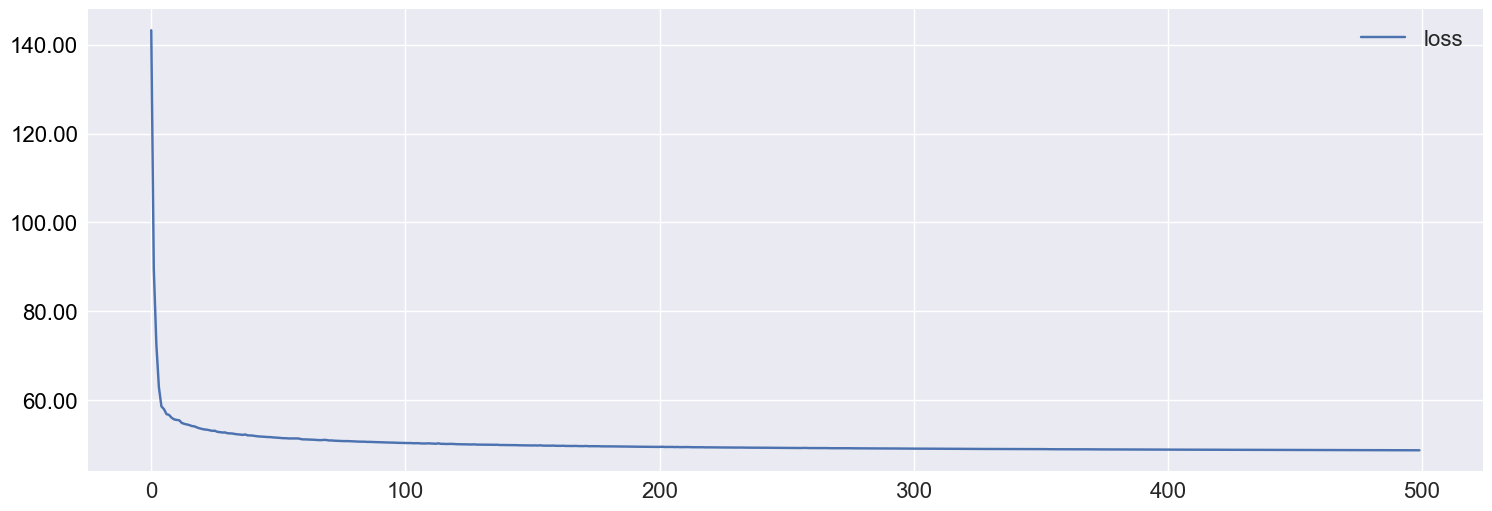

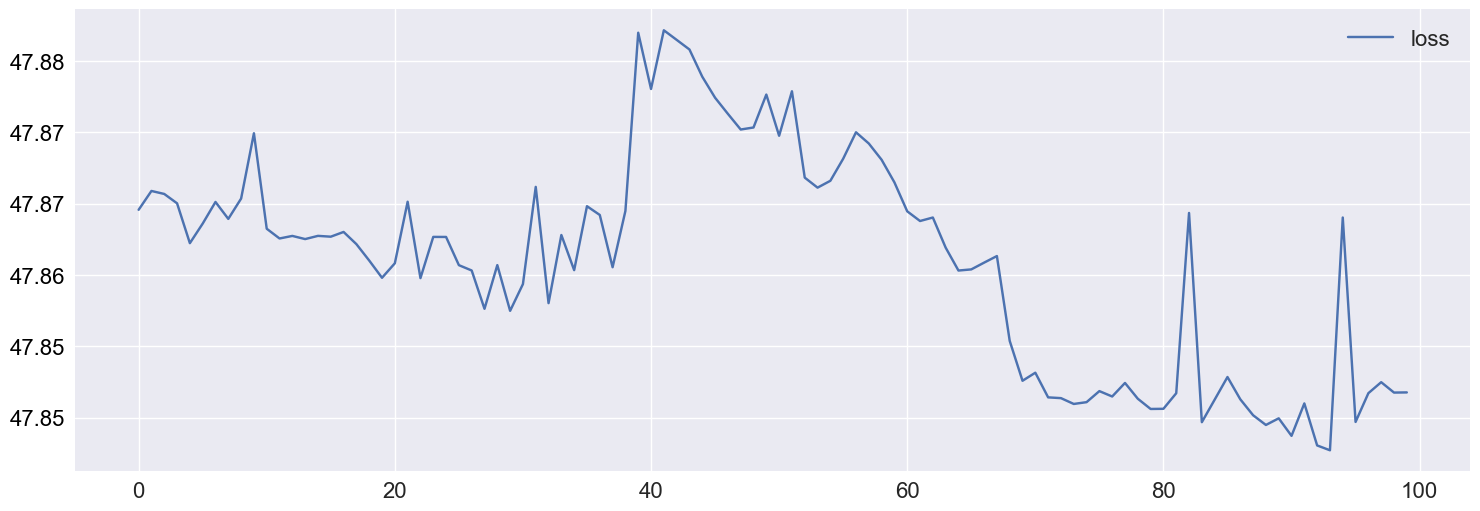

In [17]:
df_loss_i = pd.DataFrame(data = { "epoch": range(len(sfuvtf.history_i.history["loss"])), 
                                "loss":sfuvtf.history_i.history["loss"] })
bp.lineplot(df_loss_i, x ="epoch", y = "loss", figsize=(18,6) )

df_loss_t = pd.DataFrame(data = { "epoch": range(len(sfuvtf.history_t.history["loss"])), 
                                "loss":sfuvtf.history_t.history["loss"] })
bp.lineplot(df_loss_t, x ="epoch", y = "loss", figsize=(18,6) )

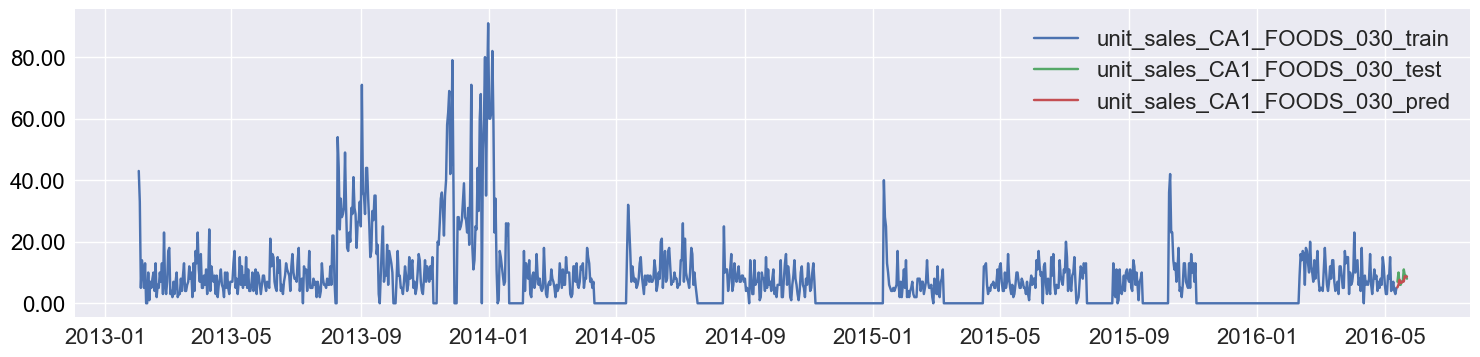

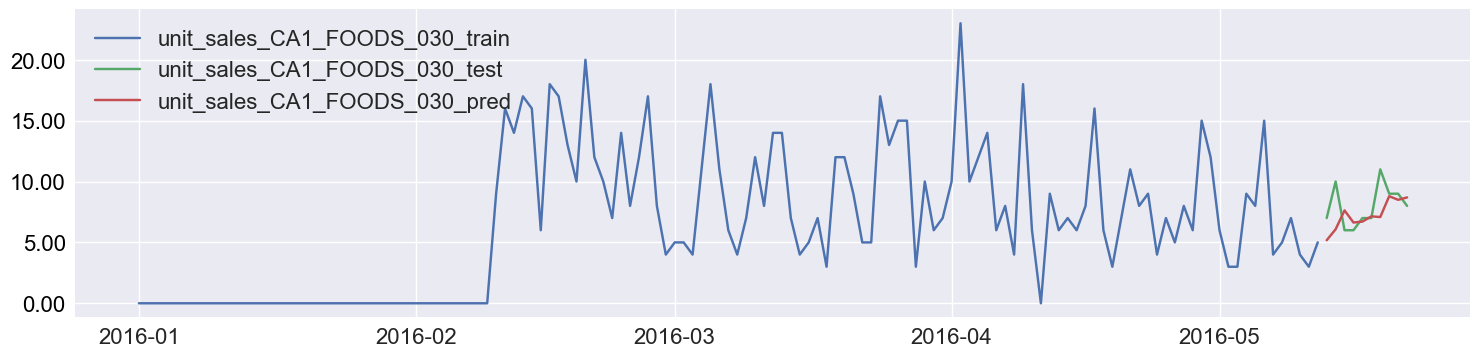

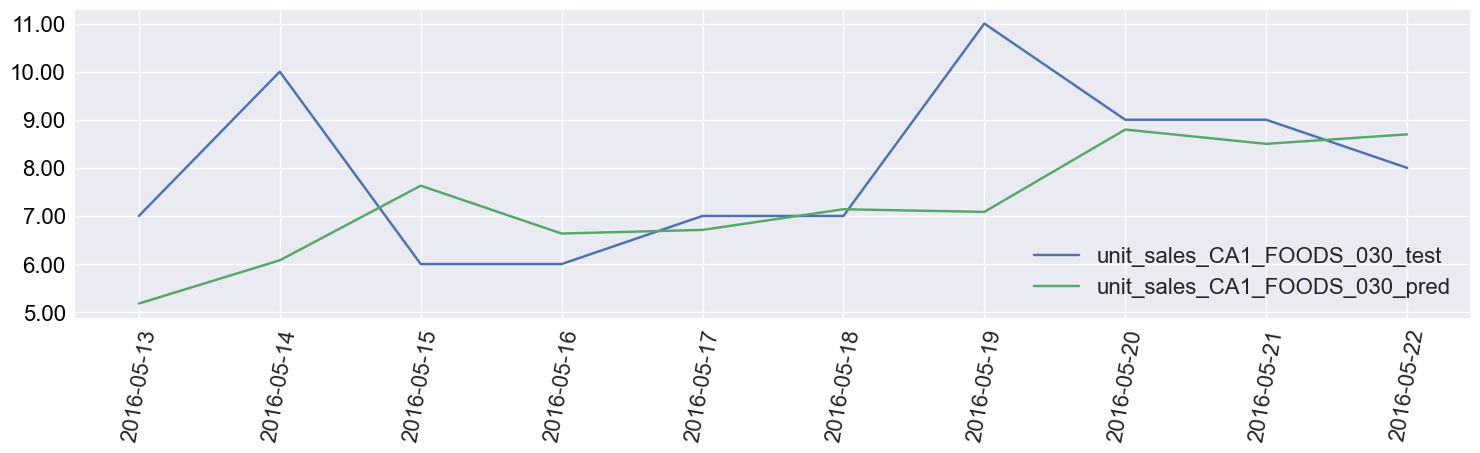

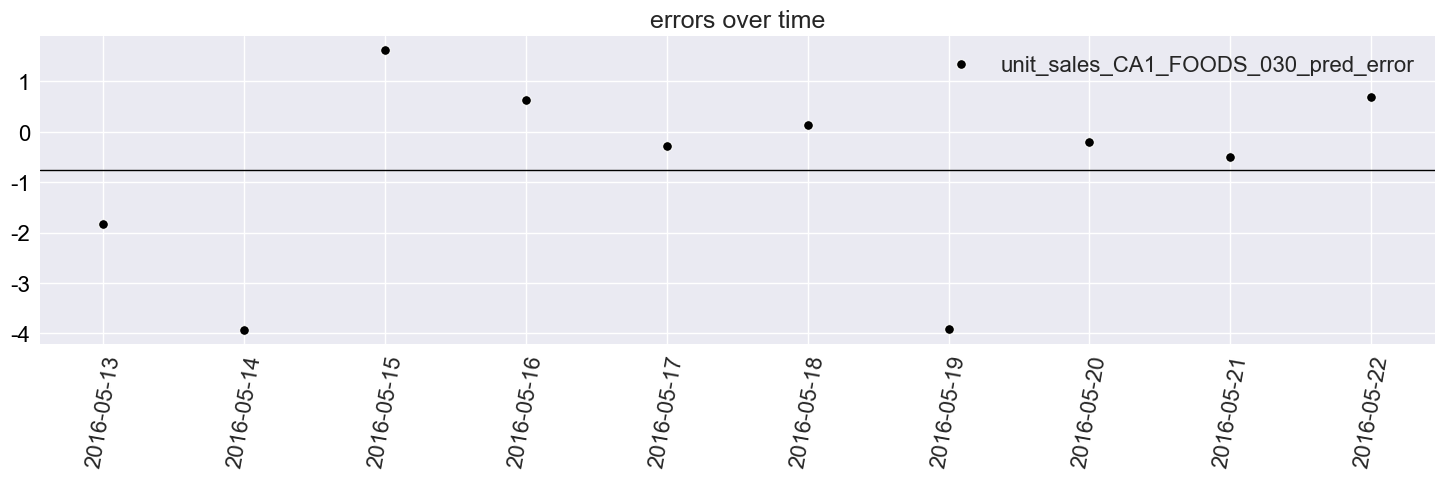

In [18]:
y = "unit_sales_CA1_FOODS_030"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"

df = dfXY_pred_uvtf.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

error_avg =df[error].mean()

bp.lineplot(df, x="date", y=[ytrain, ytest , ypred], figsize=(18,4))

d=datetime(2016,1,1)
bp.lineplot(df[df["date"]>=d], x="date", y=[ytrain, ytest , ypred], figsize=(18,4))

bp.lineplot(df.tail(30), x="date", y=[ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

bp.lineplot(df.tail(30), x="date", y=error,  h_line = [error_avg], 
            y_axis_format=".0f",linestyle="None", marker="o", color="k", 
            title = "errors over time", x_tick_rotation=80,  figsize=(18,4))

**Predict TF Univariate**

In [19]:
ts_period = pd.DateOffset(days=1)
#dfexogs=pd.DataFrame(data = {"dayofweek":[2,3,4,5,6]})
df_pred=sfuvtf.predict(Nperiods=3, ts_period=ts_period)
df_pred

1/1 [==============================] - 0s 24ms/step


unit_sales_CA1_FOODS_030_pred
2016-05-23                       8.345056
2016-05-24                       8.419456
2016-05-25                       8.286029

### Univariate with Exogenous

NTest = 0

In [51]:
# display data
print("dfXYtf")
display(dfXYtf.tail())

# compile again to ensure model is initialized w/o training
optimizer = Adam(learning_rate=0.05, decay=.1)
model_tf_dense.compile(loss='mse', optimizer=optimizer)

# Forecast - fit
Ntest=0
Nhorizon = 1
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":Nlags,
    "minmax" :(0,None)
    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 100,
    "batch_size":100
    }

sfuvtf = sf.sforecast(y = y, model_type="tf", swin_parameters=swin_params,model=model_tf_dense, tf_parameters=tf_params)

df_pred_uv = sfuvtf.fit(dfXYtf)

print(f'\nmetrics = {sfuvtf.metrics}')
dfXY_pred_uvtf = dfXYtf.join(df_pred_uv)
display(dfXY_pred_uvtf.tail())


dfXYtf


unit_sales_CA_1_FOODS_3_FOODS_3_030
date                                           
2016-05-18                                  7.0
2016-05-19                                 11.0
2016-05-20                                  9.0
2016-05-21                                  9.0
2016-05-22                                  8.0


metrics = {'unit_sales_CA_1_FOODS_3_FOODS_3_030_pred': {'RMSE': nan, 'MAE': nan}}


unit_sales_CA_1_FOODS_3_FOODS_3_030  \
date                                              
2016-05-18                                  7.0   
2016-05-19                                 11.0   
2016-05-20                                  9.0   
2016-05-21                                  9.0   
2016-05-22                                  8.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_030_train  \
date                                                    
2016-05-18                                        7.0   
2016-05-19                                       11.0   
2016-05-20                                        9.0   
2016-05-21                                        9.0   
2016-05-22                                        8.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_030_test  \
date                                                   
2016-05-18                                       NaN   
2016-05-19                                       NaN   
2016-05-20                                       NaN   
2016-05-21                                       NaN   
2016-05-22                                       NaN   

            unit_sales_CA_1_FOODS_3_FOODS_3_030_pred  \
date                                                   
2016-05-18                                       NaN   
2016-05-19                                       NaN   
2016-05-20                                       NaN   
2016-05-21                                       NaN   
2016-05-22                                       NaN   

            unit_sales_CA_1_FOODS_3_FOODS_3_030_pred_error  \
date                                                         
2016-05-18                                             NaN   
2016-05-19                                             NaN   
2016-05-20                                             NaN   
2016-05-21                                             NaN   
2016-05-22                                             NaN   

            unit_sales_CA_1_FOODS_3_FOODS_3_030_pred_lower  \
date                                                         
2016-05-18                                             NaN   
2016-05-19                                             NaN   
2016-05-20                                             NaN   
2016-05-21                                             NaN   
2016-05-22                                             NaN   

            unit_sales_CA_1_FOODS_3_FOODS_3_030_pred_upper  
date                                                        
2016-05-18                                             NaN  
2016-05-19                                             NaN  
2016-05-20                                             NaN  
2016-05-21                                             NaN  
2016-05-22                                             NaN

### Univariate + Categorical Variables

data

In [52]:
# y forecast variable
y = ["unit_sales_CA_1_FOODS_3_FOODS_3_030"]
dfXYtf = dfXY[y+le_catvars]
display(dfXYtf.tail(10))

unit_sales_CA_1_FOODS_3_FOODS_3_030  le_weekday  le_event_name_1  \
date                                                                           
2016-05-13                                  7.0           5               30   
2016-05-14                                 10.0           6               30   
2016-05-15                                  6.0           0               30   
2016-05-16                                  6.0           1               30   
2016-05-17                                  7.0           2               30   
2016-05-18                                  7.0           3               30   
2016-05-19                                 11.0           4               30   
2016-05-20                                  9.0           5               30   
2016-05-21                                  9.0           6               30   
2016-05-22                                  8.0           0               30   

            le_event_name_2  
date                         
2016-05-13                3  
2016-05-14                3  
2016-05-15                3  
2016-05-16                3  
2016-05-17                3  
2016-05-18                3  
2016-05-19                3  
2016-05-20                3  
2016-05-21                3  
2016-05-22                3

TF Model with Univariate + Categorical  
Dense Network (Xlags = univariate lags) + Embeddings (Categorical Variables)

In [53]:
# TensorFlow model ... Categorical Embeddings + Dense (Continuous Variables)
Nlags = 2
Nconts = Nlags * Ncovars + Nexogvars # in general, lagged covars (does not include unlagged covars) + exogvars
Ndense = Nlags  # N continous/dense variables, in this case covars is 1 (univarate)
Nembout = sum(eoutdim)

# Dense Network, 2 hidden layers, continuous variables ... covar lags and exogenous variables
cont_inputs = Input((Ndense,))
h1c = Dense(Ndense, activation='relu')(cont_inputs)


# embeddings, cat vars

cat_inputs_list = [ Input((1,)) for c in range(Ncatvars) ]  # one embedding for each categorical variable
emb_out_list = [Embedding(ein,eout,input_length=1)(cat) for ein,eout,cat in zip(eindim ,eoutdim,cat_inputs_list) ]
emb_flat_list = [Flatten()(emb_out) for emb_out in emb_out_list ]

# combined 
combined = concatenate([h1c]+emb_flat_list)

# dense reduction layers
Nh1_comb = Ndense + Nembout  # 
h1_comb = Dense(Nh1_comb, activation='relu')(combined)
Nh2_comb = np.rint(Nh1_comb/2).astype(int)
h2_comb = Dense(Nh2_comb, activation='relu')(h1_comb)

# output
output = Dense(1)(h2_comb)  # linear activation ... linear combination 

# build model
model_tf_dense_emb = Model(inputs=[cont_inputs, cat_inputs_list], outputs=output)

# define optimizer and compile ...
optimizer = Adam(learning_rate=0.05, decay=.1)
model_tf_dense_emb.compile(loss='mse', optimizer=optimizer)
print(model_tf_dense_emb.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                            

TF Forecast-Fit Univariate + Categorical

In [54]:

# display data
print("dfXYtf")
display(dfXYtf.tail(5))

# define optimizer and compile ...
# re-compile every time before running to ensure initial training is really the first
optimizer = Adam(learning_rate=0.05, decay=.1)
model_tf_dense_emb.compile(loss='mse', optimizer=optimizer)

# Forcast Fit

Ntest = 10
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":1,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "catvars":le_catvars 
    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}

sftfuvc = sf.sforecast(y = y, model_type="tf", swin_parameters=swin_params,model=model_tf_dense_emb, tf_parameters=tf_params)

df_pred_ccm5 = sftfuvc.fit(dfXYtf)

print(f'\nmetrics = {sftfuvc.metrics}')
dfXY_pred_ccm5 = dfXY.join(df_pred_ccm5)
display(dfXY_pred_ccm5.tail())


dfXYtf


unit_sales_CA_1_FOODS_3_FOODS_3_030  le_weekday  le_event_name_1  \
date                                                                           
2016-05-18                                  7.0           3               30   
2016-05-19                                 11.0           4               30   
2016-05-20                                  9.0           5               30   
2016-05-21                                  9.0           6               30   
2016-05-22                                  8.0           0               30   

            le_event_name_2  
date                         
2016-05-18                3  
2016-05-19                3  
2016-05-20                3  
2016-05-21                3  
2016-05-22                3

1/1 [==============================] - 0s 30ms/step

metrics = {'unit_sales_CA_1_FOODS_3_FOODS_3_030_pred': {'RMSE': 2.3026769953321806, 'MAE': 1.9842299222946167}}


unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416  \
date                                                      
2016-05-18                                          2.0   
2016-05-19                                          2.0   
2016-05-20                                          1.0   
2016-05-21                                          0.0   
2016-05-22                                          3.0   

            unit_sales_CA_1_FOODS_2_FOODS_2_044  \
date                                              
2016-05-18                                  0.0   
2016-05-19                                  0.0   
2016-05-20                                  0.0   
2016-05-21                                  3.0   
2016-05-22                                  2.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_030  \
date                                              
2016-05-18                                  7.0   
2016-05-19                                 11.0   
2016-05-20                                  9.0   
2016-05-21                                  9.0   
2016-05-22                                  8.0   

            unit_sales_CA_1_HOBBIES_1_HOBBIES_1_418  \
date                                                  
2016-05-18                                      1.0   
2016-05-19                                      1.0   
2016-05-20                                      4.0   
2016-05-21                                      0.0   
2016-05-22                                      0.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_185  \
date                                              
2016-05-18                                  4.0   
2016-05-19                                  1.0   
2016-05-20                                  1.0   
2016-05-21                                  2.0   
2016-05-22                                  2.0   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_219  \
date                                                      
2016-05-18                                          0.0   
2016-05-19                                          0.0   
2016-05-20                                          0.0   
2016-05-21                                          2.0   
2016-05-22                                          1.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_393    weekday event_name_1  \
date                                                                      
2016-05-18                                  5.0  Wednesday          NaN   
2016-05-19                                  8.0   Thursday          NaN   
2016-05-20                                  5.0     Friday          NaN   
2016-05-21                                  5.0   Saturday          NaN   
2016-05-22                                 15.0     Sunday          NaN   

           event_name_2  ...   CCI_USA  le_event_name_1  le_event_name_2  \
date                     ...                                               
2016-05-18          NaN  ...  100.7612               30                3   
2016-05-19          NaN  ...  100.7612               30                3   
2016-05-20          NaN  ...  100.7612               30                3   
2016-05-21          NaN  ...  100.7612               30                3   
2016-05-22          NaN  ...  100.7612               30                3   

            le_weekday  unit_sales_CA_1_FOODS_3_FOODS_3_030_train  \
date                                                                
2016-05-18           3                                        NaN   
2016-05-19           4                                        NaN   
2016-05-20           5                                        NaN   
2016-05-21           6                                        NaN   
2016-05-22           0                                        NaN   

            unit_sales_CA_1_FOODS_3_FOODS_3_030_test  \
date                                                   
2016-05-18                                       7.0   
2016-05-19   

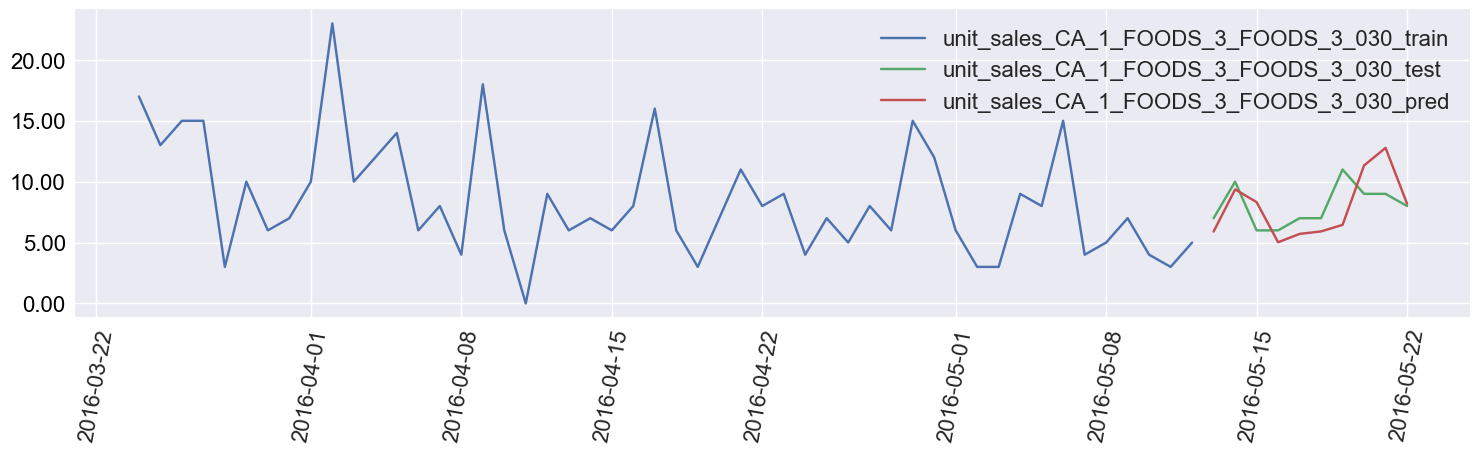

In [9]:
y = "unit_sales_CA_1_FOODS_3_FOODS_3_030"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"

df = dfXY_pred_ccm5.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

Predict

In [55]:
ts_period = pd.DateOffset(days=1)
dfcats=pd.DataFrame(data = {"le_weekday":[1,2,3,4,5], "le_event_name_1": 5*[30], "le_event_name_2": 5 *[3]})
df_pred=sftfuvc.predict(Nperiods=5, dfcats = dfcats, ts_period=ts_period)
df_pred

1/1 [==============================] - 0s 28ms/step


unit_sales_CA_1_FOODS_3_FOODS_3_030_pred
2016-05-23                                  4.200222
2016-05-24                                  1.862334
2016-05-25                                  0.447099
2016-05-26                                  0.447099
2016-05-27                                  0.447099

### Multivariate with Exogenous, and Categorical Variables

data

In [4]:
# unit_sales_CA_1_FOODS_2_FOODS_2_044
# unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416
# unit_sales_CA_1_FOODS_3_FOODS_3_393
# y forecast variable

dfXYtf = dfXY[covars+exogvars+le_catvars].copy()
print(catvars)
print(exogvars)
print(dfXYtf.shape)
display(dfXYtf.tail(5))

['weekday', 'event_name_1', 'event_name_2']
['year', 'month', 'week', 'snap_CA', 'CCI_USA']
(1206, 15)


unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416  \
date                                                      
2016-05-18                                          2.0   
2016-05-19                                          2.0   
2016-05-20                                          1.0   
2016-05-21                                          0.0   
2016-05-22                                          3.0   

            unit_sales_CA_1_FOODS_2_FOODS_2_044  \
date                                              
2016-05-18                                  0.0   
2016-05-19                                  0.0   
2016-05-20                                  0.0   
2016-05-21                                  3.0   
2016-05-22                                  2.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_030  \
date                                              
2016-05-18                                  7.0   
2016-05-19                                 11.0   
2016-05-20                                  9.0   
2016-05-21                                  9.0   
2016-05-22                                  8.0   

            unit_sales_CA_1_HOBBIES_1_HOBBIES_1_418  \
date                                                  
2016-05-18                                      1.0   
2016-05-19                                      1.0   
2016-05-20                                      4.0   
2016-05-21                                      0.0   
2016-05-22                                      0.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_185  \
date                                              
2016-05-18                                  4.0   
2016-05-19                                  1.0   
2016-05-20                                  1.0   
2016-05-21                                  2.0   
2016-05-22                                  2.0   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_219  \
date                                                      
2016-05-18                                          0.0   
2016-05-19                                          0.0   
2016-05-20                                          0.0   
2016-05-21                                          2.0   
2016-05-22                                          1.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_393  year  month  week  snap_CA  \
date                                                                          
2016-05-18                                  5.0  2016      5    20        0   
2016-05-19                                  8.0  2016      5    20        0   
2016-05-20                                  5.0  2016      5    20        0   
2016-05-21                                  5.0  2016      5    20        0   
2016-05-22                                 15.0  2016      5    20        0   

             CCI_USA  le_weekday  le_event_name_1  le_event_name_2  
date                                                                
2016-05-18  100.7612           3               30                3  
2016-05-19  100.7612           4               30                3  
2016-05-20  100.7612           5               30                3  
2016-05-21  100.7612           6               30                3  
2016-05-22  100.7612           0               30                3

TF Model - Dense (exog + covariate lags) + Embeddings (categorical variables) + Nout = len(covars)

In [5]:
# TensorFlow model ... Categorical Embeddings + Dense (Continuous Variables), Multiple Ouput
Nlags = 5
Ndense = Nlags * Ncovars + Nexogvars #lagged covars (does not include unlagged covars) + exogvars
Nemb = Ncatvars
Nembout = sum(eoutdim)
Nout = len(covars)

print(f'Ndense = {Ndense}')
print(f'Nemb = {Nemb}')
print(f'Nout = {Nout}')

# Dense Network, 2 hidden layers, continuous variables ... covar lags and exogenous variables
cont_inputs = Input((Ndense,))
h1d = Dense(Ndense, activation='relu')(cont_inputs)

# embeddings, cat vars
cat_inputs_list = [ Input((1,)) for c in range(Nemb) ]  # one embedding for each categorical variable
emb_out_list = [Embedding(ein,eout,input_length=1)(cat) for ein,eout,cat in zip(eindim ,eoutdim,cat_inputs_list) ]
emb_flat_list = [Flatten()(emb_out) for emb_out in emb_out_list ]

# combined 
combined = concatenate([h1d]+emb_flat_list)
combined_d = Dropout(0.2)(combined)

# dense reduction layers
Nh1c = Ndense + Nembout # 
h1c = Dense(Nh1c, activation='relu')(combined_d)
h1c_d = Dropout(0.2)(h1c)
Nh2c = np.rint(Nh1c/2).astype(int)
h2c = Dense(Nh2c, activation='relu')(h1c_d)
h2c_d = Dropout(0.2)(h2c)

# output
output = Dense(Nout)(h2c_d)  # linear activation ... linear combination 
model_tf_dense_emb = Model(inputs=[cont_inputs, cat_inputs_list], outputs=output)

# define optimizer and compile ...
optimizer = Adam(learning_rate=0.05, decay=.1)
model_tf_dense_emb.compile(loss='mse', optimizer=optimizer)

print(model_tf_dense_emb.summary())

Ndense = 40
Nemb = 3
Nout = 7
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                

2023-01-11 15:58:57.004509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 dropout (Dropout)              (None, 50)           0           ['concatenate[0][0]']            
                                                                                                  
 dense_1 (Dense)                (None, 50)           2550        ['dropout[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 50)           0           ['dense_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 25)           1275        ['dropout_1[0][0]']              
                                                                                                  
 dropout_2 (Dropout)            (None, 25)           0           ['dense_2[0][0]']                
                                                                                                  
 dense_3 (

Forecast Fit Multivariate with Exogenous and Catvars

In [6]:
# display data
# display data
print("dfXYtf")
display(dfXYtf.tail(5))

y = ["unit_sales_CA_1_FOODS_3_FOODS_3_030", "unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416" ,  "unit_sales_CA_1_FOODS_3_FOODS_3_393" ]
print(f'\ny = {y}\n')

# define optimizer and compile ... compile again to make sure it is a fresh non-trained model prior to fit
optimizer = Adam(learning_rate=0.05, decay=.1)
model_tf_dense_emb.compile(loss='mse', optimizer=optimizer)

# forecast fit
Ntest = 10
Nhorizon = 1
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "covars":covars,
    "exogvars":exogvars,
    "catvars":le_catvars

    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}


sfmvembmo = sf.sforecast(y = y, model_type="tf", swin_parameters=swin_params,model=model_tf_dense_emb, tf_parameters=tf_params)

df_pred_mvcatmo = sfmvembmo.fit(dfXYtf)

print(f'\nmetrics = {sfmvembmo.metrics}')
dfXY_pred_mvcatmo = dfXYtf.join(df_pred_mvcatmo)
display(dfXY_pred_mvcatmo.tail())

dfXYtf


unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416  \
date                                                      
2016-05-18                                          2.0   
2016-05-19                                          2.0   
2016-05-20                                          1.0   
2016-05-21                                          0.0   
2016-05-22                                          3.0   

            unit_sales_CA_1_FOODS_2_FOODS_2_044  \
date                                              
2016-05-18                                  0.0   
2016-05-19                                  0.0   
2016-05-20                                  0.0   
2016-05-21                                  3.0   
2016-05-22                                  2.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_030  \
date                                              
2016-05-18                                  7.0   
2016-05-19                                 11.0   
2016-05-20                                  9.0   
2016-05-21                                  9.0   
2016-05-22                                  8.0   

            unit_sales_CA_1_HOBBIES_1_HOBBIES_1_418  \
date                                                  
2016-05-18                                      1.0   
2016-05-19                                      1.0   
2016-05-20                                      4.0   
2016-05-21                                      0.0   
2016-05-22                                      0.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_185  \
date                                              
2016-05-18                                  4.0   
2016-05-19                                  1.0   
2016-05-20                                  1.0   
2016-05-21                                  2.0   
2016-05-22                                  2.0   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_219  \
date                                                      
2016-05-18                                          0.0   
2016-05-19                                          0.0   
2016-05-20                                          0.0   
2016-05-21                                          2.0   
2016-05-22                                          1.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_393  year  month  week  snap_CA  \
date                                                                          
2016-05-18                                  5.0  2016      5    20        0   
2016-05-19                                  8.0  2016      5    20        0   
2016-05-20                                  5.0  2016      5    20        0   
2016-05-21                                  5.0  2016      5    20        0   
2016-05-22                                 15.0  2016      5    20        0   

             CCI_USA  le_weekday  le_event_name_1  le_event_name_2  
date                                                                
2016-05-18  100.7612           3               30                3  
2016-05-19  100.7612           4               30                3  
2016-05-20  100.7612           5               30                3  
2016-05-21  100.7612           6               30                3  
2016-05-22  100.7612           0               30                3


y = ['unit_sales_CA_1_FOODS_3_FOODS_3_030', 'unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416', 'unit_sales_CA_1_FOODS_3_FOODS_3_393']

1/1 [==============================] - 0s 33ms/step

metrics = {'unit_sales_CA_1_FOODS_3_FOODS_3_030_pred': {'RMSE': 2.828327483299029, 'MAE': 2.1426422595977783}, 'unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_pred': {'RMSE': 1.3207560450451754, 'MAE': 1.144252598285675}, 'unit_sales_CA_1_FOODS_3_FOODS_3_393_pred': {'RMSE': 4.452468905616103, 'MAE': 3.487637448310852}}


unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416  \
date                                                      
2016-05-18                                          2.0   
2016-05-19                                          2.0   
2016-05-20                                          1.0   
2016-05-21                                          0.0   
2016-05-22                                          3.0   

            unit_sales_CA_1_FOODS_2_FOODS_2_044  \
date                                              
2016-05-18                                  0.0   
2016-05-19                                  0.0   
2016-05-20                                  0.0   
2016-05-21                                  3.0   
2016-05-22                                  2.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_030  \
date                                              
2016-05-18                                  7.0   
2016-05-19                                 11.0   
2016-05-20                                  9.0   
2016-05-21                                  9.0   
2016-05-22                                  8.0   

            unit_sales_CA_1_HOBBIES_1_HOBBIES_1_418  \
date                                                  
2016-05-18                                      1.0   
2016-05-19                                      1.0   
2016-05-20                                      4.0   
2016-05-21                                      0.0   
2016-05-22                                      0.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_185  \
date                                              
2016-05-18                                  4.0   
2016-05-19                                  1.0   
2016-05-20                                  1.0   
2016-05-21                                  2.0   
2016-05-22                                  2.0   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_219  \
date                                                      
2016-05-18                                          0.0   
2016-05-19                                          0.0   
2016-05-20                                          0.0   
2016-05-21                                          2.0   
2016-05-22                                          1.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_393  year  month  week  ...  \
date                                                                ...   
2016-05-18                                  5.0  2016      5    20  ...   
2016-05-19                                  8.0  2016      5    20  ...   
2016-05-20                                  5.0  2016      5    20  ...   
2016-05-21                                  5.0  2016      5    20  ...   
2016-05-22                                 15.0  2016      5    20  ...   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_pred  \
date                                                           
2016-05-18                                          1.382064   
2016-05-19                                          1.364235   
2016-05-20                                          1.398126   
2016-05-21                                          1.480996   
2016-05-22                                          1.370068   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_pred_error  \
date                                                                 
2016-05-18                                          -0.617936        
2016-05-19                                          -0.635765        
2016-05-20                                           0.398126        
2016-05-21                                           1.480996        
2016-05-22                                          -1.629932        

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_pred_lower  \
date                                                                 
2016-05-18                                                0.0        
2016-05-19                                      

Plot

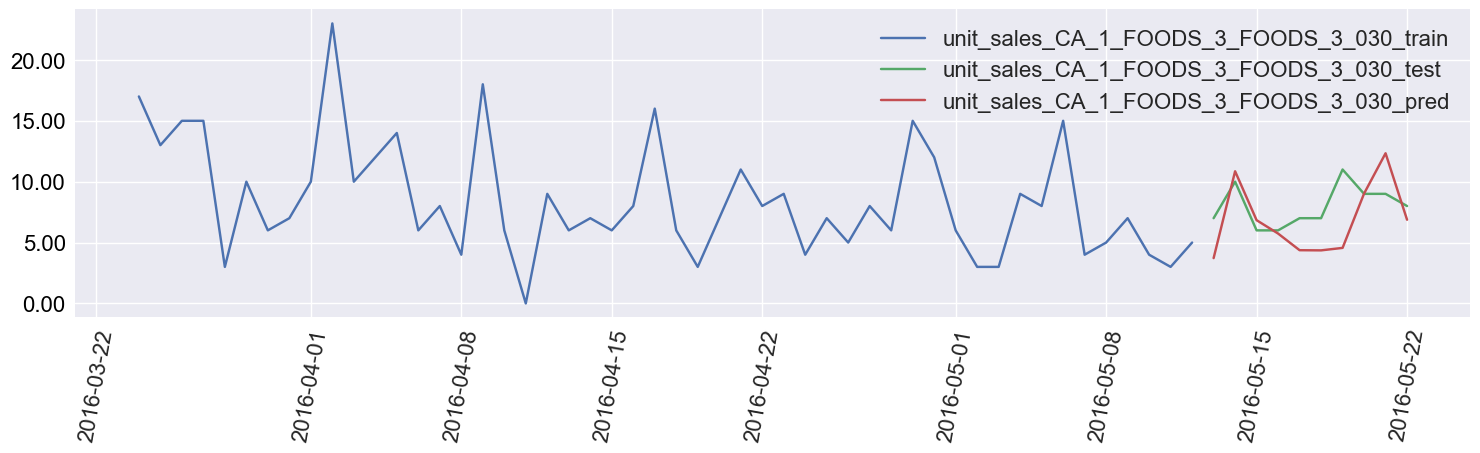

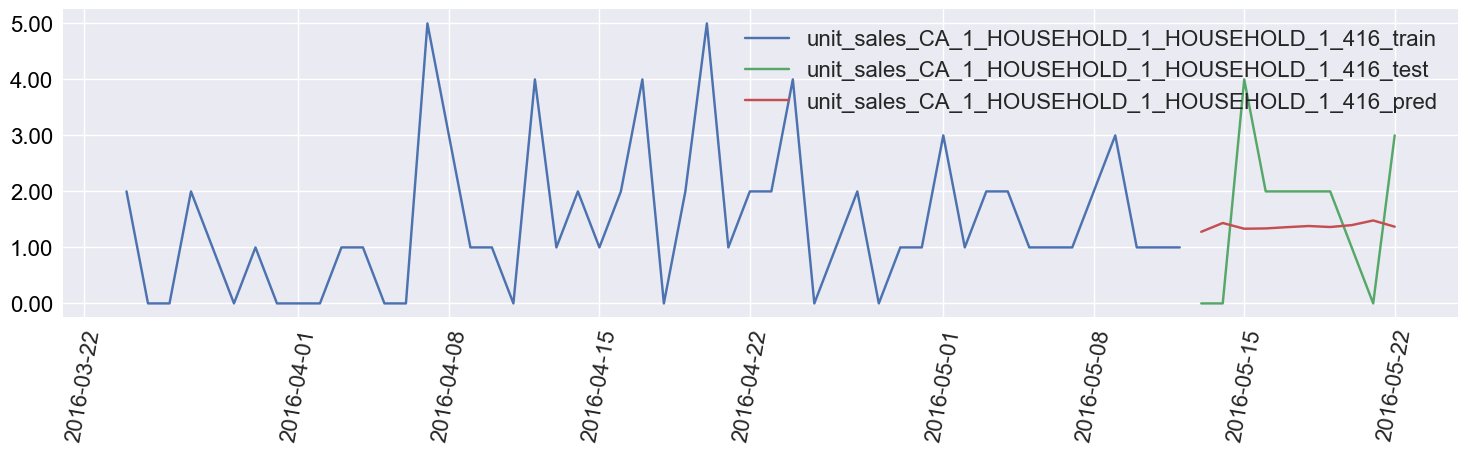

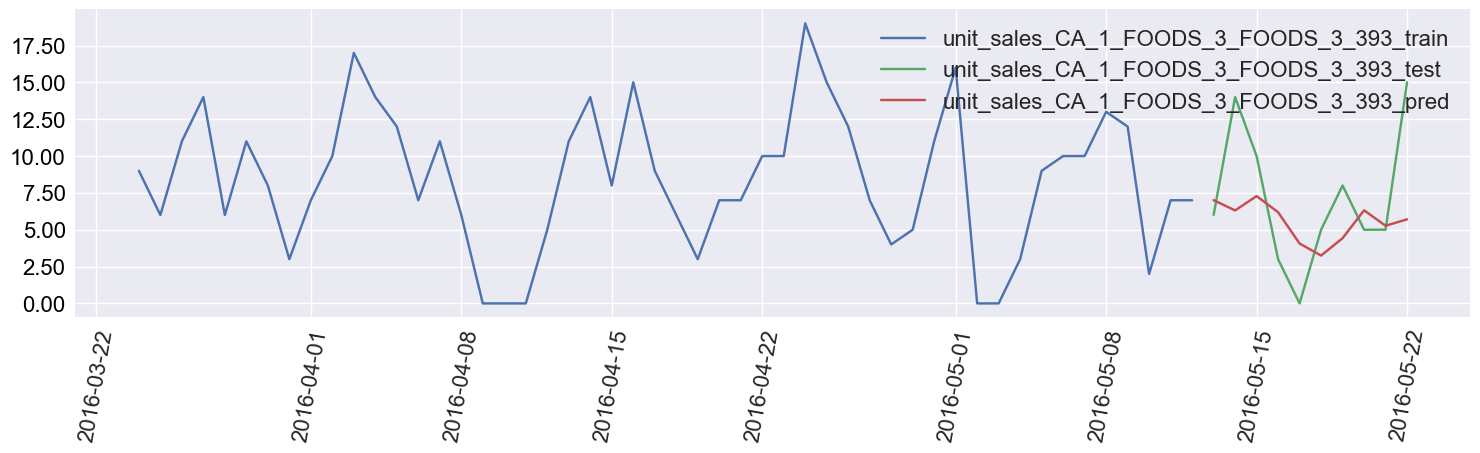

In [7]:


df = dfXY_pred_mvcatmo.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

y = "unit_sales_CA_1_FOODS_3_FOODS_3_030"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"


bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

y = "unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"


bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)


y = "unit_sales_CA_1_FOODS_3_FOODS_3_393"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"


bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)


Predict multivariate with exogenous and categorical

In [9]:
ts_period = pd.DateOffset(days=1)
dfexogs=pd.DataFrame(data = {"year":5*[2016],
                             "month": 5*[5],
                             "week": 5*[21],
                             "snap_CA": 5*[0],
                             "CCI_USA":5*[100.7612]
                             })

dfcats=pd.DataFrame(data = {"le_weekday":[1,2,3,4,5], "le_event_name_1": 5*[30], "le_event_name_2": 5 *[3]})
df_pred=sfmvembmo.predict(Nperiods=3,dfexogs = dfexogs, dfcats = dfcats, ts_period=ts_period)
df_pred

1/1 [==============================] - 0s 30ms/step


unit_sales_CA_1_FOODS_3_FOODS_3_030_pred  \
2016-05-23                                  6.392816   
2016-05-24                                  5.576924   
2016-05-25                                  5.367697   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_pred  \
2016-05-23                                          1.349681   
2016-05-24                                          1.354487   
2016-05-25                                          1.358579   

            unit_sales_CA_1_FOODS_3_FOODS_3_393_pred  
2016-05-23                                  6.192396  
2016-05-24                                  5.367126  
2016-05-25                                  5.073748

### Multivariate with Exogenous, Endogenous, and Categorical

data

In [63]:
# same data as previous multivariate example

dfXYtf = dfXY[covars+exogvars+le_catvars].copy()
print(catvars)
print(exogvars)
print(dfXYtf.shape)
display(dfXYtf.tail(10))

['weekday', 'event_name_1', 'event_name_2']
['year', 'month', 'week', 'snap_CA', 'CCI_USA']
(1206, 15)


unit_sales_CA1_HOUSEHOLD_416  unit_sales_CA1_FOODS_044  \
date                                                                 
2016-05-13                           0.0                       2.0   
2016-05-14                           0.0                       1.0   
2016-05-15                           4.0                       1.0   
2016-05-16                           2.0                       2.0   
2016-05-17                           2.0                       4.0   
2016-05-18                           2.0                       0.0   
2016-05-19                           2.0                       0.0   
2016-05-20                           1.0                       0.0   
2016-05-21                           0.0                       3.0   
2016-05-22                           3.0                       2.0   

            unit_sales_CA1_FOODS_030  unit_sales_CA1_HOBBIES_418  \
date                                                               
2016-05-13                       7.0                         2.0   
2016-05-14                      10.0                         0.0   
2016-05-15                       6.0                         0.0   
2016-05-16                       6.0                         1.0   
2016-05-17                       7.0                         1.0   
2016-05-18                       7.0                         1.0   
2016-05-19                      11.0                         1.0   
2016-05-20                       9.0                         4.0   
2016-05-21                       9.0                         0.0   
2016-05-22                       8.0                         0.0   

            unit_sales_CA1_FOODS_185  unit_sales_CA1_HOUSEHOLD_219  \
date                                                                 
2016-05-13                       1.0                           0.0   
2016-05-14                       6.0                           1.0   
2016-05-15                       3.0                           1.0   
2016-05-16                       0.0                           1.0   
2016-05-17                       1.0                           0.0   
2016-05-18                       4.0                           0.0   
2016-05-19                       1.0                           0.0   
2016-05-20                       1.0                           0.0   
2016-05-21                       2.0                           2.0   
2016-05-22                       2.0                           1.0   

            unit_sales_CA1_FOODS_393  year  month  week  snap_CA   CCI_USA  \
date                                                                         
2016-05-13                       6.0  2016      5    19        0  100.7612   
2016-05-14                      14.0  2016      5    19        0  100.7612   
2016-05-15                      10.0  2016      5    19        0  100.7612   
2016-05-16                       3.0  2016      5    20        0  100.7612   
2016-05-17                       0.0  2016      5    20        0  100.7612   
2016-05-18                       5.0  2016      5    20        0  100.7612   
2016-05-19                       8.0  2016      5    20        0  100.7612   
2016-05-20                       5.0  2016      5    20        0  100.7612   
2016-05-21                       5.0  2016      5    20        0  100.7612   
2016-05-22                      15.0  2016      5    20        0  100.7612   

            le_weekday  le_event_name_1  le_event_name_2  
date                                                      
2016-05-13           5               30                3  
2016-05-14           6               30                3  
2016-05-15           0               30                3  
2016-05-16           1               30                3  
2016-05-17           2               30                3  
2016-05-18           3               30                3  
2016-05-19           4               30                3  
2016-05-20           5               30      

Endogenous (derived) Attributes

In [64]:
# deirvied variables transform

# derived attributes custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

# pipeline/transformer development
# BaseEstimater ... get_params(), set_params() methods
# TransformerMixin ... fit_transform() method
Nr = 3
class derived_attributes_tf(BaseEstimator,TransformerMixin):
    def __init__(self, Nr = Nr): 
        self.Nr = Nr # slidig/rolling window rows
        self.dfmemory = None
        
        v1 = "unit_sales_CA1_FOODS_030"
        v2 = "unit_sales_CA1_HOUSEHOLD_416"
        v3 = "unit_sales_CA1_FOODS_393"
        self.vlist = [v1, v2, v3]
        f1 = lambda x:x+"_m1_ravg"+str(Nr)
        f2 = lambda x:x+"_m1_rstd"+str(Nr)
        self.new_attributes = [f(v) for f in (f1, f2 )for v in self.vlist]
    
    def fit(self,df):
        # ensure dataframe has enough rows
        self.dfmemory = df.tail(self.Nr) if df.index.size > self.Nr else df.index.size
                # variables
        
        return self
    
    def transform(self,df=None, Nout=None, dfnewrows=None):
        # if df not spefified then transform on dfmemory
        # add new row(s) ... these will be provided from the predict operation
        if not isinstance(df,pd.DataFrame):
            df = self.dfmemory
            if isinstance(dfnewrows,pd.DataFrame):
                df = pd.concat([df,dfnewrows])
        self.dfmemory = df.tail(self.Nr) 
        Nr=self.Nr
        dfnew=df.copy()
        
        for v in self.vlist:
            v_ravg = v+"_m1_ravg"+str(Nr)
            v_rstd =  v+"_m1_rstd"+str(Nr)
            v_m1 = v+"_m1"
            dfnew[v_ravg] = dfnew[v_m1].rolling(window=Nr).mean()
            dfnew[v_rstd] = dfnew[v_m1].rolling(window=Nr).std()

        Nclip = self.Nr
        return dfnew if Nout == None else dfnew.tail(Nout)
    
    def get_Nclip(self): # returns the number of initial rows that should be desgarded (clipped) for NaN avoidence
        return self.Nr
    
    def get_derived_attribute_names(self):
        Nr = self.Nr
        return self.new_attributes
 
cols = ["unit_sales_CA1_FOODS_030" , "unit_sales_CA1_HOUSEHOLD_416" , "unit_sales_CA1_FOODS_393"]        
dfXY_m1 = dfXYtf[cols].copy()


# the variables eill be created by sforecast
# here we test the transform to see what the new variables look like.
Nclip =derived_attributes_tf().get_Nclip()
print("Nclip =",Nclip)
drived_var_transform = derived_attributes_tf()
dfXY_m1[["unit_sales_CA1_FOODS_030_m1" , "unit_sales_CA1_HOUSEHOLD_416_m1" , "unit_sales_CA1_FOODS_393_m1" ]] = dfXY_m1[["unit_sales_CA1_FOODS_030" , "unit_sales_CA1_HOUSEHOLD_416" , "unit_sales_CA1_FOODS_393"]].shift(1)
dftest = drived_var_transform.fit_transform(dfXY_m1)
print("dataframe, dftest, with derived variables")
display(dftest.tail(5))

print(f'Nr= {Nr} dfmemory 3 rows from dataframe, saved by the transform after first use')
display(drived_var_transform.dfmemory)

new_attributes = drived_var_transform.get_derived_attribute_names()
print(f'\nnew_attribute_names = {new_attributes}')

Nclip = 3
dataframe, dftest, with derived variables


unit_sales_CA1_FOODS_030  unit_sales_CA1_HOUSEHOLD_416  \
date                                                                 
2016-05-18                       7.0                           2.0   
2016-05-19                      11.0                           2.0   
2016-05-20                       9.0                           1.0   
2016-05-21                       9.0                           0.0   
2016-05-22                       8.0                           3.0   

            unit_sales_CA1_FOODS_393  unit_sales_CA1_FOODS_030_m1  \
date                                                                
2016-05-18                       5.0                          7.0   
2016-05-19                       8.0                          7.0   
2016-05-20                       5.0                         11.0   
2016-05-21                       5.0                          9.0   
2016-05-22                      15.0                          9.0   

            unit_sales_CA1_HOUSEHOLD_416_m1  unit_sales_CA1_FOODS_393_m1  \
date                                                                       
2016-05-18                              2.0                          0.0   
2016-05-19                              2.0                          5.0   
2016-05-20                              2.0                          8.0   
2016-05-21                              1.0                          5.0   
2016-05-22                              0.0                          5.0   

            unit_sales_CA1_FOODS_030_m1_ravg3  \
date                                            
2016-05-18                           6.333333   
2016-05-19                           6.666667   
2016-05-20                           8.333333   
2016-05-21                           9.000000   
2016-05-22                           9.666667   

            unit_sales_CA1_FOODS_030_m1_rstd3  \
date                                            
2016-05-18                           0.577350   
2016-05-19                           0.577350   
2016-05-20                           2.309401   
2016-05-21                           2.000000   
2016-05-22                           1.154701   

            unit_sales_CA1_HOUSEHOLD_416_m1_ravg3  \
date                                                
2016-05-18                               2.666667   
2016-05-19                               2.000000   
2016-05-20                               2.000000   
2016-05-21                               1.666667   
2016-05-22                               1.000000   

            unit_sales_CA1_HOUSEHOLD_416_m1_rstd3  \
date                                                
2016-05-18                               1.154701   
2016-05-19                               0.000000   
2016-05-20                               0.000000   
2016-05-21                               0.577350   
2016-05-22                               1.000000   

            unit_sales_CA1_FOODS_393_m1_ravg3  \
date                                            
2016-05-18                           4.333333   
2016-05-19                           2.666667   
2016-05-20                           4.333333   
2016-05-21                           6.000000   
2016-05-22                           6.000000   

            unit_sales_CA1_FOODS_393_m1_rstd3  
date                                           
2016-05-18                           5.131601  
2016-05-19                           2.516611  
2016-05-20                           4.041452  
2016-05-21                           1.732051  
2016-05-22                           1.732051

Nr= 3 dfmemory 3 rows from dataframe, saved by the transform after first use


unit_sales_CA1_FOODS_030  unit_sales_CA1_HOUSEHOLD_416  \
date                                                                 
2016-05-20                       9.0                           1.0   
2016-05-21                       9.0                           0.0   
2016-05-22                       8.0                           3.0   

            unit_sales_CA1_FOODS_393  unit_sales_CA1_FOODS_030_m1  \
date                                                                
2016-05-20                       5.0                         11.0   
2016-05-21                       5.0                          9.0   
2016-05-22                      15.0                          9.0   

            unit_sales_CA1_HOUSEHOLD_416_m1  unit_sales_CA1_FOODS_393_m1  
date                                                                      
2016-05-20                              2.0                          8.0  
2016-05-21                              1.0                          5.0  
2016-05-22                              0.0                          5.0


new_attribute_names = ['unit_sales_CA1_FOODS_030_m1_ravg3', 'unit_sales_CA1_HOUSEHOLD_416_m1_ravg3', 'unit_sales_CA1_FOODS_393_m1_ravg3', 'unit_sales_CA1_FOODS_030_m1_rstd3', 'unit_sales_CA1_HOUSEHOLD_416_m1_rstd3', 'unit_sales_CA1_FOODS_393_m1_rstd3']


In [65]:
# TensorFlow model ... Categorical Embeddings + Dense (Continuous Variables), Multiple Ouput
Nlags = 5
Nendogvars = 6
Ndense = Nlags * Ncovars + Nexogvars + Nendogvars #lagged covars (does not include unlagged covars) + exogvars
Nemb = Ncatvars
Nembout = sum(eoutdim)
Nout = len(covars)

print(f'Ndense = {Ndense}')
print(f'Nemb = {Nemb}')
print(f'Nout = {Nout}')

# Dense Network, 2 hidden layers, continuous variables ... covar lags and exogenous variables
cont_inputs = Input((Ndense,))
h1d = Dense(Ndense, activation='relu')(cont_inputs)

# embeddings, cat vars
cat_inputs_list = [ Input((1,)) for c in range(Nemb) ]  # one embedding for each categorical variable
emb_out_list = [Embedding(ein,eout,input_length=1)(cat) for ein,eout,cat in zip(eindim ,eoutdim,cat_inputs_list) ]
emb_flat_list = [Flatten()(emb_out) for emb_out in emb_out_list ]

# combined 
combined = concatenate([h1d]+emb_flat_list)
combined_d = Dropout(0.2)(combined)

# dense reduction layers
Nh1c = Ndense + Nembout # 
h1c = Dense(Nh1c, activation='relu')(combined_d)
h1c_d = Dropout(0.2)(h1c)
Nh2c = np.rint(Nh1c/2).astype(int)
h2c = Dense(Nh2c, activation='relu')(h1c_d)
h2c_d = Dropout(0.2)(h2c)

# output
output = Dense(Nout)(h2c_d)  # linear activation ... linear combination 
model_tf_dense_emb = Model(inputs=[cont_inputs, cat_inputs_list], outputs=output)

# define optimizer and compile ...
optimizer = Adam(learning_rate=0.05, decay=.1)
model_tf_dense_emb.compile(loss='mse', optimizer=optimizer)

print(model_tf_dense_emb.summary())

Ndense = 46
Nemb = 3
Nout = 7
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_25 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, 46)]         0           []                               
                                                              

In [66]:

# display data
print("dfXYtf")
display(dfXYtf.tail(5))

y = ["unit_sales_CA1_FOODS_030", "unit_sales_CA1_HOUSEHOLD_416" ,  "unit_sales_CA1_FOODS_393" ]
print(f'\ny = {y}\n')

# define optimizer and compile ... compile again to make sure it is a fresh non-trained model prior to fit
optimizer = Adam(learning_rate=0.05, decay=.1)
model_tf_dense_emb.compile(loss='mse', optimizer=optimizer)

# forecast fit
Ntest = 10
Nhorizon = 1
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "covars":covars,
    "exogvars":exogvars,
    "catvars":le_catvars,
    "derived_attributes_transform": derived_attributes_tf

    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}


sfmvembmo = sf.sforecast(y = y, model_type="tf", swin_parameters=swin_params,model=model_tf_dense_emb, tf_parameters=tf_params)

df_pred_mvcatmo = sfmvembmo.fit(dfXYtf)

print(f'\nmetrics = {sfmvembmo.metrics}')
dfXY_pred_mvcatmo = dfXY.join(df_pred_mvcatmo)
display(dfXY_pred_mvcatmo.tail())

dfXYtf


unit_sales_CA1_HOUSEHOLD_416  unit_sales_CA1_FOODS_044  \
date                                                                 
2016-05-18                           2.0                       0.0   
2016-05-19                           2.0                       0.0   
2016-05-20                           1.0                       0.0   
2016-05-21                           0.0                       3.0   
2016-05-22                           3.0                       2.0   

            unit_sales_CA1_FOODS_030  unit_sales_CA1_HOBBIES_418  \
date                                                               
2016-05-18                       7.0                         1.0   
2016-05-19                      11.0                         1.0   
2016-05-20                       9.0                         4.0   
2016-05-21                       9.0                         0.0   
2016-05-22                       8.0                         0.0   

            unit_sales_CA1_FOODS_185  unit_sales_CA1_HOUSEHOLD_219  \
date                                                                 
2016-05-18                       4.0                           0.0   
2016-05-19                       1.0                           0.0   
2016-05-20                       1.0                           0.0   
2016-05-21                       2.0                           2.0   
2016-05-22                       2.0                           1.0   

            unit_sales_CA1_FOODS_393  year  month  week  snap_CA   CCI_USA  \
date                                                                         
2016-05-18                       5.0  2016      5    20        0  100.7612   
2016-05-19                       8.0  2016      5    20        0  100.7612   
2016-05-20                       5.0  2016      5    20        0  100.7612   
2016-05-21                       5.0  2016      5    20        0  100.7612   
2016-05-22                      15.0  2016      5    20        0  100.7612   

            le_weekday  le_event_name_1  le_event_name_2  
date                                                      
2016-05-18           3               30                3  
2016-05-19           4               30                3  
2016-05-20           5               30                3  
2016-05-21           6               30                3  
2016-05-22           0               30                3


y = ['unit_sales_CA1_FOODS_030', 'unit_sales_CA1_HOUSEHOLD_416', 'unit_sales_CA1_FOODS_393']

1/1 [==============================] - 0s 28ms/step

metrics = {'unit_sales_CA1_FOODS_030_pred': {'RMSE': 2.9818908306404555, 'MAE': 2.3944780588150025}, 'unit_sales_CA1_HOUSEHOLD_416_pred': {'RMSE': 1.3165635009531962, 'MAE': 1.1408946752548217}, 'unit_sales_CA1_FOODS_393_pred': {'RMSE': 4.200824619564207, 'MAE': 3.34826021194458}}


unit_sales_CA1_HOUSEHOLD_416  unit_sales_CA1_FOODS_044  \
date                                                                 
2016-05-18                           2.0                       0.0   
2016-05-19                           2.0                       0.0   
2016-05-20                           1.0                       0.0   
2016-05-21                           0.0                       3.0   
2016-05-22                           3.0                       2.0   

            unit_sales_CA1_FOODS_030  unit_sales_CA1_HOBBIES_418  \
date                                                               
2016-05-18                       7.0                         1.0   
2016-05-19                      11.0                         1.0   
2016-05-20                       9.0                         4.0   
2016-05-21                       9.0                         0.0   
2016-05-22                       8.0                         0.0   

            unit_sales_CA1_FOODS_185  unit_sales_CA1_HOUSEHOLD_219  \
date                                                                 
2016-05-18                       4.0                           0.0   
2016-05-19                       1.0                           0.0   
2016-05-20                       1.0                           0.0   
2016-05-21                       2.0                           2.0   
2016-05-22                       2.0                           1.0   

            unit_sales_CA1_FOODS_393    weekday event_name_1 event_name_2  \
date                                                                        
2016-05-18                       5.0  Wednesday          NaN          NaN   
2016-05-19                       8.0   Thursday          NaN          NaN   
2016-05-20                       5.0     Friday          NaN          NaN   
2016-05-21                       5.0   Saturday          NaN          NaN   
2016-05-22                      15.0     Sunday          NaN          NaN   

            ...  unit_sales_CA1_HOUSEHOLD_416_pred  \
date        ...                                      
2016-05-18  ...                           1.368125   
2016-05-19  ...                           1.350010   
2016-05-20  ...                           1.379267   
2016-05-21  ...                           1.418802   
2016-05-22  ...                           1.341221   

            unit_sales_CA1_HOUSEHOLD_416_pred_error  \
date                                                  
2016-05-18                                -0.631875   
2016-05-19                                -0.649990   
2016-05-20                                 0.379267   
2016-05-21                                 1.418802   
2016-05-22                                -1.658779   

            unit_sales_CA1_HOUSEHOLD_416_pred_lower  \
date                                                  
2016-05-18                                      0.0   
2016-05-19                                      0.0   
2016-05-20                                      0.0   
2016-05-21                                      0.0   
2016-05-22                                      0.0   

            unit_sales_CA1_HOUSEHOLD_416_pred_upper  \
date                                                  
2016-05-18                                 2.721227   
2016-05-19                                 2.703112   
2016-05-20                                 2.732369   
2016-05-21                                 2.771904   
2016-05-22                                 2.694323   

            unit_sales_CA1_FOODS_393_train  unit_sales_CA1_FOODS_393_test  \
date                                                                        
2016-05-18                             NaN                            5.0   
2016-05-19                             NaN                            8.0   
2016-05-20                             NaN                            5.0   
2016-05-21                             NaN                            5.0   
2016-05-22    

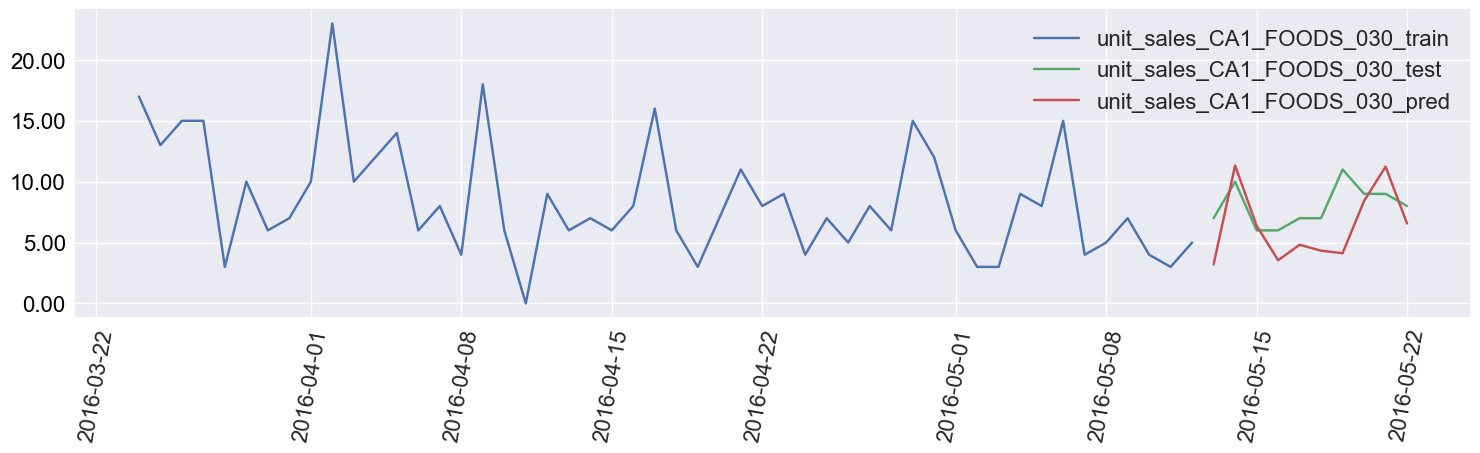

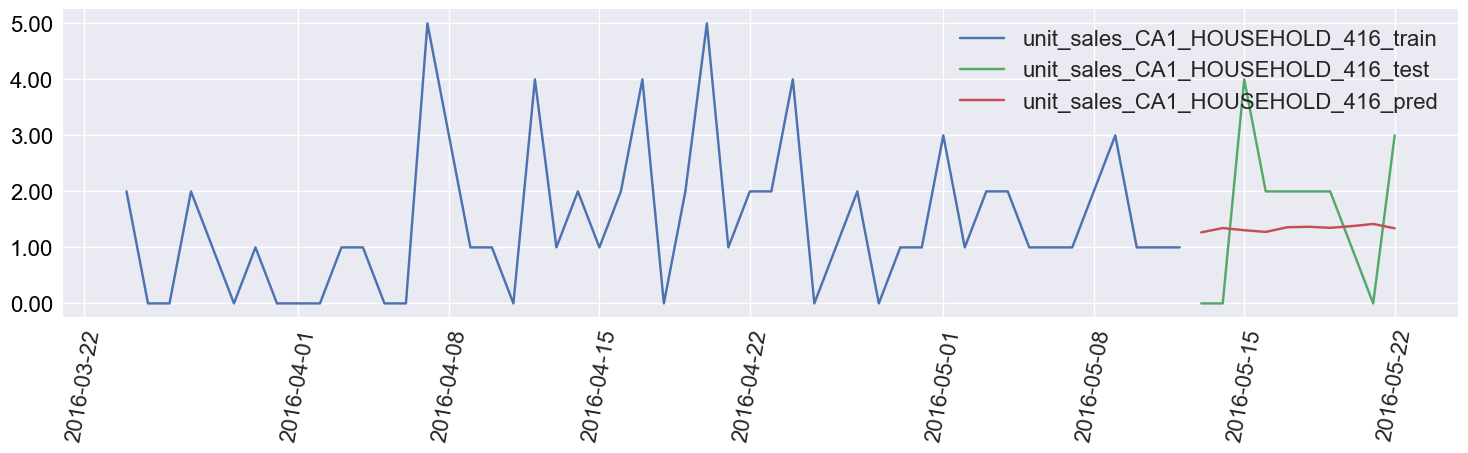

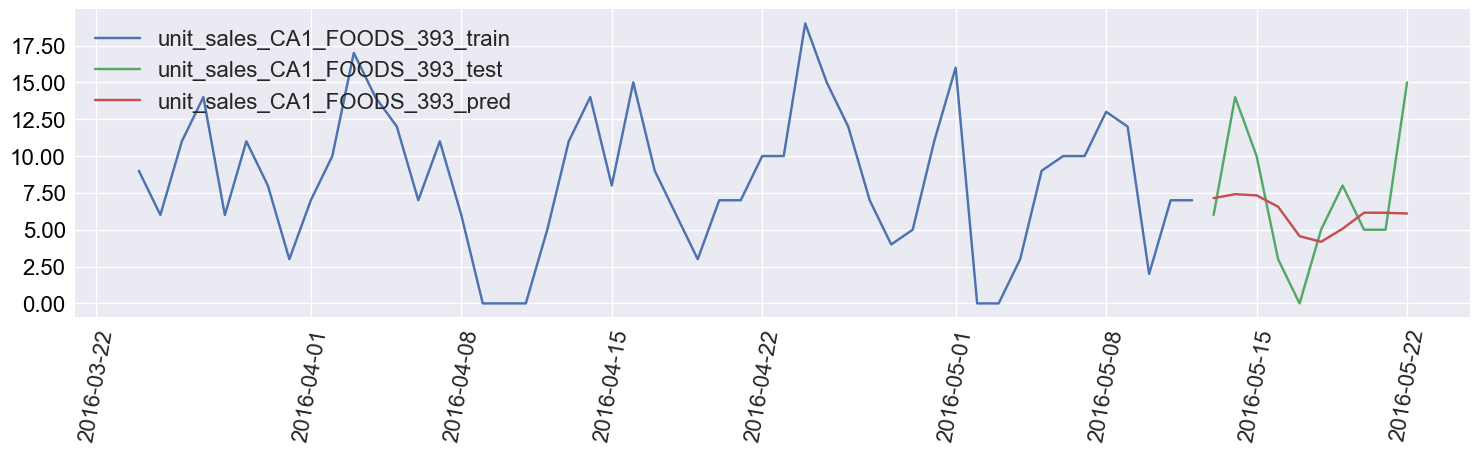

In [70]:


df = dfXY_pred_mvcatmo.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

y = "unit_sales_CA1_FOODS_030"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"


bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

y = "unit_sales_CA1_HOUSEHOLD_416"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"


bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)


y = "unit_sales_CA1_FOODS_393"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"


bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)


predict - exogenous, categorical, endogenous

In [69]:
ts_period = pd.DateOffset(days=1)
dfexogs=pd.DataFrame(data = {"year":5*[2016],
                             "month": 5*[5],
                             "week": 5*[21],
                             "snap_CA": 5*[0],
                             "CCI_USA":5*[100.7612]
                             })

dfcats=pd.DataFrame(data = {"le_weekday":[1,2,3,4,5], "le_event_name_1": 5*[30], "le_event_name_2": 5 *[3]})
df_pred=sfmvembmo.predict(Nperiods=3,dfexogs = dfexogs, dfcats = dfcats, ts_period=ts_period)
df_pred


1/1 [==============================] - 0s 40ms/step


unit_sales_CA1_FOODS_030_pred  unit_sales_CA1_HOUSEHOLD_416_pred  \
2016-05-23                       4.385098                           1.298505   
2016-05-24                       4.475608                           1.353217   
2016-05-25                       4.987155                           1.363870   

            unit_sales_CA1_FOODS_393_pred  
2016-05-23                       6.761959  
2016-05-24                       5.115774  
2016-05-25                       5.061549

### Train, Test and Validation

The purpose of this next exericise is for validation of our predictions against unseen data. The key goal is to validate that the sliding forecast (sforecast) 
out-of-sample predictions are the same as for predictions on unseen data. Below is the process for validating the out-of-sample predictions are correct.

We will use the multivariate, exogenous, endogenous, categorical case. 

Step 1. Create training/Test and validation (holdout set) data sets.   

Step 2.  Train Test with sforecast -  slidng forecast out of sample training and test, N-step recursive forecast methodFit the forecast model using the train/test data set

Step 3: Train (fit) using train set (separate from the validation set) ... 5 x 1-step recursive forward forecasts (should be identical to the above results)

Step 4. Compare the results of the two methods and ensure they produce identical forecasts.


Before these steps - similar to all previous cases
* Setup dfXYtf data
* Derived variables Transform
* Exogenous variables ... previously setup with data import
* Define tensorflow model

In [7]:

# same data as previous multivariate example
dfXYtf = dfXY[covars+exogvars+le_catvars].copy()
all_columns = dfXYtf.columns
print("covars =",covars)
print("catvars =",catvars)
print("exogvars =",exogvars)
print(dfXYtf.shape)
display(dfXYtf.tail(10))

covars = ['unit_sales_CA1_HOUSEHOLD_416', 'unit_sales_CA1_FOODS_044', 'unit_sales_CA1_FOODS_030', 'unit_sales_CA1_HOBBIES_418', 'unit_sales_CA1_FOODS_185', 'unit_sales_CA1_HOUSEHOLD_219', 'unit_sales_CA1_FOODS_393']
catvars = ['weekday', 'event_name_1', 'event_name_2']
exogvars = ['year', 'month', 'week', 'snap_CA', 'CCI_USA']
(1206, 15)


unit_sales_CA1_HOUSEHOLD_416  unit_sales_CA1_FOODS_044  \
date                                                                 
2016-05-13                           0.0                       2.0   
2016-05-14                           0.0                       1.0   
2016-05-15                           4.0                       1.0   
2016-05-16                           2.0                       2.0   
2016-05-17                           2.0                       4.0   
2016-05-18                           2.0                       0.0   
2016-05-19                           2.0                       0.0   
2016-05-20                           1.0                       0.0   
2016-05-21                           0.0                       3.0   
2016-05-22                           3.0                       2.0   

            unit_sales_CA1_FOODS_030  unit_sales_CA1_HOBBIES_418  \
date                                                               
2016-05-13                       7.0                         2.0   
2016-05-14                      10.0                         0.0   
2016-05-15                       6.0                         0.0   
2016-05-16                       6.0                         1.0   
2016-05-17                       7.0                         1.0   
2016-05-18                       7.0                         1.0   
2016-05-19                      11.0                         1.0   
2016-05-20                       9.0                         4.0   
2016-05-21                       9.0                         0.0   
2016-05-22                       8.0                         0.0   

            unit_sales_CA1_FOODS_185  unit_sales_CA1_HOUSEHOLD_219  \
date                                                                 
2016-05-13                       1.0                           0.0   
2016-05-14                       6.0                           1.0   
2016-05-15                       3.0                           1.0   
2016-05-16                       0.0                           1.0   
2016-05-17                       1.0                           0.0   
2016-05-18                       4.0                           0.0   
2016-05-19                       1.0                           0.0   
2016-05-20                       1.0                           0.0   
2016-05-21                       2.0                           2.0   
2016-05-22                       2.0                           1.0   

            unit_sales_CA1_FOODS_393  year  month  week  snap_CA   CCI_USA  \
date                                                                         
2016-05-13                       6.0  2016      5    19        0  100.7612   
2016-05-14                      14.0  2016      5    19        0  100.7612   
2016-05-15                      10.0  2016      5    19        0  100.7612   
2016-05-16                       3.0  2016      5    20        0  100.7612   
2016-05-17                       0.0  2016      5    20        0  100.7612   
2016-05-18                       5.0  2016      5    20        0  100.7612   
2016-05-19                       8.0  2016      5    20        0  100.7612   
2016-05-20                       5.0  2016      5    20        0  100.7612   
2016-05-21                       5.0  2016      5    20        0  100.7612   
2016-05-22                      15.0  2016      5    20        0  100.7612   

            le_weekday  le_event_name_1  le_event_name_2  
date                                                      
2016-05-13           5               30                3  
2016-05-14           6               30                3  
2016-05-15           0               30                3  
2016-05-16           1               30                3  
2016-05-17           2               30                3  
2016-05-18           3               30                3  
2016-05-19           4               30                3  
2016-05-20           5               30      

Edogenous (derived) variables, same as before

In [8]:
# deirvied variables transform

# derived attributes custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

# pipeline/transformer development
# BaseEstimater ... get_params(), set_params() methods
# TransformerMixin ... fit_transform() method
Nr = 3
class derived_attributes_tf(BaseEstimator,TransformerMixin):
    def __init__(self, Nr = Nr): 
        self.Nr = Nr # slidig/rolling window rows
        self.dfmemory = None
        
        v1 = "unit_sales_CA1_FOODS_030"
        v2 = "unit_sales_CA1_FOODS_393"
        self.vlist = [v1, v2]
        f1 = lambda x:x+"_m1_ravg"+str(Nr)
        f2 = lambda x:x+"_m1_rstd"+str(Nr)
        self.new_attributes = [f(v) for f in (f1, f2 )for v in self.vlist]
    
    def fit(self,df):
        # ensure dataframe has enough rows
        self.dfmemory = df.tail(self.Nr) if df.index.size > self.Nr else df.index.size
                # variables
        
        return self
    
    def transform(self,df=None, Nout=None, dfnewrows=None):
        # if df not spefified then transform on dfmemory
        # add new row(s) ... these will be provided from the predict operation
        if not isinstance(df,pd.DataFrame):
            df = self.dfmemory
            if isinstance(dfnewrows,pd.DataFrame):
                df = pd.concat([df,dfnewrows])
        self.dfmemory = df.tail(self.Nr) 
        Nr=self.Nr
        dfnew=df.copy()
        
        for v in self.vlist:
            v_ravg = v+"_m1_ravg"+str(Nr)
            v_rstd =  v+"_m1_rstd"+str(Nr)
            v_m1 = v+"_m1"
            dfnew[v_ravg] = dfnew[v_m1].rolling(window=Nr).mean()
            dfnew[v_rstd] = dfnew[v_m1].rolling(window=Nr).std()

        Nclip = self.Nr
        return dfnew if Nout == None else dfnew.tail(Nout)
    
    def get_Nclip(self): # returns the number of initial rows that should be desgarded (clipped) for NaN avoidence
        return self.Nr
    
    def get_derived_attribute_names(self):
        Nr = self.Nr
        return self.new_attributes
 
cols = ["unit_sales_CA1_FOODS_030" ,  "unit_sales_CA1_FOODS_393"]        
dfXY_m1 = dfXYtf[cols].copy()


# the variables eill be created by sforecast
# here we test the transform to see what the new variables look like.
Nclip =derived_attributes_tf().get_Nclip()
print("Nclip =",Nclip)
drived_var_transform = derived_attributes_tf()
dfXY_m1[["unit_sales_CA1_FOODS_030_m1" , "unit_sales_CA1_FOODS_393_m1" ]] = dfXY_m1[["unit_sales_CA1_FOODS_030" ,  "unit_sales_CA1_FOODS_393"]].shift(1)
dftest = drived_var_transform.fit_transform(dfXY_m1)
print("dataframe, dftest, with derived variables")
display(dftest.tail(5))

print(f'Nr= {Nr} dfmemory 3 rows from dataframe, saved by the transform after first use')
display(drived_var_transform.dfmemory)

new_attributes = drived_var_transform.get_derived_attribute_names()
print(f'\nnew_attribute_names = {new_attributes}')

Nclip = 3
dataframe, dftest, with derived variables


unit_sales_CA1_FOODS_030  unit_sales_CA1_FOODS_393  \
date                                                             
2016-05-18                       7.0                       5.0   
2016-05-19                      11.0                       8.0   
2016-05-20                       9.0                       5.0   
2016-05-21                       9.0                       5.0   
2016-05-22                       8.0                      15.0   

            unit_sales_CA1_FOODS_030_m1  unit_sales_CA1_FOODS_393_m1  \
date                                                                   
2016-05-18                          7.0                          0.0   
2016-05-19                          7.0                          5.0   
2016-05-20                         11.0                          8.0   
2016-05-21                          9.0                          5.0   
2016-05-22                          9.0                          5.0   

            unit_sales_CA1_FOODS_030_m1_ravg3  \
date                                            
2016-05-18                           6.333333   
2016-05-19                           6.666667   
2016-05-20                           8.333333   
2016-05-21                           9.000000   
2016-05-22                           9.666667   

            unit_sales_CA1_FOODS_030_m1_rstd3  \
date                                            
2016-05-18                           0.577350   
2016-05-19                           0.577350   
2016-05-20                           2.309401   
2016-05-21                           2.000000   
2016-05-22                           1.154701   

            unit_sales_CA1_FOODS_393_m1_ravg3  \
date                                            
2016-05-18                           4.333333   
2016-05-19                           2.666667   
2016-05-20                           4.333333   
2016-05-21                           6.000000   
2016-05-22                           6.000000   

            unit_sales_CA1_FOODS_393_m1_rstd3  
date                                           
2016-05-18                           5.131601  
2016-05-19                           2.516611  
2016-05-20                           4.041452  
2016-05-21                           1.732051  
2016-05-22                           1.732051

Nr= 3 dfmemory 3 rows from dataframe, saved by the transform after first use


unit_sales_CA1_FOODS_030  unit_sales_CA1_FOODS_393  \
date                                                             
2016-05-20                       9.0                       5.0   
2016-05-21                       9.0                       5.0   
2016-05-22                       8.0                      15.0   

            unit_sales_CA1_FOODS_030_m1  unit_sales_CA1_FOODS_393_m1  
date                                                                  
2016-05-20                         11.0                          8.0  
2016-05-21                          9.0                          5.0  
2016-05-22                          9.0                          5.0


new_attribute_names = ['unit_sales_CA1_FOODS_030_m1_ravg3', 'unit_sales_CA1_FOODS_393_m1_ravg3', 'unit_sales_CA1_FOODS_030_m1_rstd3', 'unit_sales_CA1_FOODS_393_m1_rstd3']


Tensorflow model - multivariate, dense, Categorical Embeddings + multiple output

In [9]:
# TensorFlow model ... Categorical Embeddings + Dense (Continuous Variables), Multiple Ouput
Nlags = 5
Nendogvars = 4
Ndense = Nlags * Ncovars + Nexogvars + Nendogvars #lagged covars (does not include unlagged covars) + exogvars
Nemb = Ncatvars
Nembout = sum(eoutdim)
Nout = len(covars)

print(f'Ndense = {Ndense}')
print(f'Nemb = {Nemb}')
print(f'Nout = {Nout}')

# Dense Network, 2 hidden layers, continuous variables ... covar lags and exogenous variables
cont_inputs = Input((Ndense,))
h1d = Dense(Ndense, activation='relu')(cont_inputs)

# embeddings, cat vars
cat_inputs_list = [ Input((1,)) for c in range(Nemb) ]  # one embedding for each categorical variable
emb_out_list = [Embedding(ein,eout,input_length=1)(cat) for ein,eout,cat in zip(eindim ,eoutdim,cat_inputs_list) ]
emb_flat_list = [Flatten()(emb_out) for emb_out in emb_out_list ]

# combined 
combined = concatenate([h1d]+emb_flat_list)
combined_d = Dropout(0.2)(combined)

# dense reduction layers
Nh1c = Ndense + Nembout # 
h1c = Dense(Nh1c, activation='relu')(combined_d)
h1c_d = Dropout(0.2)(h1c)
Nh2c = np.rint(Nh1c/2).astype(int)
h2c = Dense(Nh2c, activation='relu')(h1c_d)
h2c_d = Dropout(0.2)(h2c)

# output
output = Dense(Nout)(h2c_d)  # linear activation ... linear combination 
model_tf_dense_emb = Model(inputs=[cont_inputs, cat_inputs_list], outputs=output)

# define optimizer and compile ...
optimizer = Adam(learning_rate=0.05, decay=.1)
model_tf_dense_emb.compile(loss='mse', optimizer=optimizer)

print(model_tf_dense_emb.summary())

Ndense = 44
Nemb = 3
Nout = 7
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 44)]         0           []                               
                                                                

2023-01-12 19:19:49.648865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 dropout_1 (Dropout)            (None, 54)           0           ['dense_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 27)           1485        ['dropout_1[0][0]']              
                                                                                                  
 dropout_2 (Dropout)            (None, 27)           0           ['dense_2[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 7)            196         ['dropout_2[0][0]']              
                                                                                                  
Total params: 6,825
Trainable params: 6,825
Non-trainable params: 0
__________________________________________________________________________________________________
None


Step 1. Create training/Test and validation (holdout set) data sets.  

In [10]:
dfXY_traintest = dfXYtf
dfXY_train = dfXYtf[:1199] # training set ... all but the last 7 rows
dfXY_valid = dfXYtf[1199:] # validation last 7 rows
dfXY_valid.columns = [c+"_valid" if "unit_sales_" in c else c for c in dfXY_valid.columns]
print("dfXY_train")
display(dfXY_train.tail())

print("dfXY_valid")
display(dfXY_valid)

dfXY_train


unit_sales_CA1_HOUSEHOLD_416  unit_sales_CA1_FOODS_044  \
date                                                                 
2016-05-11                           1.0                       1.0   
2016-05-12                           1.0                       0.0   
2016-05-13                           0.0                       2.0   
2016-05-14                           0.0                       1.0   
2016-05-15                           4.0                       1.0   

            unit_sales_CA1_FOODS_030  unit_sales_CA1_HOBBIES_418  \
date                                                               
2016-05-11                       3.0                         4.0   
2016-05-12                       5.0                         1.0   
2016-05-13                       7.0                         2.0   
2016-05-14                      10.0                         0.0   
2016-05-15                       6.0                         0.0   

            unit_sales_CA1_FOODS_185  unit_sales_CA1_HOUSEHOLD_219  \
date                                                                 
2016-05-11                       3.0                           0.0   
2016-05-12                       0.0                           0.0   
2016-05-13                       1.0                           0.0   
2016-05-14                       6.0                           1.0   
2016-05-15                       3.0                           1.0   

            unit_sales_CA1_FOODS_393  year  month  week  snap_CA   CCI_USA  \
date                                                                         
2016-05-11                       7.0  2016      5    19        0  100.7612   
2016-05-12                       7.0  2016      5    19        0  100.7612   
2016-05-13                       6.0  2016      5    19        0  100.7612   
2016-05-14                      14.0  2016      5    19        0  100.7612   
2016-05-15                      10.0  2016      5    19        0  100.7612   

            le_weekday  le_event_name_1  le_event_name_2  
date                                                      
2016-05-11           3               30                3  
2016-05-12           4               30                3  
2016-05-13           5               30                3  
2016-05-14           6               30                3  
2016-05-15           0               30                3

dfXY_valid


unit_sales_CA1_HOUSEHOLD_416_valid  \
date                                             
2016-05-16                                 2.0   
2016-05-17                                 2.0   
2016-05-18                                 2.0   
2016-05-19                                 2.0   
2016-05-20                                 1.0   
2016-05-21                                 0.0   
2016-05-22                                 3.0   

            unit_sales_CA1_FOODS_044_valid  unit_sales_CA1_FOODS_030_valid  \
date                                                                         
2016-05-16                             2.0                             6.0   
2016-05-17                             4.0                             7.0   
2016-05-18                             0.0                             7.0   
2016-05-19                             0.0                            11.0   
2016-05-20                             0.0                             9.0   
2016-05-21                             3.0                             9.0   
2016-05-22                             2.0                             8.0   

            unit_sales_CA1_HOBBIES_418_valid  unit_sales_CA1_FOODS_185_valid  \
date                                                                           
2016-05-16                               1.0                             0.0   
2016-05-17                               1.0                             1.0   
2016-05-18                               1.0                             4.0   
2016-05-19                               1.0                             1.0   
2016-05-20                               4.0                             1.0   
2016-05-21                               0.0                             2.0   
2016-05-22                               0.0                             2.0   

            unit_sales_CA1_HOUSEHOLD_219_valid  \
date                                             
2016-05-16                                 1.0   
2016-05-17                                 0.0   
2016-05-18                                 0.0   
2016-05-19                                 0.0   
2016-05-20                                 0.0   
2016-05-21                                 2.0   
2016-05-22                                 1.0   

            unit_sales_CA1_FOODS_393_valid  year  month  week  snap_CA  \
date                                                                     
2016-05-16                             3.0  2016      5    20        0   
2016-05-17                             0.0  2016      5    20        0   
2016-05-18                             5.0  2016      5    20        0   
2016-05-19                             8.0  2016      5    20        0   
2016-05-20                             5.0  2016      5    20        0   
2016-05-21                             5.0  2016      5    20        0   
2016-05-22                            15.0  2016      5    20        0   

             CCI_USA  le_weekday  le_event_name_1  le_event_name_2  
date                                                                
2016-05-16  100.7612           1               30                3  
2016-05-17  100.7612           2               30                3  
2016-05-18  100.7612           3               30                3  
2016-05-19  100.7612           4               30                3  
2016-05-20  100.7612           5               30                3  
2016-05-21  100.7612           6               30                3  
2016-05-22  100.7612           0               30                3

Step 2.  Train Test out-of-sample forecast over the the entire dataset with sforecast -  N-step recursive forecast, 7 1-step recursive predictions


In [11]:
# sliding out of sample forecast
# display data
print("dfXY_traintest")
display(dfXY_traintest.tail(5))

y = ["unit_sales_CA1_FOODS_030",  "unit_sales_CA1_FOODS_393" ]
print(f'\ny = {y}\n')

# define optimizer and compile ... compile again to make sure it is a fresh non-trained model prior to fit
optimizer = Adam(learning_rate=0.05, decay=.1)
model_tf_dense_emb.compile(loss='mse', optimizer=optimizer)

# forecast fit
Ntest = 7
Nhorizon = 7
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "covars":covars,
    "exogvars":exogvars,
    "catvars":le_catvars,
    "derived_attributes_transform": derived_attributes_tf
    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}


sfmvembmo = sf.sforecast(y = y, model_type="tf", swin_parameters=swin_params,model=model_tf_dense_emb, tf_parameters=tf_params)

df_pred = sfmvembmo.fit(dfXY_traintest)

df_pred_s2=df_pred[1199:][["unit_sales_CA1_FOODS_030_pred", "unit_sales_CA1_FOODS_393_pred"] ] # keep last 7 rows (i.e., 7 x 1-step recursive out-of-samppe)

df_pred_s2.columns = ["unit_sales_CA1_FOODS_030_pred_s2", "unit_sales_CA1_FOODS_393_pred_s2"] # change column names

df_pred_s2


dfXY_traintest


unit_sales_CA1_HOUSEHOLD_416  unit_sales_CA1_FOODS_044  \
date                                                                 
2016-05-18                           2.0                       0.0   
2016-05-19                           2.0                       0.0   
2016-05-20                           1.0                       0.0   
2016-05-21                           0.0                       3.0   
2016-05-22                           3.0                       2.0   

            unit_sales_CA1_FOODS_030  unit_sales_CA1_HOBBIES_418  \
date                                                               
2016-05-18                       7.0                         1.0   
2016-05-19                      11.0                         1.0   
2016-05-20                       9.0                         4.0   
2016-05-21                       9.0                         0.0   
2016-05-22                       8.0                         0.0   

            unit_sales_CA1_FOODS_185  unit_sales_CA1_HOUSEHOLD_219  \
date                                                                 
2016-05-18                       4.0                           0.0   
2016-05-19                       1.0                           0.0   
2016-05-20                       1.0                           0.0   
2016-05-21                       2.0                           2.0   
2016-05-22                       2.0                           1.0   

            unit_sales_CA1_FOODS_393  year  month  week  snap_CA   CCI_USA  \
date                                                                         
2016-05-18                       5.0  2016      5    20        0  100.7612   
2016-05-19                       8.0  2016      5    20        0  100.7612   
2016-05-20                       5.0  2016      5    20        0  100.7612   
2016-05-21                       5.0  2016      5    20        0  100.7612   
2016-05-22                      15.0  2016      5    20        0  100.7612   

            le_weekday  le_event_name_1  le_event_name_2  
date                                                      
2016-05-18           3               30                3  
2016-05-19           4               30                3  
2016-05-20           5               30                3  
2016-05-21           6               30                3  
2016-05-22           0               30                3


y = ['unit_sales_CA1_FOODS_030', 'unit_sales_CA1_FOODS_393']

1/1 [==============================] - 0s 36ms/step


unit_sales_CA1_FOODS_030_pred_s2  unit_sales_CA1_FOODS_393_pred_s2
date                                                                          
2016-05-16                          5.396507                          6.578838
2016-05-17                          4.138158                          5.981815
2016-05-18                          3.631157                          5.602561
2016-05-19                          4.988376                          5.758481
2016-05-20                          7.039764                          5.892289
2016-05-21                          8.094049                          6.869199
2016-05-22                          7.886084                          6.087505

Step 3: Train (fit) using train set (separate from the validation set) ... 7 x 1-step recursive forward forecasts (should be identical to the above results)



In [12]:
# display data
print("dfXY_train")
display(dfXY_train.tail(5))

y = ["unit_sales_CA1_FOODS_030",  "unit_sales_CA1_FOODS_393" ]
print(f'\ny = {y}\n')

# define optimizer and compile ... compile again to make sure it is a fresh non-trained model prior to fit
optimizer = Adam(learning_rate=0.05, decay=.1)
model_tf_dense_emb.compile(loss='mse', optimizer=optimizer)

# forecast fit
Ntest = 0
Nhorizon = 1
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "covars":covars,
    "exogvars":exogvars,
    "catvars":le_catvars,
    "derived_attributes_transform": derived_attributes_tf
    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}

sfmvembmo = sf.sforecast(y = y, model_type="tf", swin_parameters=swin_params,model=model_tf_dense_emb, tf_parameters=tf_params)

sfmvembmo.fit(dfXY_train)

# Forecast Nperiods forward 7 x 1-step recursive predictions
dfexogs=dfXY_traintest[1199:][exogvars]
dfcats=dfXY_traintest[1199:][le_catvars]
ts_period = pd.DateOffset(days=1)
df_pred_s3=sfmvembmo.predict(Nperiods=7,dfexogs = dfexogs, dfcats = dfcats, ts_period=ts_period)
df_pred_s3.columns = ["unit_sales_CA1_FOODS_030_pred_s3",	"unit_sales_CA1_FOODS_393_pred_s3"]
df_pred_s3


dfXY_train


unit_sales_CA1_HOUSEHOLD_416  unit_sales_CA1_FOODS_044  \
date                                                                 
2016-05-11                           1.0                       1.0   
2016-05-12                           1.0                       0.0   
2016-05-13                           0.0                       2.0   
2016-05-14                           0.0                       1.0   
2016-05-15                           4.0                       1.0   

            unit_sales_CA1_FOODS_030  unit_sales_CA1_HOBBIES_418  \
date                                                               
2016-05-11                       3.0                         4.0   
2016-05-12                       5.0                         1.0   
2016-05-13                       7.0                         2.0   
2016-05-14                      10.0                         0.0   
2016-05-15                       6.0                         0.0   

            unit_sales_CA1_FOODS_185  unit_sales_CA1_HOUSEHOLD_219  \
date                                                                 
2016-05-11                       3.0                           0.0   
2016-05-12                       0.0                           0.0   
2016-05-13                       1.0                           0.0   
2016-05-14                       6.0                           1.0   
2016-05-15                       3.0                           1.0   

            unit_sales_CA1_FOODS_393  year  month  week  snap_CA   CCI_USA  \
date                                                                         
2016-05-11                       7.0  2016      5    19        0  100.7612   
2016-05-12                       7.0  2016      5    19        0  100.7612   
2016-05-13                       6.0  2016      5    19        0  100.7612   
2016-05-14                      14.0  2016      5    19        0  100.7612   
2016-05-15                      10.0  2016      5    19        0  100.7612   

            le_weekday  le_event_name_1  le_event_name_2  
date                                                      
2016-05-11           3               30                3  
2016-05-12           4               30                3  
2016-05-13           5               30                3  
2016-05-14           6               30                3  
2016-05-15           0               30                3


y = ['unit_sales_CA1_FOODS_030', 'unit_sales_CA1_FOODS_393']

1/1 [==============================] - 0s 30ms/step


unit_sales_CA1_FOODS_030_pred_s3  unit_sales_CA1_FOODS_393_pred_s3
2016-05-16                          6.149331                          6.196012
2016-05-17                          4.599548                          6.028992
2016-05-18                          2.157710                          5.326075
2016-05-19                          3.579649                          5.899635
2016-05-20                          6.510416                          6.229251
2016-05-21                          6.197575                          7.547742
2016-05-22                          6.052825                          6.731640

Step 4. Compare the results of the two methods and ensure they produce identical forecasts.

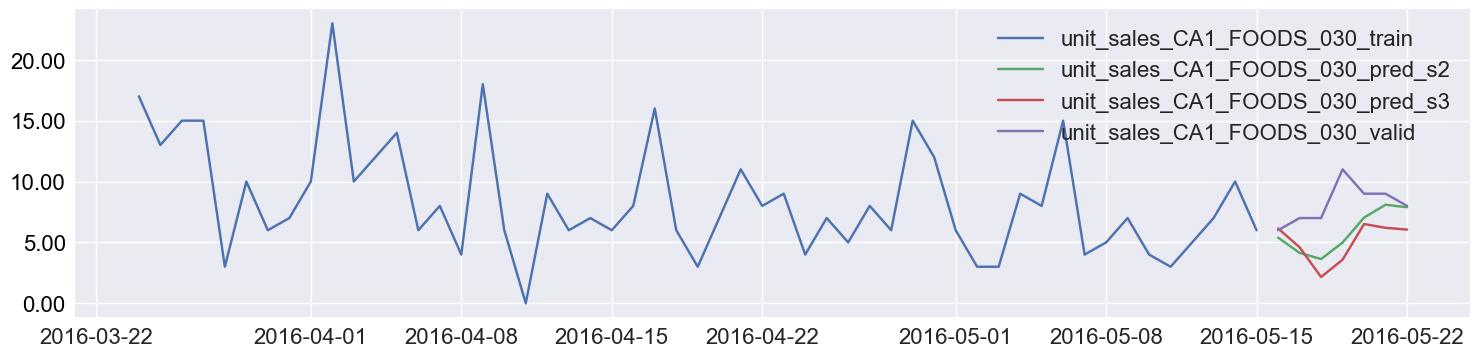

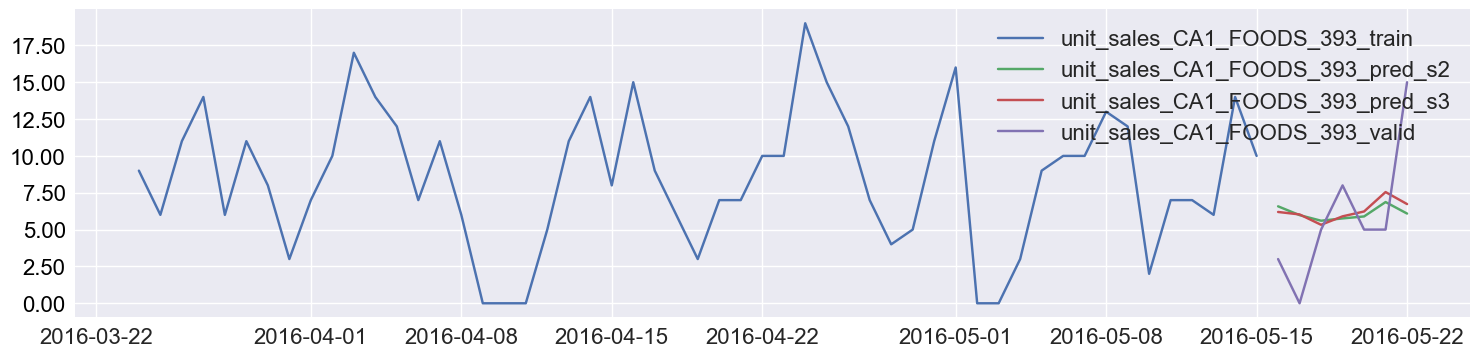

unit_sales_CA1_FOODS_030_train  unit_sales_CA1_FOODS_393_train  \
date                                                                         
2016-05-13                             7.0                             6.0   
2016-05-14                            10.0                            14.0   
2016-05-15                             6.0                            10.0   
2016-05-16                             NaN                             NaN   
2016-05-17                             NaN                             NaN   
2016-05-18                             NaN                             NaN   
2016-05-19                             NaN                             NaN   
2016-05-20                             NaN                             NaN   
2016-05-21                             NaN                             NaN   
2016-05-22                             NaN                             NaN   

            unit_sales_CA1_FOODS_030_pred_s2  \
date                                           
2016-05-13                               NaN   
2016-05-14                               NaN   
2016-05-15                               NaN   
2016-05-16                          5.396507   
2016-05-17                          4.138158   
2016-05-18                          3.631157   
2016-05-19                          4.988376   
2016-05-20                          7.039764   
2016-05-21                          8.094049   
2016-05-22                          7.886084   

            unit_sales_CA1_FOODS_393_pred_s2  \
date                                           
2016-05-13                               NaN   
2016-05-14                               NaN   
2016-05-15                               NaN   
2016-05-16                          6.578838   
2016-05-17                          5.981815   
2016-05-18                          5.602561   
2016-05-19                          5.758481   
2016-05-20                          5.892289   
2016-05-21                          6.869199   
2016-05-22                          6.087505   

            unit_sales_CA1_FOODS_030_pred_s3  \
date                                           
2016-05-13                               NaN   
2016-05-14                               NaN   
2016-05-15                               NaN   
2016-05-16                          6.149331   
2016-05-17                          4.599548   
2016-05-18                          2.157710   
2016-05-19                          3.579649   
2016-05-20                          6.510416   
2016-05-21                          6.197575   
2016-05-22                          6.052825   

            unit_sales_CA1_FOODS_393_pred_s3  unit_sales_CA1_FOODS_030_valid  \
date                                                                           
2016-05-13                               NaN                             NaN   
2016-05-14                               NaN                             NaN   
2016-05-15                               NaN                             NaN   
2016-05-16                          6.196012                             6.0   
2016-05-17                          6.028992                             7.0   
2016-05-18                          5.326075                             7.0   
2016-05-19                          5.899635                            11.0   
2016-05-20                          6.229251                             9.0   
2016-05-21                          7.547742                             9.0   
2016-05-22                          6.731640                             8.0   

            unit_sales_CA1_FOODS_393_valid  
date                                        
2016-05-13                             NaN  
2016-05-14                             NaN  
2016-05-15                             NaN  
2016-05-16                             3.0  
2016-05-17                             0.0  
2016-05-18                             5.0  
2016-05-19             

dfexogs


year  month  week  snap_CA   CCI_USA
date                                            
2016-05-16  2016      5    20        0  100.7612
2016-05-17  2016      5    20        0  100.7612
2016-05-18  2016      5    20        0  100.7612
2016-05-19  2016      5    20        0  100.7612
2016-05-20  2016      5    20        0  100.7612
2016-05-21  2016      5    20        0  100.7612
2016-05-22  2016      5    20        0  100.7612

dfcats


le_weekday  le_event_name_1  le_event_name_2
date                                                    
2016-05-16           1               30                3
2016-05-17           2               30                3
2016-05-18           3               30                3
2016-05-19           4               30                3
2016-05-20           5               30                3
2016-05-21           6               30                3
2016-05-22           0               30                3

In [13]:


# Join the training, predictions and validations for easy comparison 
dfXY_testtrainpred = pd.concat([dfXY_train[y], df_pred_s2])
dfXY_testtrainpred=dfXY_testtrainpred.rename({"unit_sales_CA1_FOODS_030":"unit_sales_CA1_FOODS_030_train","unit_sales_CA1_FOODS_393":"unit_sales_CA1_FOODS_393_train" }, axis=1)
dfXY_testtrainpred = dfXY_testtrainpred.join(df_pred_s3)
dfXY_testtrainpred = dfXY_testtrainpred.join(dfXY_valid[["unit_sales_CA1_FOODS_030_valid","unit_sales_CA1_FOODS_393_valid"]])


# plot
dfXY_plot = dfXY_testtrainpred.reset_index()

bp.lineplot(dfXY_plot.tail(60), x= "date", y=["unit_sales_CA1_FOODS_030_train", "unit_sales_CA1_FOODS_030_pred_s2", "unit_sales_CA1_FOODS_030_pred_s3","unit_sales_CA1_FOODS_030_valid"  ] , figsize=(18,4) , legend=True)

bp.lineplot(dfXY_plot.tail(60), x= "date", y=["unit_sales_CA1_FOODS_393_train", "unit_sales_CA1_FOODS_393_pred_s2", "unit_sales_CA1_FOODS_393_pred_s3","unit_sales_CA1_FOODS_393_valid"  ] , figsize=(18,4) , legend=True)


# display

display(dfXY_testtrainpred.tail(10))

print("dfexogs")
display(dfexogs)

print("dfcats")
display(dfcats)

### Multivariate Exen Groups

Data

In [4]:

# unit_sales_CA_1_FOODS_2_FOODS_2_044
# unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416
# unit_sales_CA_1_FOODS_3_FOODS_3_393
# y forecast variable
#y = ["unit_sales_CA_1_FOODS_3_FOODS_3_030", "unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416" ]

# endogenous variables = new attribute names (i.e., derived attributes)
endogs =  ['unit_sales_CA_1_FOODS_3_FOODS_3_030_m1_ravg3', 'unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_m1_ravg3', 
           'unit_sales_CA_1_FOODS_3_FOODS_3_393_m1_ravg3', 'unit_sales_CA_1_FOODS_3_FOODS_3_030_m1_rstd3', 
           'unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_m1_rstd3', 'unit_sales_CA_1_FOODS_3_FOODS_3_393_m1_rstd3']


exenvars = [ ['year', 'month', 'week', 'snap_CA'] +endogs, ['CCI_USA'] ] # envars list of lists. Each processed differently by the TF model
Nexenvars1 = len(exenvars[0])
Nexenvars2 = len(exenvars[1])
print(catvars)
print("exenvars =",exenvars)
print(f'Nexenvars1 = {Nexenvars1}')
print(f'Nexenvars2 = {Nexenvars2}')
dfXYtf= dfXY[covars+exogvars+le_catvars]
print("dfXYmvexcatso.shape =",dfXYtf.shape)
display(dfXYtf.head())

['weekday', 'event_name_1', 'event_name_2']
exenvars = [['year', 'month', 'week', 'snap_CA', 'unit_sales_CA_1_FOODS_3_FOODS_3_030_m1_ravg3', 'unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_m1_ravg3', 'unit_sales_CA_1_FOODS_3_FOODS_3_393_m1_ravg3', 'unit_sales_CA_1_FOODS_3_FOODS_3_030_m1_rstd3', 'unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_m1_rstd3', 'unit_sales_CA_1_FOODS_3_FOODS_3_393_m1_rstd3'], ['CCI_USA']]
Nexenvars1 = 10
Nexenvars2 = 1
dfXYmvexcatso.shape = (1206, 15)


unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416  \
date                                                      
2013-02-02                                          2.0   
2013-02-03                                          0.0   
2013-02-04                                          1.0   
2013-02-05                                          0.0   
2013-02-06                                          0.0   

            unit_sales_CA_1_FOODS_2_FOODS_2_044  \
date                                              
2013-02-02                                  0.0   
2013-02-03                                  0.0   
2013-02-04                                  1.0   
2013-02-05                                  1.0   
2013-02-06                                  1.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_030  \
date                                              
2013-02-02                                 43.0   
2013-02-03                                 33.0   
2013-02-04                                  5.0   
2013-02-05                                 14.0   
2013-02-06                                 11.0   

            unit_sales_CA_1_HOBBIES_1_HOBBIES_1_418  \
date                                                  
2013-02-02                                      0.0   
2013-02-03                                      0.0   
2013-02-04                                      0.0   
2013-02-05                                      0.0   
2013-02-06                                      0.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_185  \
date                                              
2013-02-02                                  0.0   
2013-02-03                                  0.0   
2013-02-04                                  0.0   
2013-02-05                                  0.0   
2013-02-06                                  0.0   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_219  \
date                                                      
2013-02-02                                          0.0   
2013-02-03                                          0.0   
2013-02-04                                          0.0   
2013-02-05                                          0.0   
2013-02-06                                          0.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_393  year  month  week  snap_CA  \
date                                                                          
2013-02-02                                  4.0  2013      2     5        1   
2013-02-03                                  5.0  2013      2     5        1   
2013-02-04                                  1.0  2013      2     6        1   
2013-02-05                                  2.0  2013      2     6        1   
2013-02-06                                  2.0  2013      2     6        1   

             CCI_USA  le_weekday  le_event_name_1  le_event_name_2  
date                                                                
2013-02-02  98.72734           6               30                3  
2013-02-03  98.72734           0               26                3  
2013-02-04  98.72734           1               30                3  
2013-02-05  98.72734           2               30                3  
2013-02-06  98.72734           3               30                3

derived attributes ... for convenience, repeated from previous multivariate case 

In [5]:
# deirvied variables transform

# derived attributes custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

# pipeline/transformer development
# BaseEstimater ... get_params(), set_params() methods
# TransformerMixin ... fit_transform() method
Nr = 3
class derived_attributes_tf(BaseEstimator,TransformerMixin):
    def __init__(self, Nr = Nr): 
        self.Nr = Nr # slidig/rolling window rows
        self.dfmemory = None
        
        v1 = "unit_sales_CA_1_FOODS_3_FOODS_3_030"
        v2 = "unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416"
        v3 = "unit_sales_CA_1_FOODS_3_FOODS_3_393"
        self.vlist = [v1, v2, v3]
        f1 = lambda x:x+"_m1_ravg"+str(Nr)
        f2 = lambda x:x+"_m1_rstd"+str(Nr)
        self.new_attributes = [f(v) for f in (f1, f2 )for v in self.vlist]
    
    def fit(self,df):
        # ensure dataframe has enough rows
        self.dfmemory = df.tail(self.Nr) if df.index.size > self.Nr else df.index.size
                # variables
        return self
    
    def transform(self,df=None, Nout=None, dfnewrows=None):
        # if df not spefified then transform on dfmemory
        # add new row(s) ... these will be provided from the predict operation
        if not isinstance(df,pd.DataFrame):
            df = self.dfmemory
            if isinstance(dfnewrows,pd.DataFrame):
                df = pd.concat([df,dfnewrows])
        self.dfmemory = df.tail(self.Nr) 
        Nr=self.Nr
        dfnew=df.copy()
        
        for v in self.vlist:
            v_ravg = v+"_m1_ravg"+str(Nr)
            v_rstd =  v+"_m1_rstd"+str(Nr)
            v_m1 = v+"_m1"
            dfnew[v_ravg] = dfnew[v_m1].rolling(window=Nr).mean()
            dfnew[v_rstd] = dfnew[v_m1].rolling(window=Nr).std()

        Nclip = self.Nr
        return dfnew if Nout == None else dfnew.tail(Nout)
    
    def get_Nclip(self): # returns the number of initial rows that should be desgarded (clipped) for NaN avoidence
        return self.Nr
    
    def get_derived_attribute_names(self):
        Nr = self.Nr
        return self.new_attributes
 
cols = ["unit_sales_CA_1_FOODS_3_FOODS_3_030" , "unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416" , "unit_sales_CA_1_FOODS_3_FOODS_3_393"]        
dfXY_m1 = dfXYtf[cols].copy()
# the variables eill be created by sforecast
# here we test the transform to see what the new variables look like.
Nclip =derived_attributes_tf().get_Nclip()
print("Nclip =",Nclip)
drived_var_transform = derived_attributes_tf()
dfXY_m1[["unit_sales_CA_1_FOODS_3_FOODS_3_030_m1" , "unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_m1" , "unit_sales_CA_1_FOODS_3_FOODS_3_393_m1" ]] = dfXY_m1[["unit_sales_CA_1_FOODS_3_FOODS_3_030" , "unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416" , "unit_sales_CA_1_FOODS_3_FOODS_3_393"]].shift(1)
dftest = drived_var_transform.fit_transform(dfXY_m1)
print("dataframe, dftest, with derived variables")
display(dftest.tail(5))

print(f'Nr= {Nr} dfmemory 3 rows from dataframe, saved by the transform after first use')
display(drived_var_transform.dfmemory)

new_attributes = drived_var_transform.get_derived_attribute_names()
print(f'\nnew_attribute_names = {new_attributes}')

Nclip = 3
dataframe, dftest, with derived variables


unit_sales_CA_1_FOODS_3_FOODS_3_030  \
date                                              
2016-05-18                                  7.0   
2016-05-19                                 11.0   
2016-05-20                                  9.0   
2016-05-21                                  9.0   
2016-05-22                                  8.0   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416  \
date                                                      
2016-05-18                                          2.0   
2016-05-19                                          2.0   
2016-05-20                                          1.0   
2016-05-21                                          0.0   
2016-05-22                                          3.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_393  \
date                                              
2016-05-18                                  5.0   
2016-05-19                                  8.0   
2016-05-20                                  5.0   
2016-05-21                                  5.0   
2016-05-22                                 15.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_030_m1  \
date                                                 
2016-05-18                                     7.0   
2016-05-19                                     7.0   
2016-05-20                                    11.0   
2016-05-21                                     9.0   
2016-05-22                                     9.0   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_m1  \
date                                                         
2016-05-18                                             2.0   
2016-05-19                                             2.0   
2016-05-20                                             2.0   
2016-05-21                                             1.0   
2016-05-22                                             0.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_393_m1  \
date                                                 
2016-05-18                                     0.0   
2016-05-19                                     5.0   
2016-05-20                                     8.0   
2016-05-21                                     5.0   
2016-05-22                                     5.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_030_m1_ravg3  \
date                                                       
2016-05-18                                      6.333333   
2016-05-19                                      6.666667   
2016-05-20                                      8.333333   
2016-05-21                                      9.000000   
2016-05-22                                      9.666667   

            unit_sales_CA_1_FOODS_3_FOODS_3_030_m1_rstd3  \
date                                                       
2016-05-18                                      0.577350   
2016-05-19                                      0.577350   
2016-05-20                                      2.309401   
2016-05-21                                      2.000000   
2016-05-22                                      1.154701   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_m1_ravg3  \
date                                                               
2016-05-18                                           2.666667      
2016-05-19                                           2.000000      
2016-05-20                                           2.000000      
2016-05-21                                           1.666667      
2016-05-22                                           1.000000      

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_m1_rstd3  \
date                                                               
2016-05-18                                           1.154701      
2016-05-19                                           0.000000      
2016-05-20                                           0.000000      
2016-05-21                    

Nr= 3 dfmemory 3 rows from dataframe, saved by the transform after first use


unit_sales_CA_1_FOODS_3_FOODS_3_030  \
date                                              
2016-05-20                                  9.0   
2016-05-21                                  9.0   
2016-05-22                                  8.0   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416  \
date                                                      
2016-05-20                                          1.0   
2016-05-21                                          0.0   
2016-05-22                                          3.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_393  \
date                                              
2016-05-20                                  5.0   
2016-05-21                                  5.0   
2016-05-22                                 15.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_030_m1  \
date                                                 
2016-05-20                                    11.0   
2016-05-21                                     9.0   
2016-05-22                                     9.0   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_m1  \
date                                                         
2016-05-20                                             2.0   
2016-05-21                                             1.0   
2016-05-22                                             0.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_393_m1  
date                                                
2016-05-20                                     8.0  
2016-05-21                                     5.0  
2016-05-22                                     5.0


new_attribute_names = ['unit_sales_CA_1_FOODS_3_FOODS_3_030_m1_ravg3', 'unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_m1_ravg3', 'unit_sales_CA_1_FOODS_3_FOODS_3_393_m1_ravg3', 'unit_sales_CA_1_FOODS_3_FOODS_3_030_m1_rstd3', 'unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_m1_rstd3', 'unit_sales_CA_1_FOODS_3_FOODS_3_393_m1_rstd3']


TF Model: exogenous, endogenous, catvars ... CCI_USA processed a little differently sent directly to the output layer

In [6]:
###### 4 sets of inputs ... dense1 (covar lags), dense2 (exogs1), linear (exogs2), and embeddings (categorical inputs)
# linear exog directly to output
# TensorFlow model ... Categorical Embeddings + Dense (Continuous Variables), Multiple Ouput
Nlags = 5
Ndense1 = Nlags * Ncovars #lagged covars (does not include unlagged covars) + exogvars
Ndense2 = Nexenvars1
Nlinear = Nexenvars2
Nemb = Ncatvars
Nembout = sum(eoutdim)
Nout = len(covars)

print(f'Ndense1 = {Ndense1}')
print(f'Nemb = {Nemb}')
print(f'Ndense2 = {Ndense2}')
print(f'Nout = {Nout}')

# Dense input 1  ...  covar lags 
dense_inputs1 = Input((Ndense1,))
h1d = Dense(Ndense1, activation='relu')(dense_inputs1)

# Dense input 2 ...  exogs 1
dense_inputs2 = Input((Ndense2,))
h2d = Dense(Ndense2, activation='relu')(dense_inputs2)

# Input layer ... exogs2 linear input that will be passed directly to output
linear_inputs = Input((Nlinear))
hlinear = Dense(Nlinear, )(linear_inputs) # linear activation = None

# embeddings, cat vars
cat_inputs_list = [ Input((1,)) for c in range(Nemb) ]  # one embedding for each categorical variable
emb_out_list = [Embedding(ein,eout,input_length=1)(cat) for ein,eout,cat in zip(eindim ,eoutdim,cat_inputs_list) ]
emb_flat_list = [Flatten()(emb_out) for emb_out in emb_out_list ]

# combined  ... combine lagged covars, embeddings, exogs1
combined = concatenate([h1d]+ emb_flat_list + [h2d])
combined_d = Dropout(0.2)(combined)

# dense reduction layers... Ndense1 lag variables + Ndense2 exogs1
Nh1c = Ndense1 + Ndense2 + Nembout # 
h1c = Dense(Nh1c, activation='relu')(combined_d)
h1c_d = Dropout(0.2)(h1c)
Nh2c = np.rint(Nh1c/2).astype(int)
h2c = Dense(Nh2c, activation='relu')(h1c_d)
h2c_d = Dropout(0.2)(h2c)

# combined to output ... combine the hidden reduced variables and the linear
comb_to_out = concatenate([h2c_d]+[hlinear])

# output
output = Dense(Nout)(comb_to_out)  # linear activation ... linear combination, activation = None 
model_tf_dense2_emb = Model(inputs=[dense_inputs1, dense_inputs2, linear_inputs, cat_inputs_list], outputs=output)

# define optimizer and compile
optimizer = Adam(learning_rate=0.07, decay=.2)
model_tf_dense2_emb.compile(loss='mse', optimizer=optimizer)

print(model_tf_dense2_emb.summary())

Ndense1 = 35
Nemb = 3
Ndense2 = 10
Nout = 7
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 35)]         0           []                               
                                                  

2023-01-11 16:22:35.554307: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dropout_2 (Dropout)            (None, 28)           0           ['dense_4[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 1)            2           ['input_3[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 29)           0           ['dropout_2[0][0]',              
                                                                  'dense_2[0][0]']                
                                                                                                  
 dense_5 (

TF fit forecast - exogenous, endogenous, categorical, exen groups

In [7]:

# display data
print("dfXYtf")
display(dfXYtf.tail(5))

y = ["unit_sales_CA_1_FOODS_3_FOODS_3_030", "unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416" ,  "unit_sales_CA_1_FOODS_3_FOODS_3_393" ]
print(f'\ny = {y}\n')

# define optimizer and compile ... compile again to make sure it is a fresh non-trained model prior to fit
optimizer = Adam(learning_rate=0.05, decay=.1)
model_tf_dense2_emb.compile(loss='mse', optimizer=optimizer)

# forecast fit
Ntest = 2
Nhorizon = 1
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "covars":covars,
    "exogvars":exogvars,
    "exenvars":exenvars,
    "catvars":le_catvars,
    "derived_attributes_transform": derived_attributes_tf

    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}

sfmvembmo = sf.sforecast(y = y, model_type="tf", swin_parameters=swin_params,model=model_tf_dense2_emb, tf_parameters=tf_params)

df_pred_s2 = sfmvembmo.fit(dfXYtf)

df_pred_s2

dfXYtf


unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416  \
date                                                      
2016-05-18                                          2.0   
2016-05-19                                          2.0   
2016-05-20                                          1.0   
2016-05-21                                          0.0   
2016-05-22                                          3.0   

            unit_sales_CA_1_FOODS_2_FOODS_2_044  \
date                                              
2016-05-18                                  0.0   
2016-05-19                                  0.0   
2016-05-20                                  0.0   
2016-05-21                                  3.0   
2016-05-22                                  2.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_030  \
date                                              
2016-05-18                                  7.0   
2016-05-19                                 11.0   
2016-05-20                                  9.0   
2016-05-21                                  9.0   
2016-05-22                                  8.0   

            unit_sales_CA_1_HOBBIES_1_HOBBIES_1_418  \
date                                                  
2016-05-18                                      1.0   
2016-05-19                                      1.0   
2016-05-20                                      4.0   
2016-05-21                                      0.0   
2016-05-22                                      0.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_185  \
date                                              
2016-05-18                                  4.0   
2016-05-19                                  1.0   
2016-05-20                                  1.0   
2016-05-21                                  2.0   
2016-05-22                                  2.0   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_219  \
date                                                      
2016-05-18                                          0.0   
2016-05-19                                          0.0   
2016-05-20                                          0.0   
2016-05-21                                          2.0   
2016-05-22                                          1.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_393  year  month  week  snap_CA  \
date                                                                          
2016-05-18                                  5.0  2016      5    20        0   
2016-05-19                                  8.0  2016      5    20        0   
2016-05-20                                  5.0  2016      5    20        0   
2016-05-21                                  5.0  2016      5    20        0   
2016-05-22                                 15.0  2016      5    20        0   

             CCI_USA  le_weekday  le_event_name_1  le_event_name_2  
date                                                                
2016-05-18  100.7612           3               30                3  
2016-05-19  100.7612           4               30                3  
2016-05-20  100.7612           5               30                3  
2016-05-21  100.7612           6               30                3  
2016-05-22  100.7612           0               30                3


y = ['unit_sales_CA_1_FOODS_3_FOODS_3_030', 'unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416', 'unit_sales_CA_1_FOODS_3_FOODS_3_393']

1/1 [==============================] - 0s 28ms/step

metrics = {'unit_sales_CA_1_FOODS_3_FOODS_3_030_pred': {'RMSE': 0.9947138197794497, 'MAE': 0.892453670501709}, 'unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_pred': {'RMSE': 1.575714305843474, 'MAE': 1.5693709254264832}, 'unit_sales_CA_1_FOODS_3_FOODS_3_393_pred': {'RMSE': 6.665654042227648, 'MAE': 4.822779893875122}}


unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416  \
date                                                      
2016-05-18                                          2.0   
2016-05-19                                          2.0   
2016-05-20                                          1.0   
2016-05-21                                          0.0   
2016-05-22                                          3.0   

            unit_sales_CA_1_FOODS_2_FOODS_2_044  \
date                                              
2016-05-18                                  0.0   
2016-05-19                                  0.0   
2016-05-20                                  0.0   
2016-05-21                                  3.0   
2016-05-22                                  2.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_030  \
date                                              
2016-05-18                                  7.0   
2016-05-19                                 11.0   
2016-05-20                                  9.0   
2016-05-21                                  9.0   
2016-05-22                                  8.0   

            unit_sales_CA_1_HOBBIES_1_HOBBIES_1_418  \
date                                                  
2016-05-18                                      1.0   
2016-05-19                                      1.0   
2016-05-20                                      4.0   
2016-05-21                                      0.0   
2016-05-22                                      0.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_185  \
date                                              
2016-05-18                                  4.0   
2016-05-19                                  1.0   
2016-05-20                                  1.0   
2016-05-21                                  2.0   
2016-05-22                                  2.0   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_219  \
date                                                      
2016-05-18                                          0.0   
2016-05-19                                          0.0   
2016-05-20                                          0.0   
2016-05-21                                          2.0   
2016-05-22                                          1.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_393    weekday event_name_1  \
date                                                                      
2016-05-18                                  5.0  Wednesday          NaN   
2016-05-19                                  8.0   Thursday          NaN   
2016-05-20                                  5.0     Friday          NaN   
2016-05-21                                  5.0   Saturday          NaN   
2016-05-22                                 15.0     Sunday          NaN   

           event_name_2  ...  \
date                     ...   
2016-05-18          NaN  ...   
2016-05-19          NaN  ...   
2016-05-20          NaN  ...   
2016-05-21          NaN  ...   
2016-05-22          NaN  ...   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_pred  \
date                                                           
2016-05-18                                               NaN   
2016-05-19                                               NaN   
2016-05-20                                               NaN   
2016-05-21                                          1.710617   
2016-05-22                                          1.571875   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_pred_error  \
date                                                                 
2016-05-18                                                NaN        
2016-05-19                                                NaN        
2016-05-20                                                NaN        
2016-05-21                                           1.710617        
2016-05-22                                          -1.428125        

            unit_sales_CA_1_HOUSE

predict tf - multivariate, exogenous, endogenous, categorical, exen groups

In [8]:
ts_period = pd.DateOffset(days=1)
dfexogs=pd.DataFrame(data = {"year":5*[2016],
                             "month": 5*[5],
                             "week": 5*[21],
                             "snap_CA": 5*[0],
                             "CCI_USA":5*[100.7612]
                             })

dfcats=pd.DataFrame(data = {"le_weekday":[1,2,3,4,5], "le_event_name_1": 5*[30], "le_event_name_2": 5 *[3]})
df_pred=sfmvembmo.predict(Nperiods=3,dfexogs = dfexogs, dfcats = dfcats, ts_period=ts_period)
df_pred

1/1 [==============================] - 0s 32ms/step


unit_sales_CA_1_FOODS_3_FOODS_3_030_pred  \
2016-05-23                                  5.165413   
2016-05-24                                  5.213115   
2016-05-25                                  4.137442   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_pred  \
2016-05-23                                          1.524444   
2016-05-24                                          1.573636   
2016-05-25                                          1.544874   

            unit_sales_CA_1_FOODS_3_FOODS_3_393_pred  
2016-05-23                                  6.191187  
2016-05-24                                  5.388587  
2016-05-25                                  5.129616

ts_period = pd.DateOffset(days=1)
dfexogs=pd.DataFrame(data = {"year":5*[2016],
                             "month": 5*[5],
                             "week": 5*[21],
                             "snap_CA": 5*[0],
                             "CCI_USA":5*[100.7612]
                             })

dfcats=pd.DataFrame(data = {"le_weekday":[1,2,3,4,5], "le_event_name_1": 5*[30], "le_event_name_2": 5 *[3]})
df_pred=sfmvembmo.predict(Nperiods=3,dfexogs = dfexogs, dfcats = dfcats, ts_period=ts_period)
df_pred

### LSTM Multivariate

Data

In [9]:
y = ["unit_sales_CA_1_FOODS_3_FOODS_3_030", "unit_sales_CA_1_FOODS_2_FOODS_2_044" ]

endogs =  ['unit_sales_CA_1_FOODS_3_FOODS_3_030_m1_ravg3', 'unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_m1_ravg3', 
           'unit_sales_CA_1_FOODS_3_FOODS_3_393_m1_ravg3', 'unit_sales_CA_1_FOODS_3_FOODS_3_030_m1_rstd3', 
           'unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_m1_rstd3', 'unit_sales_CA_1_FOODS_3_FOODS_3_393_m1_rstd3']

dfXYtf = dfXY[covars+exogvars+le_catvars]
print(catvars)
print(exogvars)
print(dfXYtf.shape)
display(dfXYtf.head())

['weekday', 'event_name_1', 'event_name_2']
['year', 'month', 'week', 'snap_CA', 'CCI_USA']
(1206, 15)


unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416  \
date                                                      
2013-02-02                                          2.0   
2013-02-03                                          0.0   
2013-02-04                                          1.0   
2013-02-05                                          0.0   
2013-02-06                                          0.0   

            unit_sales_CA_1_FOODS_2_FOODS_2_044  \
date                                              
2013-02-02                                  0.0   
2013-02-03                                  0.0   
2013-02-04                                  1.0   
2013-02-05                                  1.0   
2013-02-06                                  1.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_030  \
date                                              
2013-02-02                                 43.0   
2013-02-03                                 33.0   
2013-02-04                                  5.0   
2013-02-05                                 14.0   
2013-02-06                                 11.0   

            unit_sales_CA_1_HOBBIES_1_HOBBIES_1_418  \
date                                                  
2013-02-02                                      0.0   
2013-02-03                                      0.0   
2013-02-04                                      0.0   
2013-02-05                                      0.0   
2013-02-06                                      0.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_185  \
date                                              
2013-02-02                                  0.0   
2013-02-03                                  0.0   
2013-02-04                                  0.0   
2013-02-05                                  0.0   
2013-02-06                                  0.0   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_219  \
date                                                      
2013-02-02                                          0.0   
2013-02-03                                          0.0   
2013-02-04                                          0.0   
2013-02-05                                          0.0   
2013-02-06                                          0.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_393  year  month  week  snap_CA  \
date                                                                          
2013-02-02                                  4.0  2013      2     5        1   
2013-02-03                                  5.0  2013      2     5        1   
2013-02-04                                  1.0  2013      2     6        1   
2013-02-05                                  2.0  2013      2     6        1   
2013-02-06                                  2.0  2013      2     6        1   

             CCI_USA  le_weekday  le_event_name_1  le_event_name_2  
date                                                                
2013-02-02  98.72734           6               30                3  
2013-02-03  98.72734           0               26                3  
2013-02-04  98.72734           1               30                3  
2013-02-05  98.72734           2               30                3  
2013-02-06  98.72734           3               30                3

Endogenous derived variables, repeated here for convenience

In [10]:
# deirvied variables transform

# derived attributes custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

# pipeline/transformer development
# BaseEstimater ... get_params(), set_params() methods
# TransformerMixin ... fit_transform() method
Nr = 3
class derived_attributes_tf(BaseEstimator,TransformerMixin):
    def __init__(self, Nr = Nr): 
        self.Nr = Nr # slidig/rolling window rows
        self.dfmemory = None
        
        v1 = "unit_sales_CA_1_FOODS_3_FOODS_3_030"
        v2 = "unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416"
        v3 = "unit_sales_CA_1_FOODS_3_FOODS_3_393"
        self.vlist = [v1, v2, v3]
        f1 = lambda x:x+"_m1_ravg"+str(Nr)
        f2 = lambda x:x+"_m1_rstd"+str(Nr)
        self.new_attributes = [f(v) for f in (f1, f2 )for v in self.vlist]
    
    def fit(self,df):
        # ensure dataframe has enough rows
        self.dfmemory = df.tail(self.Nr) if df.index.size > self.Nr else df.index.size
                # variables
        
        return self
    
    def transform(self,df=None, Nout=None, dfnewrows=None):
        # if df not spefified then transform on dfmemory
        # add new row(s) ... these will be provided from the predict operation
        if not isinstance(df,pd.DataFrame):
            df = self.dfmemory
            if isinstance(dfnewrows,pd.DataFrame):
                df = pd.concat([df,dfnewrows])
        self.dfmemory = df.tail(self.Nr) 
        Nr=self.Nr
        dfnew=df.copy()
        
        for v in self.vlist:
            v_ravg = v+"_m1_ravg"+str(Nr)
            v_rstd =  v+"_m1_rstd"+str(Nr)
            v_m1 = v+"_m1"
            dfnew[v_ravg] = dfnew[v_m1].rolling(window=Nr).mean()
            dfnew[v_rstd] = dfnew[v_m1].rolling(window=Nr).std()

        Nclip = self.Nr
        return dfnew if Nout == None else dfnew.tail(Nout)
    
    def get_Nclip(self): # returns the number of initial rows that should be desgarded (clipped) for NaN avoidence
        return self.Nr
    
    def get_derived_attribute_names(self):
        Nr = self.Nr
        return self.new_attributes
 
cols = ["unit_sales_CA_1_FOODS_3_FOODS_3_030" , "unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416" , "unit_sales_CA_1_FOODS_3_FOODS_3_393"]        
dfXY_m1 = dfXYtf[cols].copy()


# the variables eill be created by sforecast
# here we test the transform to see what the new variables look like.
Nclip =derived_attributes_tf().get_Nclip()
print("Nclip =",Nclip)
drived_var_transform = derived_attributes_tf()
dfXY_m1[["unit_sales_CA_1_FOODS_3_FOODS_3_030_m1" , "unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_m1" , "unit_sales_CA_1_FOODS_3_FOODS_3_393_m1" ]] = dfXY_m1[["unit_sales_CA_1_FOODS_3_FOODS_3_030" , "unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416" , "unit_sales_CA_1_FOODS_3_FOODS_3_393"]].shift(1)
dftest = drived_var_transform.fit_transform(dfXY_m1)
print("dataframe, dftest, with derived variables")
display(dftest.tail(5))

print(f'Nr= {Nr} dfmemory 3 rows from dataframe, saved by the transform after first use')
display(drived_var_transform.dfmemory)

new_attributes = drived_var_transform.get_derived_attribute_names()
print(f'\nnew_attribute_names = {new_attributes}')

Nclip = 3
dataframe, dftest, with derived variables


unit_sales_CA_1_FOODS_3_FOODS_3_030  \
date                                              
2016-05-18                                  7.0   
2016-05-19                                 11.0   
2016-05-20                                  9.0   
2016-05-21                                  9.0   
2016-05-22                                  8.0   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416  \
date                                                      
2016-05-18                                          2.0   
2016-05-19                                          2.0   
2016-05-20                                          1.0   
2016-05-21                                          0.0   
2016-05-22                                          3.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_393  \
date                                              
2016-05-18                                  5.0   
2016-05-19                                  8.0   
2016-05-20                                  5.0   
2016-05-21                                  5.0   
2016-05-22                                 15.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_030_m1  \
date                                                 
2016-05-18                                     7.0   
2016-05-19                                     7.0   
2016-05-20                                    11.0   
2016-05-21                                     9.0   
2016-05-22                                     9.0   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_m1  \
date                                                         
2016-05-18                                             2.0   
2016-05-19                                             2.0   
2016-05-20                                             2.0   
2016-05-21                                             1.0   
2016-05-22                                             0.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_393_m1  \
date                                                 
2016-05-18                                     0.0   
2016-05-19                                     5.0   
2016-05-20                                     8.0   
2016-05-21                                     5.0   
2016-05-22                                     5.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_030_m1_ravg3  \
date                                                       
2016-05-18                                      6.333333   
2016-05-19                                      6.666667   
2016-05-20                                      8.333333   
2016-05-21                                      9.000000   
2016-05-22                                      9.666667   

            unit_sales_CA_1_FOODS_3_FOODS_3_030_m1_rstd3  \
date                                                       
2016-05-18                                      0.577350   
2016-05-19                                      0.577350   
2016-05-20                                      2.309401   
2016-05-21                                      2.000000   
2016-05-22                                      1.154701   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_m1_ravg3  \
date                                                               
2016-05-18                                           2.666667      
2016-05-19                                           2.000000      
2016-05-20                                           2.000000      
2016-05-21                                           1.666667      
2016-05-22                                           1.000000      

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_m1_rstd3  \
date                                                               
2016-05-18                                           1.154701      
2016-05-19                                           0.000000      
2016-05-20                                           0.000000      
2016-05-21                    

Nr= 3 dfmemory 3 rows from dataframe, saved by the transform after first use


unit_sales_CA_1_FOODS_3_FOODS_3_030  \
date                                              
2016-05-20                                  9.0   
2016-05-21                                  9.0   
2016-05-22                                  8.0   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416  \
date                                                      
2016-05-20                                          1.0   
2016-05-21                                          0.0   
2016-05-22                                          3.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_393  \
date                                              
2016-05-20                                  5.0   
2016-05-21                                  5.0   
2016-05-22                                 15.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_030_m1  \
date                                                 
2016-05-20                                    11.0   
2016-05-21                                     9.0   
2016-05-22                                     9.0   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_m1  \
date                                                         
2016-05-20                                             2.0   
2016-05-21                                             1.0   
2016-05-22                                             0.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_393_m1  
date                                                
2016-05-20                                     8.0  
2016-05-21                                     5.0  
2016-05-22                                     5.0


new_attribute_names = ['unit_sales_CA_1_FOODS_3_FOODS_3_030_m1_ravg3', 'unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_m1_ravg3', 'unit_sales_CA_1_FOODS_3_FOODS_3_393_m1_ravg3', 'unit_sales_CA_1_FOODS_3_FOODS_3_030_m1_rstd3', 'unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_m1_rstd3', 'unit_sales_CA_1_FOODS_3_FOODS_3_393_m1_rstd3']


LSTM (covariate lags) + Dense (exogenous vars) + Embeddings (categorical vars)

In [11]:
# TensorFlow model ... LSTM (covar lags) Embeddings (categorical) + Dense (exog vars), Multiple Ouput
Nlags = 5
Nlstmsteps = Nlags   #lagged covars (does not include unlagged covars)
Nlstmfeatures = Ncovars
Nexogs = len(exogvars)
Nendogs = len(endogs)
Ndense = Nexogs + Nendogs # exogvars
Nemb = Ncatvars
Nembout = sum(eoutdim)
Nout = len(covars)

print("Nlstmsteps =",Nlstmsteps)
print("Nlstmfeatures =",Ncovars)
print(f'Ndense = {Ndense}')
print(f'Nemb = {Nemb}')
print(f'Nout = {Nout}')

lstm_inputs = Input((Nlstmsteps,Nlstmfeatures))   # number of inputs = Nlags , number of features = Ncovars
h1lstm= LSTM(Nlstmsteps, activation='relu', input_shape = (Nlstmsteps, Nlstmfeatures))(lstm_inputs) # nsteps = Nlags

# Dense Network, 2 hidden layers, continuous variables ... covar lags and exogenous variables
dense_inputs = Input((Ndense,))
h1d = Dense(Ndense, activation='relu')(dense_inputs)

# embeddings, cat vars
emb_inputs_list = [ Input((1,)) for c in range(Nemb) ]  # one embedding for each categorical variable
emb_out_list = [Embedding(ein,eout,input_length=1)(cat) for ein,eout,cat in zip(eindim ,eoutdim,emb_inputs_list) ]
emb_flat_list = [Flatten()(emb_out) for emb_out in emb_out_list ]

# combined 
combined = concatenate([h1lstm] +[h1d]+emb_flat_list)
combined_d = Dropout(0.2)(combined)

# dense reduction layers
Nh1c = Nlstmsteps*Nlstmfeatures + Ndense + Nembout # 
h1c = Dense(Nh1c, activation='relu')(combined_d)
h1c_d = Dropout(0.2)(h1c)
Nh2c = np.rint(Nh1c/2).astype(int)
h2c = Dense(Nh2c, activation='relu')(h1c_d)
h2c_d = Dropout(0.2)(h2c)

# output
output = Dense(Nout)(h2c_d)  # linear activation ... linear combination 
model_tf_lstm = Model(inputs=[lstm_inputs, dense_inputs, emb_inputs_list], outputs=output)

# define optimizer and compile ..
optimizer = Adam(learning_rate=0.07, decay=.2)
model_tf_lstm.compile(loss='mse', optimizer=optimizer)

print(model_tf_lstm.summary())

Nlstmsteps = 5
Nlstmfeatures = 7
Ndense = 11
Nemb = 3
Nout = 7
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 5, 7)]       0           []                               
                             

In [12]:

# display data
print("dfXYtf")
display(dfXYtf.tail(5))

y = ["unit_sales_CA_1_FOODS_3_FOODS_3_030", "unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416" ,  "unit_sales_CA_1_FOODS_3_FOODS_3_393" ]
print(f'\ny = {y}\n')

# define optimizer and compile ... compile again to make sure it is a fresh non-trained model prior to fit
optimizer = Adam(learning_rate=0.05, decay=.1)
model_tf_lstm.compile(loss='mse', optimizer=optimizer)

Ntest = 2
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":1,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "covars":covars,
    "catvars":le_catvars,
    "exogvars":exogvars,
    "derived_attributes_transform":derived_attributes_tf
    }  

tf_params = {
    "Nepochs_i": 1000,
    "Nepochs_t": 400,
    "batch_size":100,
    "lstm": True
}

sflstm = sf.sforecast(y = y, model_type="tf", swin_parameters=swin_params,model=model_tf_lstm, tf_parameters=tf_params)

df_pred_lstm =sflstm.fit(dfXYtf)

print(f'\nmetrics = {sflstm.metrics}')
dfXY_pred_lstm = dfXY.join(df_pred_lstm)
display(df_pred_lstm.tail())

dfXYtf


unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416  \
date                                                      
2016-05-18                                          2.0   
2016-05-19                                          2.0   
2016-05-20                                          1.0   
2016-05-21                                          0.0   
2016-05-22                                          3.0   

            unit_sales_CA_1_FOODS_2_FOODS_2_044  \
date                                              
2016-05-18                                  0.0   
2016-05-19                                  0.0   
2016-05-20                                  0.0   
2016-05-21                                  3.0   
2016-05-22                                  2.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_030  \
date                                              
2016-05-18                                  7.0   
2016-05-19                                 11.0   
2016-05-20                                  9.0   
2016-05-21                                  9.0   
2016-05-22                                  8.0   

            unit_sales_CA_1_HOBBIES_1_HOBBIES_1_418  \
date                                                  
2016-05-18                                      1.0   
2016-05-19                                      1.0   
2016-05-20                                      4.0   
2016-05-21                                      0.0   
2016-05-22                                      0.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_185  \
date                                              
2016-05-18                                  4.0   
2016-05-19                                  1.0   
2016-05-20                                  1.0   
2016-05-21                                  2.0   
2016-05-22                                  2.0   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_219  \
date                                                      
2016-05-18                                          0.0   
2016-05-19                                          0.0   
2016-05-20                                          0.0   
2016-05-21                                          2.0   
2016-05-22                                          1.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_393  year  month  week  snap_CA  \
date                                                                          
2016-05-18                                  5.0  2016      5    20        0   
2016-05-19                                  8.0  2016      5    20        0   
2016-05-20                                  5.0  2016      5    20        0   
2016-05-21                                  5.0  2016      5    20        0   
2016-05-22                                 15.0  2016      5    20        0   

             CCI_USA  le_weekday  le_event_name_1  le_event_name_2  
date                                                                
2016-05-18  100.7612           3               30                3  
2016-05-19  100.7612           4               30                3  
2016-05-20  100.7612           5               30                3  
2016-05-21  100.7612           6               30                3  
2016-05-22  100.7612           0               30                3


y = ['unit_sales_CA_1_FOODS_3_FOODS_3_030', 'unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416', 'unit_sales_CA_1_FOODS_3_FOODS_3_393']

1/1 [==============================] - 0s 43ms/step

metrics = {'unit_sales_CA_1_FOODS_3_FOODS_3_030_pred': {'RMSE': 1.1475131550930546, 'MAE': 0.9693660736083984}, 'unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_pred': {'RMSE': 1.5265868956799853, 'MAE': 1.5242751836776733}, 'unit_sales_CA_1_FOODS_3_FOODS_3_393_pred': {'RMSE': 6.1233891687097755, 'MAE': 5.3145129680633545}}


unit_sales_CA_1_FOODS_3_FOODS_3_030_train  \
date                                                    
2016-05-18                                        7.0   
2016-05-19                                       11.0   
2016-05-20                                        9.0   
2016-05-21                                        NaN   
2016-05-22                                        NaN   

            unit_sales_CA_1_FOODS_3_FOODS_3_030_test  \
date                                                   
2016-05-18                                       NaN   
2016-05-19                                       NaN   
2016-05-20                                       NaN   
2016-05-21                                       9.0   
2016-05-22                                       8.0   

            unit_sales_CA_1_FOODS_3_FOODS_3_030_pred  \
date                                                   
2016-05-18                                       NaN   
2016-05-19                                       NaN   
2016-05-20                                       NaN   
2016-05-21                                 10.583464   
2016-05-22                                  8.355268   

            unit_sales_CA_1_FOODS_3_FOODS_3_030_pred_error  \
date                                                         
2016-05-18                                             NaN   
2016-05-19                                             NaN   
2016-05-20                                             NaN   
2016-05-21                                        1.583464   
2016-05-22                                        0.355268   

            unit_sales_CA_1_FOODS_3_FOODS_3_030_pred_lower  \
date                                                         
2016-05-18                                             NaN   
2016-05-19                                             NaN   
2016-05-20                                             NaN   
2016-05-21                                       11.061552   
2016-05-22                                        8.833356   

            unit_sales_CA_1_FOODS_3_FOODS_3_030_pred_upper  \
date                                                         
2016-05-18                                             NaN   
2016-05-19                                             NaN   
2016-05-20                                             NaN   
2016-05-21                                       12.044108   
2016-05-22                                        9.815913   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_train  \
date                                                            
2016-05-18                                                2.0   
2016-05-19                                                2.0   
2016-05-20                                                1.0   
2016-05-21                                                NaN   
2016-05-22                                                NaN   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_test  \
date                                                           
2016-05-18                                               NaN   
2016-05-19                                               NaN   
2016-05-20                                               NaN   
2016-05-21                                               0.0   
2016-05-22                                               3.0   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_pred  \
date                                                           
2016-05-18                                               NaN   
2016-05-19                                               NaN   
2016-05-20                                               NaN   
2016-05-21                                          1.440295   
2016-05-22                                          1.391744   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_pred_error  \
date                                                                 
2016-05-18                 

predict  lstm, multivariate, exogvars, endogvars, categorical 

In [13]:
ts_period = pd.DateOffset(days=1)
dfexogs=pd.DataFrame(data = {"year":5*[2016],
                             "month": 5*[5],
                             "week": 5*[21],
                             "snap_CA": 5*[0],
                             "CCI_USA":5*[100.7612]
                             })

dfcats=pd.DataFrame(data = {"le_weekday":[1,2,3,4,5], "le_event_name_1": 5*[30], "le_event_name_2": 5 *[3]})
df_pred=sflstm.predict(Nperiods=3,dfexogs = dfexogs, dfcats = dfcats, ts_period=ts_period)
df_pred

1/1 [==============================] - 0s 29ms/step


unit_sales_CA_1_FOODS_3_FOODS_3_030_pred  \
2016-05-23                                  5.099569   
2016-05-24                                  4.898715   
2016-05-25                                  4.342033   

            unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416_pred  \
2016-05-23                                          1.288651   
2016-05-24                                          1.276692   
2016-05-25                                          1.250263   

            unit_sales_CA_1_FOODS_3_FOODS_3_393_pred  
2016-05-23                                  5.341627  
2016-05-24                                  5.630335  
2016-05-25                                  5.983809

## Conclusions and Summary

* This notebook demonstrates the mechanics of running forecasts within a sliding/expanding window including - classical forecast models, SK Learn based models, and TensorFlow models.
* The examples demonstrate how to run univariate, and multivariate forecasts including single output (one forecast target), multiple output (multiple forecast targets), and also handling exogenous and categorical variables.
* Sforecast significantly reduces the effort to manipulate the input data for all of these forecasting scenarios - lagged autoregressive variables, forecast horizons, and properly trasnforming the data for common TensorFlow architectures.

## Readthedocs

### https://sforecast.readthedocs.io/en/latest/